In [1]:
import numpy
import sys 
import gym
import numpy as np
import pandas as pd
import warnings
import pickle
from joblib import dump, load
from random import randint
from gym import spaces
import ray
import time
import os
import datetime
import joblib
import datetime

In [2]:
from matplotlib import pyplot as plt

In [3]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# import tensorflow as tf
# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

In [5]:
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

In [6]:
from ray.rllib import agents

In [7]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [8]:
import warnings
warnings.filterwarnings(action='ignore')

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [10]:
ray.shutdown()
ray.init(ignore_reinit_error=True, num_gpus= 1)

{'node_ip_address': '192.168.0.40',
 'raylet_ip_address': '192.168.0.40',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2023-02-02_04-11-40_424464_3679/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2023-02-02_04-11-40_424464_3679/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2023-02-02_04-11-40_424464_3679',
 'metrics_export_port': 62761,
 'gcs_address': '192.168.0.40:48653',
 'address': '192.168.0.40:48653',
 'node_id': '8f0cb40e6d80dcf4da3b36bed7b329bac473662858fcd47363732b74'}

# Get Dataset

In [11]:
df_train = pd.read_feather('/raid/deallab/yechae/ECM/2023/data/ecm_input.ftr')
df_train = df_train.set_index('timestamp_min')
input_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp','F_SET_MODE_0','F_SET_MODE_1','F_SET_MODE_2','F_SET_MODE_3','F_SET_MODE_4','F_SET_MODE_5']
output_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','temp','extemp']

# Make Init Data

In [12]:
# 모델의 Timewindow별 학습하기 위한 데이터를 나눔
def makeData(df_s,Train_date):
    df_s = df_s.resample('10T').first()    
    df_test = df_s[(pd.to_datetime(df_s.index).date) == (Train_date)]
    
    return df_test

In [13]:
future_target = 10 # 10분 후 예측
past_history = 1 # input window size
start_date = datetime.date(2019,10,16)
Train_date = start_date
print(start_date)
init_date_date = makeData(df_train, Train_date)

2019-10-16


In [14]:
init_date_date

f3_hum  f10_hum  f3_temp  f10_temp  exthum  enhum  temp  \
timestamp_min                                                                  
2019-10-16 00:00:00   44.57    41.92    22.75     23.47    64.7   70.4  35.7   
2019-10-16 00:10:00   44.57    41.92    22.75     23.47    65.0   70.5  35.7   
2019-10-16 00:20:00   44.57    41.92    22.75     23.47    65.6   70.5  35.5   
2019-10-16 00:30:00   44.57    41.92    22.75     23.47    66.3   70.6  35.5   
2019-10-16 00:40:00   44.57    41.92    22.75     23.47    66.7   70.6  35.3   
...                     ...      ...      ...       ...     ...    ...   ...   
2019-10-16 23:10:00   37.62    38.80    25.02     24.32    65.2   80.3  38.5   
2019-10-16 23:20:00   37.62    38.80    25.02     24.30    65.5   80.0  37.9   
2019-10-16 23:30:00   37.82    38.70    25.02     24.30    66.2   79.9  37.8   
2019-10-16 23:40:00   38.02    38.80    24.95     24.32    66.5   79.8  37.6   
2019-10-16 23:50:00   38.02    38.80    24.90     24.30    66.6   79.7  37.2   

                     entemp  extemp  F_SET_MODE_0  F_SET_MODE_1  F_SET_MODE_2  \
timestamp_min                                                                   
2019-10-16 00:00:00    18.9    19.3           1.0           0.0           0.0   
2019-10-16 00:10:00    18.7    19.3           1.0           0.0           0.0   
2019-10-16 00:20:00    18.7    19.1           1.0           0.0           0.0   
2019-10-16 00:30:00    18.7    18.9           1.0           0.0           0.0   
2019-10-16 00:40:00    18.7    18.7           1.0           0.0           0.0   
...                     ...     ...           ...           ...           ...   
2019-10-16 23:10:00    17.9    19.3           1.0           0.0           0.0   
2019-10-16 23:20:00    17.9    19.3           1.0           0.0           0.0   
2019-10-16 23:30:00    17.9    19.1           1.0           0.0           0.0   
2019-10-16 23:40:00    17.8    19.1           1.0           0.0           0.0   
2019-10-16 23:50:00    17.8    19.1           1.0           0.0           0.0   

                     F_SET_MODE_3  F_SET_MODE_4  F_SET_MODE_5  
timestamp_min                                                  
2019-10-16 00:00:00           0.0           0.0           0.0  
2019-10-16 00:10:00           0.0           0.0           0.0  
2019-10-16 00:20:00           0.0           0.0           0.0  
2019-10-16 00:30:00           0.0           0.0           0.0  
2019-10-16 00:40:00           0.0           0.0           0.0  
...                           ...           ...           ...  
2019-10-16 23:10:00           0.0           0.0           0.0  
2019-10-16 23:20:00           0.0           0.0           0.0  
2019-10-16 23:30:00           0.0           0.0           0.0  
2019-10-16 23:40:00           0.0           0.0           0.0  
2019-10-16 23:50:00           0.0           0.0           0.0  

[144 rows x 15 columns]

In [15]:
future_target = 10 # 10분 후 예측
past_history = 1 # input window size
Train_window_size = 1
Train_date = datetime.date(2019,9,20)
model_name = 'gru_1layer'
df_test_pre = makeData(df_train, Train_date )
dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w30_{model_name}.h5'

In [16]:
# #학습된 모델호출
# #model = joblib.load(dl_path)
# model = tf.keras.models.load_model(dl_path)

1. for문 돌리기
2. dataset 만들기(df_test_pre)
3. Env 클래스 셋업하기
4. 똑같은 과정!!

# Forecasting Model

In [17]:
def Env_ML(model_path, cur_df, operation_condition, step_cnt, max_action, index, train_data):
    
    model = joblib.load(model_path)
    #model = tf.keras.models.load_model(dl_path)
    action_arr = np.array([0,0,0,0,0,0])
    
    if (operation_condition == 0):
        action_arr[0] = 1
        cur_df = np.append(cur_df, action_arr)        

    elif (operation_condition == 1):
        action_arr[max_action] = 1
        cur_df = np.append(cur_df, action_arr)     

    else:
        print("Wrong Input...")
        print("curr_temp : ", Current_df, ", Action : ", Operation_Condition)
        return;
    
    # enhum : 5
    # entemp : 7
    # enhum, entemp는 실제 값 넣기 
    
    prediction = model.predict(cur_df.reshape(-1, len(input_feature)))

    enhum_value = train_data.iloc[index + step_cnt-1].values[5]
    entemp_value = train_data.iloc[index + step_cnt-1].values[7]
 
    prediction = np.insert(prediction[0], 5, enhum_value)
    prediction = np.insert(prediction, 7, entemp_value)

    return prediction

In [18]:
def Env_DL(model_path, cur_df, operation_condition, step_cnt, max_action):
    model = tf.keras.models.load_model(model_path)
    action_arr = np.array([0,0,0,0,0,0])
    
    if (operation_condition == 0):
        action_arr[0] = 1
        cur_df = np.append(cur_df, action_arr)        

    elif (operation_condition == 1):
        action_arr[max_action] = 1
        cur_df = np.append(cur_df, action_arr)     

    else:
        print("Wrong Input...")
        print("curr_temp : ", Current_df, ", Action : ", Operation_Condition)
        return;
    
    # enhum : 5
    # entemp : 7
    # enhum, entemp는 실제 값 넣기 
    
    prediction = model.predict(cur_df.reshape(-1,1,len(input_feature)))

    enhum_value = df_test_pre.iloc[i + step_cnt].values[5]
    entemp_value = df_test_pre.iloc[i + step_cnt].values[7]
 
    prediction = np.insert(prediction[0], 5, enhum_value)
    prediction = np.insert(prediction, 7, entemp_value)

    return prediction

# ENV 

In [19]:
high = np.array([100000., 100000., 100000., 100000., 100000.,100000., 100000., 100000., 100000.])
low = np.array([-100000., -100000., -100000., -100000., -100000.,-100000., -100000., -100000., -100000.])

In [20]:
MAX_STEPS = 6

In [21]:
# class ECM_Env(gym.Env):
#     def __init__(self, env_config):
#         self.action_space = gym.spaces.Discrete(2)
#         self.observation_space = gym.spaces.Box(low =low,high=high)
#         self.min_temp = env_config['min_temp']
#         self.max_temp = env_config['max_temp']
#         self.method_name = env_config['method_name']
#         self.model = env_config['model']
#         self.max_action = env_config['max_action']
#         self.train_data = init_date_date
#         self.ns = self.reset()
#         self.done = False
#         self.step_cnt = 0
#         self.rewards = []
#         self.norm_rewards = []
        
#     def reset(self):
#         self.step_cnt = 0
#         self.done = False
#         all_data = df_test_pre
#         index = randint(0,len(all_data)-1) 
#         real_value = all_data.iloc[index].values[:9]
#         print("Reset data f3_temp : {}".format(real_value[2]))
#         #print(real_value)
#         return real_value
    
#     def step(self, action):
#         #print(self.step_cnt)
#         self.step_cnt = self.step_cnt + 1
#         before_status = self.ns
        
#         method = eval(self.method_name)

#         # call it like a regular function later
#         args = [self.model, self.ns, action, self.step_cnt, self.max_action]
#         kwargs = {}
#         next_state = method(*args, **kwargs)
#         #next_state = Env_DL(self.model, self.ns, action, self.step_cnt, self.max_action)
        
        
#         # model, cur_df, operation_condition, step_cnt, max_action
#         #next_state = Env(self.model, self.ns, action, self.step_cnt, self.max_action)
#         next_temp = round(next_state[2], 2)
#         self.ns = next_state
        
#         next_power_consumption = self.power_consumption(action)
        
        
#         temp_violation = np.abs(next_temp - self.max_temp) + np.abs(self.min_temp - next_temp)
    
#         action_reward = self.reward_al(before_status[0], action)


#         temp_violation_reward = round(temp_violation, 2)
#         power_reward = round(0.001 * next_power_consumption, 2)
#         reward = (action_reward * 2)  - temp_violation_reward - power_reward 
#         #reward = -temp_violation_reward - power_reward
#         reward = round(reward, 2)
        
#         if self.step_cnt >= MAX_STEPS:
#             self.done = True     
#         return next_state, reward, self.done, {}
     
#     def result_step(self, action):
#         before_status = self.ns
#         next_env = Env([self.ns], action)
#         next_step = round(next_env[2], 2)
#         reward = 0
#         self.ns = next_env

#         next_env[0][0] = next_step
#         return next_env, reward, next_step, {}
    
#     def power_consumption(self, action):
#         return 0 if action==0 else 200
        
#     def temp_violation_func(self, f3_temp, temp_violation):
#         violation = 0
#         if f3_temp < self.min_temp:
#             violation = violation - (temp_violation * 1)
#             #violation = np.abs(f3_temp - self.min_temp)
#         elif f3_temp > self.max_temp:
#             violation = violation - (temp_violation * 10)
#             #violation = np.abs(f3_temp - self.max_temp)
#         elif self.min_temp <= f3_temp <= self.max_temp:
#             violation = violation + (temp_violation * 10)
        
#         return violation
    
#     def reward_al(self, f3_temp, action):
#         reward = 0
#         if f3_temp >= self.max_temp and action == 1:
#             reward = reward + 1
#         if f3_temp >= self.max_temp and action == 0:
#             reward = reward - 1
#         if f3_temp <= self.min_temp and action == 1:
#             reward = reward - 1
#         if f3_temp <= self.min_temp and action == 0:
#             reward = reward + 1
#         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
#             if action == 0:
#                 reward = reward + 1
#             if action == 1:                
#                 #random_action = random.randint(0,1)
#                 reward = reward + 0
#                 #reward = reward + random_action
                
#         return reward  
    
# #     def reward_al(self, f3_temp, action):
# #         reward = 0
# #         if f3_temp >= self.max_temp and action == 1:
# #             reward = reward + 100
# #         if f3_temp >= self.max_temp and action == 0:
# #             reward = reward -100
# #         if f3_temp <= self.min_temp and action == 1:
# #             reward = reward - 100
# #         if f3_temp <= self.min_temp and action == 0:
# #             reward = reward + 100
# #         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
# #             if action == 0:
# #                 reward = reward + 100
# #             if action == 1:                
# #                 #random_action = random.randint(0,1)
# #                 reward = reward + 10
# #                 #reward = reward + random_action
                
# #         return reward   
    
#     def seed (self, seed=None):
#         """Sets the seed for this env's random number generator(s).
#         Note:
#             Some environments use multiple pseudorandom number generators.
#             We want to capture all such seeds used in order to ensure that
#             there aren't accidental correlations between multiple generators.
#         Returns:
#             list<bigint>: Returns the list of seeds used in this env's random
#               number generators. The first value in the list should be the
#               "main" seed, or the value which a reproducer should pass to
#               'seed'. Often, the main seed equals the provided 'seed', but
#               this won't be true if seed=None, for example.
#         """
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]
    
#     def close (self):
#         """Override close in your subclass to perform any necessary cleanup.
#         Environments will automatically close() themselves when
#         garbage collected or when the program exits.
#         """
#         pass
        

In [22]:
class ECM_Env_DL(gym.Env):
    def __init__(self, env_config):
        self.init_data = df_test_pre
        self.model_path = ""
        self.index = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low =low,high=high)
        self.min_temp = env_config['min_temp']
        self.max_temp = env_config['max_temp']
        self.method_name = env_config['method_name']
        self.model = ""
        self.max_action = env_config['max_action']
        self.train_data = init_date_date
        self.ns = self.reset()
        self.done = False
        self.step_cnt = 0
        self.rewards = []
        self.norm_rewards = []
    
    def reset(self):
        self.step_cnt = 0
        self.done = False
        all_data = df_test_pre
        index = randint(0,len(all_data)-7)
        self.index = index
        real_value = all_data.iloc[index].values[:9]
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
#     def setModelPath(self, model_path):
#         self.model_path = model_path
#         print(self.model_path)
#     def getModelPath(self):
#         return self.model_path
#     def setInitData(self, init_data):
#         self.init_data = init_data
#         print("Reset data date:", self.init_data.iloc[0].name)
#     def getInitData(self):
#         return self.init_data
    
    def step(self, action):
        #print(self.step_cnt)
        self.step_cnt = self.step_cnt + 1
        before_status = self.ns
        
       # method = eval(self.method_name)

        # call it like a regular function later
        #args = [self.model, self.ns, action, self.step_cnt, self.max_action]
        #kwargs = {}
        #next_state = method(*args, **kwargs)
        next_state = Env_DL(self.model, self.ns, action, self.step_cnt, self.max_action, self.index)
        
        
        # model, cur_df, operation_condition, step_cnt, max_action
        #next_state = Env(self.model, self.ns, action, self.step_cnt, self.max_action)
        next_temp = round(next_state[2], 2)
        self.ns = next_state
        
        next_power_consumption = self.power_consumption(action)
        
        
        temp_violation = np.abs(next_temp - self.max_temp) + np.abs(self.min_temp - next_temp)
    
        action_reward = self.reward_al(before_status[0], action)


        temp_violation_reward = round(temp_violation, 2)
        power_reward = round(0.001 * next_power_consumption, 2)
        #reward = (action_reward * 2)  - temp_violation_reward - power_reward 
        reward = (action_reward * 4)  - temp_violation_reward - power_reward 
        #reward = -temp_violation_reward - power_reward
        reward = round(reward, 2)
        
        if self.step_cnt >= MAX_STEPS:
            self.done = True     
        return next_state, reward, self.done, {}
     
    def result_step(self, action):
        before_status = self.ns
        next_env = Env([self.ns], action)
        next_step = round(next_env[2], 2)
        reward = 0
        self.ns = next_env

        next_env[0][0] = next_step
        return next_env, reward, next_step, {}
    
    def power_consumption(self, action):
        return 0 if action==0 else 200
        
    def temp_violation_func(self, f3_temp, temp_violation):
        violation = 0
        if f3_temp < self.min_temp:
            violation = violation - (temp_violation * 1)
            #violation = np.abs(f3_temp - self.min_temp)
        elif f3_temp > self.max_temp:
            violation = violation - (temp_violation * 10)
            #violation = np.abs(f3_temp - self.max_temp)
        elif self.min_temp <= f3_temp <= self.max_temp:
            violation = violation + (temp_violation * 10)
        
        return violation
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
        if f3_temp >= self.max_temp and action == 0:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward  
    
#     def reward_al(self, f3_temp, action):
#         reward = 0
#         if f3_temp >= self.max_temp and action == 1:
#             reward = reward + 100
#         if f3_temp >= self.max_temp and action == 0:
#             reward = reward -100
#         if f3_temp <= self.min_temp and action == 1:
#             reward = reward - 100
#         if f3_temp <= self.min_temp and action == 0:
#             reward = reward + 100
#         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
#             if action == 0:
#                 reward = reward + 100
#             if action == 1:                
#                 #random_action = random.randint(0,1)
#                 reward = reward + 10
#                 #reward = reward + random_action
                
#         return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [23]:
class ECM_Env_ML(gym.Env):
    def __init__(self, env_config):
        self.init_data = env_config['init_data']
        self.model_path = ""
        self.index = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low =low,high=high)
        self.min_temp = env_config['min_temp']
        self.max_temp = env_config['max_temp']
        self.method_name = env_config['method_name']
        self.model = env_config['model']
        self.max_action = env_config['max_action']
        self.train_data = init_date_date
        self.ns = self.reset()
        self.done = False
        self.step_cnt = 0
        self.rewards = []
        self.norm_rewards = []
        
    def reset(self):
        self.step_cnt = 0
        self.done = False
        all_data = self.init_data
        index = randint(0,len(all_data)-7)
        self.index = index
        real_value = all_data.iloc[index].values[:9]
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
    
#     def setModelPath(self, model_path):
#         self.model_path = model_path
#         print(self.model_path)
#     def getModelPath(self):
#         return self.model_path
#     def setInitData(self, init_data):
#         self.init_data = init_data
#         print("Reset data date:", self.init_data.iloc[0].name)
#     def getInitData(self):
#         return self.init_data
    
    def step(self, action):
        #print(self.step_cnt)
        self.step_cnt = self.step_cnt + 1
        before_status = self.ns
        
       # method = eval(self.method_name)

        # call it like a regular function later
        #args = [self.model, self.ns, action, self.step_cnt, self.max_action]
        #kwargs = {}
        #next_state = method(*args, **kwargs)
        next_state = Env_ML(self.model, self.ns, action, self.step_cnt, self.max_action, self.index, self.init_data)
        
        
        # model, cur_df, operation_condition, step_cnt, max_action
        #next_state = Env(self.model, self.ns, action, self.step_cnt, self.max_action)
        next_temp = round(next_state[2], 2)
        self.ns = next_state
        
        next_power_consumption = self.power_consumption(action)
        
        
        #temp_violation = np.abs(next_temp - self.max_temp) + np.abs(self.min_temp - next_temp)
        temp_violation = self.temp_violation_func(next_temp)
    
        action_reward = self.reward_al(before_status[2], action)


        temp_violation_reward = round(temp_violation * 0.001 , 2)
        power_reward = np.abs(round(0.0001 * next_power_consumption, 2))
        #reward = (action_reward * 2.5)  - temp_violation_reward - power_reward 
        reward = (action_reward * 2.5) - temp_violation_reward - power_reward
        #reward = (action_reward * 5)  - temp_violation_reward - power_reward, power reward = 0.1
        #reward = action_reward * 2
        #reward = -temp_violation_reward - power_reward
        reward = round(reward, 2)
        
        if self.step_cnt >= MAX_STEPS:
            self.done = True     
        return next_state, reward, self.done, {}
     
    def result_step(self, action):
        before_status = self.ns
        next_env = Env([self.ns], action)
        next_step = round(next_env[2], 2)
        reward = 0
        self.ns = next_env

        next_env[0][0] = next_step
        return next_env, reward, next_step, {}
    
    def power_consumption(self, action):
        return 0 if action==0 else 200
        
#     def temp_violation_func(self, f3_temp, temp_violation):
#         violation = 0
#         if f3_temp < self.min_temp:
#             violation = violation - (temp_violation * 1)
#             #violation = np.abs(f3_temp - self.min_temp)
#         elif f3_temp > self.max_temp:
#             violation = violation - (temp_violation * 10)
#             #violation = np.abs(f3_temp - self.max_temp)
#         elif self.min_temp <= f3_temp <= self.max_temp:
#             violation = violation + (temp_violation * 10)
        
#         return violation
    def temp_violation_func(self, f3_temp):
        vio_reward = 0
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            vio_reward = 0
        if f3_temp > self.max_temp:
            vio_reward = np.abs(f3_temp - self.max_temp)
        if f3_temp < self.min_temp:
            #vio_reward = np.abs(f3_temp - self.min_temp)
            vio_reward = 0.2
            
        return vio_reward
        
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
            reward = reward 
        if f3_temp >= self.max_temp and action == 0:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward  
    
#     def reward_al(self, f3_temp, action):
#         reward = 0
#         if f3_temp >= self.max_temp and action == 1:
#             reward = reward + 100
#         if f3_temp >= self.max_temp and action == 0:
#             reward = reward -100
#         if f3_temp <= self.min_temp and action == 1:
#             reward = reward - 100
#         if f3_temp <= self.min_temp and action == 0:
#             reward = reward + 100
#         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
#             if action == 0:
#                 reward = reward + 100
#             if action == 1:                
#                 #random_action = random.randint(0,1)
#                 reward = reward + 10
#                 #reward = reward + random_action
                
#         return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [24]:
# env_config = {'max_temp': 27, 'min_temp' : 21}
# env = ECM_Env(env_config)

In [25]:
df_test_pre.iloc[0].name

Timestamp('2019-09-20 00:00:00', freq='10T')

In [26]:
env_config = {'max_temp': 24, 'min_temp' : 23, 'method_name': "Env_DL", 'model' : '/raid/deallab/ecm/model_result_no_window_dl/2019-09-20/20190920w14_gru_1layer.h5', 'max_action' : 1}
env = ECM_Env_DL(env_config)

Reset data f3_temp : 20.45


In [27]:
env.reset()

Reset data f3_temp : 20.37


array([51.5 , 45.97, 20.37, 21.67, 87.2 , 70.5 , 37.6 , 22.3 , 15.3 ])

In [28]:
# for i in range(5):
#     a, b, c, d = env.step(0)
#     print(a)

In [29]:

import tempfile
from ray.tune.logger import UnifiedLogger
def custom_log_creator(custom_path, custom_str):
    
    timestr = datetime.datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
    logdir_prefix = "{}_{}".format(custom_str, timestr)
    def logger_creator(config):
    
        if not os.path.exists(custom_path):
            os.makedirs(custom_path)
        logdir = tempfile.mkdtemp(prefix=logdir_prefix, dir=custom_path)
        return UnifiedLogger(config, logdir, loggers=None)

    return logger_creator


In [30]:
def getMaxAction(df_test_pre):
    action_list = []
    action_list.append(df_test_pre.F_SET_MODE_0.sum())
    action_list.append(df_test_pre.F_SET_MODE_1.sum())
    action_list.append(df_test_pre.F_SET_MODE_2.sum())
    action_list.append(df_test_pre.F_SET_MODE_3.sum())
    action_list.append(df_test_pre.F_SET_MODE_4.sum())
    action_list.append(df_test_pre.F_SET_MODE_5.sum())
    #print("{} - ACTION 0 : {}, 1 : {}, 2: {}, 3: {}, 4: {}, 5: {}".format(Train_date, df_test_pre.F_SET_MODE_0.sum(),df_test_pre.F_SET_MODE_1.sum(),df_test_pre.F_SET_MODE_2.sum(),df_test_pre.F_SET_MODE_3.sum(),df_test_pre.F_SET_MODE_4.sum(),df_test_pre.F_SET_MODE_5.sum()))
    #print(action_list.index(max(action_list)))
    return action_list.index(max(action_list))

# GET Best Forecasting Model List

In [31]:
best_forecastmodel = pd.read_csv("/raid/deallab/yechae/ECM/2023/data/linear_regressor_best_t3_rmse.csv")
best_forecastmodel = best_forecastmodel.set_index(best_forecastmodel.date)
best_forecastmodel = best_forecastmodel.drop('date', axis=1)
ml_models = ['extra_trees_regressor', 'xgb_regressor','linear_svr', 'xgbrf_regressor', 'linear_tree_regressor', 'linear_regression']
dl_models = ['gru_1layer',  'simpleRNN']

In [32]:
best_forecastmodel

model  window_size        t3_mae       t3_rmse  \
date                                                                     
2019-08-23  linear_regression            1  1.471099e-01  3.714375e-01   
2019-08-24  linear_regression            1  2.861478e-01  4.111759e-01   
2019-08-25  linear_regression            1  1.154393e-01  1.370982e-01   
2019-08-26  linear_regression            1  2.996205e-15  3.262615e-15   
2019-08-27  linear_regression            1  9.750167e-01  1.416785e+00   
...                       ...          ...           ...           ...   
2019-10-20  linear_regression            1  4.016957e-02  5.115313e-02   
2019-10-21  linear_regression           14  3.220961e-02  5.069454e-02   
2019-10-22  linear_regression            7  2.688419e-02  4.725529e-02   
2019-10-23  linear_regression           30  5.696565e-02  1.403227e-01   
2019-10-24  linear_regression            7  5.084847e-02  7.282941e-02   

               t3_mape             1         [         2         3         4  
date                                                                          
2019-08-23   93.930399  5.974359e-03  1.590579  1.889319 -1.462644  0.028358  
2019-08-24   89.471188  1.311018e-02  0.401321  0.548269  0.709518  0.007762  
2019-08-25  -15.311966  5.458642e-03  0.143140  0.173085 -0.003137  0.002751  
2019-08-26 -438.392857  1.422024e-16  0.000000  0.000000  1.000000  0.000000  
2019-08-27   14.785691  4.164219e-02  0.856755  1.344554  0.000000  0.016476  
...                ...           ...       ...       ...       ...       ...  
2019-10-20   91.599138  1.670757e-03  0.284817  0.489013  0.955812  0.007659  
2019-10-21   82.190496  1.337197e-03  0.312730  0.718734  0.921034  0.008462  
2019-10-22   86.933115  1.143585e-03  0.257110  0.404504  0.877164  0.007026  
2019-10-23   79.127448  2.395269e-03  0.324199  0.663960  0.745473  0.008840  
2019-10-24   94.966786  2.167679e-03  0.270108  0.356713  0.729212  0.007396  

[63 rows x 10 columns]

In [33]:
  
# for i in range(54):
#     # 1. dataset 만들기
#     #  method_name, model, action, max_action
#     cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
#     df_test_pre = train_model_data(df_train, Train_window_size, Train_date )
#     date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
#     Train_window_size = cur_model.TimeWindows.values[0]
#     model_name = cur_model.Model.values[0]
    
#     dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'

#     if model_name in ml_models:
#         path = ml_path
#         print("ML : ", model_name)
#         model = joblib.load(path)
#         method_name = "Env_ML"
#     else:
#         path = dl_path
#         print("DL : ", model_name)
#         model = tf.keras.models.load_model(dl_path)
#         method_name = "Env_DL"
#     max_action = getMaxAction(df_test_pre)
    
#     # ENV 세팅
#     env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : model, 'max_action' : max_action}
#     env = ECM_Env(env_config)
    
    
    
    
#     Train_date = Train_date+datetime.timedelta(days=1)
    
    

In [34]:
# Train_date = datetime.date(2019,9,22)
# # init 
# cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
# df_test_pre = makeData(df_train, Train_date )
# date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
# Train_window_size = cur_model.TimeWindows.values[0]
# model_name = cur_model.Model.values[0]

# dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
# ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
# if model_name in ml_models:
#     path = ml_path
#     print("ML : ", model_name)
#     #model = joblib.load(path)
#     method_name = "Env_ML"
# else:
#     path = dl_path
#     print("DL : ", model_name)
#     #model = tf.keras.models.load_model(dl_path)
#     method_name = "Env_DL"
# print(path)
# max_action = getMaxAction(df_test_pre)

# # ENV 세팅
# env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
# env = ECM_Env_ML(env_config)

# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))

# config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
# config_dqn["log_level"] = "WARN"
# config_dqn["env"] = select_env
# config_dqn["env_config"] = env_config
# config_dqn["evaluation_num_workers"] = 1
# config_dqn["train_batch_size"] = 256
# # config_dqn["model.fcnet_activation"] = 'relu'
# config_dqn["target_network_update_freq"] = 50
# config_dqn["learning_starts"] = 1500
# config_dqn["timesteps_per_iteration"] = 144
# config_dqn["num_gpus_per_worker"] = 1
# config_dqn["model"]["custom_model"] = False
# #config_dqn["model"]["custom_model"] = "my_model"
# config_dqn["model"]["fcnet_hiddens"] = [256,256]
# config_dqn["model"]["fcnet_activation"] = "relu"
# config_dqn["n_step"] = 144
# config_dqn["dueling"] = False
# config_dqn["double_q"] = False

# save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
# print(save_path)
# trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

In [35]:
Train_date =  datetime.date(2019,8,23)
#start_date = datetime.date(2019, 8,23)
#end_date = datetime.date(2019,10,24)
#daterange = pd.date_range(Train_date, end_date)
# init 
cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
df_test_pre = makeData(df_train, Train_date)
date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
Train_window_size = cur_model.window_size.values[0]
model_name = cur_model.model.values[0]

#dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
print(path)


max_action = getMaxAction(df_test_pre)

# ENV 세팅
env_config = {'max_temp': 25, 'min_temp' : 23.5, 'method_name': "ML", 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}
env = ECM_Env_ML(env_config)

select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 100
config_dqn["timesteps_per_iteration"] = 6
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 6
config_dqn["dueling"] = True
config_dqn["double_q"] = False

save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
print(save_path)
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DuelingDQN'))

2023-02-02 01:11:26,481	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-02-02 01:11:26,486	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 01:11:26,487	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-02-02 01:11:26,488	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


/raid/deallab/ecm/model_result/2019-08-23/20190823w1_linear_regression.joblib
Reset data f3_temp : 24.47
/raid/deallab/yechae/ECM/2023/result/2019-08-23/
Reset data f3_temp : 24.3
Reset data f3_temp : 24.17


2023-02-02 01:11:30,908	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 01:11:30,909	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
(RolloutWorker pid=15056) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=15056)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


(RolloutWorker pid=15056) Reset data f3_temp : 24.3
(RolloutWorker pid=15056) Reset data f3_temp : 27.3


In [36]:
s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
train_dqn_episode = 100
reward_dqn_list = pd.DataFrame(columns = ['mean'])
# === Train === 
start = time.time()
start_after_for = time.time()
print(train_dqn_episode)
for i in range(train_dqn_episode):
    print("start_after_for : ", time.time() - start_after_for )
    start_episode = time.time()
    result = trainer_dqn.train()
    print(s.format(
        i + 1,
        result["episode_reward_min"],
        result["episode_reward_mean"],
        result["episode_reward_max"],
        result["episode_len_mean"]
       ))
    reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
    if i % 100 == 0:
        checkpoint = trainer_dqn.save()
        print("checkpoint saved at", checkpoint)
    print("Elapsed time one episode : ", time.time() - start_episode)
    start_after_for = time.time()
print("Elapsed time : ", time.time() - start)
checkpoint = trainer_dqn.save()

print("checkpoint saved at", checkpoint)
print(trainer_dqn)


#Train_date = Train_date+datetime.timedelta(days=1)

100
start_after_for :  0.0003139972686767578
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
Reset data f3_temp : 23.37
Reset data f3_temp : 24.07
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 23.27
Reset data f3_temp : 24.17
Reset data f3_temp : 23.97
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3


2023-02-02 01:11:49,402	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


  1 reward min : -15.00/ mean :   0.96/ max :   9.96/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-08-23/RL_ECM_DuelingDQN_2023-02-02_01-11-26myrzssg5/checkpoint_000001/checkpoint-1
Elapsed time one episode :  1.820826768875122
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.47
Reset data f3_temp : 24.37
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
  2 reward min : -15.00/ mean :   1.70/ max :   9.96/ len   6.00
Elapsed time one episode :  0.8420310020446777
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 24.3
Reset data f3_temp : 24.45
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
  3 reward min : -15.00/ mean :   0.43/ max :   9.96/ len   6.00
Elapsed 

Reset data f3_temp : 27.3
Reset data f3_temp : 23.97
Reset data f3_temp : 24.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.37
Reset data f3_temp : 27.3
Reset data f3_temp : 23.65
Reset data f3_temp : 24.17
Reset data f3_temp : 24.47
 20 reward min : -15.00/ mean :   1.63/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0467798709869385
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.37
Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
 21 reward min : -15.00/ mean :   1.38/ max :  14.88/ len   6.00
Elapsed time one episode :  1.073328971862793
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 24.47
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17

 38 reward min : -10.02/ mean :   4.02/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0303330421447754
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 27.3
Reset data f3_temp : 23.37
Reset data f3_temp : 24.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
Reset data f3_temp : 24.07
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
 39 reward min : -10.02/ mean :   4.02/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0490713119506836
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.25
Reset data f3_temp : 23.65
Reset data f3_temp : 24.37
Reset data f3_temp : 24.07
Reset data f3_temp : 23.27
Reset data f3_temp : 24.45
Reset data f3_temp : 24.07
Reset data f3_temp : 27.3
Reset data f3_temp : 24.07
Reset data f3_temp : 24.17
Reset data f3_temp : 24.45
 40 reward min : -10.02/ mean :   3.67/ max :  14.88/ len   6.00
Elapsed time one 

 57 reward min : -10.02/ mean :   5.32/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0415210723876953
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.17
Reset data f3_temp : 23.27
Reset data f3_temp : 24.17
Reset data f3_temp : 24.37
Reset data f3_temp : 27.3
Reset data f3_temp : 24.47
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.47
 58 reward min : -10.02/ mean :   5.72/ max :  14.88/ len   6.00
Elapsed time one episode :  1.062098503112793
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 23.85
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.47
 59 reward min : -10.02/ mean :   5.47/ max :  14.88/ len   6.00
Elapsed time one episode :  1.1810846328735352
start_after_for :  2.38

Reset data f3_temp : 24.25
 78 reward min :  -5.04/ mean :   6.86/ max :  14.88/ len   6.00
Elapsed time one episode :  0.9742872714996338
start_after_for :  9.5367431640625e-07
Reset data f3_temp : 24.07
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
 79 reward min :  -5.04/ mean :   6.91/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0666213035583496
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 23.55
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.25
Reset data f3_temp : 24.17
Reset data f3_temp : 24.37
Reset data f3_temp : 24.25
Reset data f3_temp : 24.17
 80 reward min :  -5.04/ mean :   7.26/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0390889644622803
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 27.3
Reset data f3_

Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
100 reward min :  -5.04/ mean :   8.85/ max :  14.88/ len   6.00
Elapsed time one episode :  1.08497953414917
Elapsed time :  106.34586715698242
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-08-23/RL_ECM_DuelingDQN_2023-02-02_01-11-26myrzssg5/checkpoint_000100/checkpoint-100
DQNTrainer


In [34]:
class test_env():
    def __init__(self):
        self.min_temp = 21
        self.max_temp = 27
        self.step_cnt = 0 
        self.init_data = pd.DataFrame()
        
    def reset(self, init_data):
        self.step_cnt = 0
        self.done = False
        all_data = init_data
        self.init_data = init_data
        #index = randint(0,len(all_data)-1) 
        real_value = all_data.iloc[0].values[:9]
        # df_pre.iloc[0][output_feature].values
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
    def step(self,model_path, cur_df, action, max_action):
        self.step_cnt = self.step_cnt + 1
        
        
        # get the function by name
        #method_name = 'Env_ML'
#         method = eval(method_name)

#         # call it like a regular function later
#         args = [model, [cur_df], action, self.step_cnt, max_action]
#         kwargs = {}
        #next_env = method(*args, **kwargs)
        #next_env = Env_DL(model, [cur_df], action, self.step_cnt)
        next_env = Env_ML(model_path, cur_df, action, self.step_cnt, max_action, 0, self.init_data)
        next_step = round(next_env[2], 2)
        #next_hum = round(next_env[0][1], 2)
        
        #temp = np.abs(max(next_step - self.max_setpoint, 0)) + np.abs(max(self.min_setpoint - next_step, 0))
        temp = np.abs(next_step - self.max_temp) + np.abs(self.min_temp - next_step)
        reward = self.reward_al(cur_df[0], action) - 0.1 *  temp
        
        #next_env = next_step
        return next_env, reward, next_env, {}
    
    def temp_violation_func(self, f3_temp):
        # 평균 온도 확인 
        violation = 0
        if f3_temp < self.min_temp:
            violation = np.abs(f3_temp - self.min_temp)
        elif f3_temp > self.max_temp:
            violation = np.abs(f3_temp - self.max_temp)
        elif self.min_temp <= f3_temp <= self.max_temp:
            violation = 0
        
        return violation
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
        if f3_temp >= self.max_temp and action == 0:
            reward = reward -1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [35]:
from matplotlib import gridspec

def result_graph2(real_df, next_df, filename, actions):

    plt.clf()
    fig = plt.figure(figsize=(16,15))
    fig.set_facecolor('white')
    
    
#     plt.plot(next_df.f3_temp, color ="red",alpha=0.8, label="Predicted Temperature (simulation)", linewidth= 5.0) # linewidth=5.0
#     plt.plot(real_df.temp, color='blue', alpha=0.8,label="Past Temperature (actual)", linewidth= 5.0) # linewidth=5.0
   
    spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[2,1,1])
    
    ax1 = fig.add_subplot(spec[0])
    plt.ylim([18, 34])

    ax1.set_xticks([])
    lns1 = ax1.plot(next_df.f3_temp, color ="red",alpha=0.8, label="Predicted Temperature (simulation)", linewidth= 5.0) # linewidth=5.0
    lns2 = ax1.plot(real_df.temp, color='blue', alpha=0.8,label="Past Temperature (actual)", linewidth= 5.0) # linewidth=5.0
    min_setpoint = np.full(144, 21)
    max_setpoint= np.full(144, 27)
    lns3 = ax1.plot(next_df.index, min_setpoint, '--', label="The Minimum Set Point", alpha=0.4, linewidth=2.0, color='black')
    lns4 = ax1.plot(next_df.index,max_setpoint,'--' , label="The Maximum Set Point", alpha=0.4, linewidth=2.0, color='black')
    
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=9, ncol=2, fontsize=22)
    
    ax2 = fig.add_subplot(spec[1])
    plt.text(45, 2.3, "Expected Action (simulation)", fontsize=20)
    plt.ylim([0, 2])

    ax2.set_xticks([])
    plt.yticks([0,2], ['OFF', 'ON'])
    lns5 = ax2.plot(actions, drawstyle='steps', color = '#fa5ab5', label='Expected Action (simulation)')# linewidth =5
    
    ax3 = fig.add_subplot(spec[2])
    plt.text(45, 2.3, "Past Action (actual)", fontsize=20)
    plt.ylim([0, 2])
    plt.xticks(np.arange(0,143, step = 20))

    plt.yticks([0,2], ['OFF', 'ON'])
    lns6 = ax3.plot(real_df.action.values * 1,  color = "#ffc14f", drawstyle='steps',label="Past Action (actual)")

    

    ax1.set_ylabel("Temperature")

    ax2.set_ylabel("HVAC Status")
    ax3.set_xlabel('Time(minutes)')
    ax3.set_ylabel("HVAC Status")
    



    plt.rc('font', size=30)        # 기본 폰트 크기
    plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기

    plt.rc('figure', titlesize=30) # figure title 폰트 크기
    image_path = f'/raid/deallab/yechae/ECM/2023/result/DuelingDQN/{filename}-DuelingDQN.png'
    #image_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DuelingDQN-pre.png'
    plt.savefig(image_path)
    plt.show()

In [36]:
test_env = test_env()
input_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp','F_SET_MODE_0','F_SET_MODE_1','F_SET_MODE_2','F_SET_MODE_3','F_SET_MODE_4','F_SET_MODE_5']
output_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','temp','extemp']

In [37]:
def result_base_RL(datas, name, model_path, max_action, DQN):
    i = 0
    before_action = 0
    after_action = 0
    before_mean = 0
    after_mean = 0
    real_avg_arr = []
    predict_avg_arr = []
    result_df = pd.DataFrame(columns=['date', 'actual_temp', 'predict_temp', 'power_reduction'])
    #P, I, D = 1e-10, 0, 0
    max_action_str = f'F_SET_MODE_{max_action}'
    print(max_action_str)
    
    for data in datas:
        #print(real_value)
        days = 1
        gamma = 0.98
        lr = 1e-4 * 5
        
        
        real_value = data.iloc[0].values

        init_state = test_env.reset(data)
    
        observation = init_state
        next_df = pd.DataFrame()
        actions = []
        
        for times in range(144):
            next_df = next_df.append(pd.Series(observation), ignore_index=True)
            action = DQN.compute_action(observation)
            #action = train_over_dqn.compute_action(observation)
            actions.append(action)
            
            #observation, reward, done, info = test_env.step(cur_df=observation, action=action)
            # model_path, cur_df, action, max_action
            observation, reward, done, info = test_env.step(model_path, cur_df=observation, action=action, max_action=max_action)
            #print(observation)
            #print("Action : {}, observation : {}".format(action, observation))
            #next_df = next_df.append(pd.Series(observation), ignore_index=True)
        
        next_df.columns = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp']
        #next_df['outstatus_0x0008'] = next_df['outstatus_0x0008'].apply(lambda x: 0 if x<=0.3 else 1 )
        before_action = before_action + sum(data[max_action_str])
        after_action = after_action + sum(actions)
        print(actions)
       
        #null_data_cnt = data.isnull().sum()[0]
        #null_data = data.dropna(axis=0)
        #before_action = before_action + null_data_cnt
        
        before_mean = before_mean + (sum(data['f3_temp']) / len(data))
        after_mean = after_mean + (sum(next_df['f3_temp']) / len(next_df))
        
        real_avg_temp = sum(data['f3_temp']) / len(data)
        predict_avg_temp = sum(next_df['f3_temp']) / len(next_df)
        #real_avg_arr.append(real_avg_temp)
        #predict_avg_arr.append(predict_avg_temp)
        day_real_action = sum(data[max_action_str])
        day_predict_action = sum(actions)
        day_reduction = ((day_real_action - day_predict_action) / day_real_action) * 100
        
        print(name, "실제 데이터 길이 : ", len(data)," : real action : " ,day_real_action , ", expected action : ", day_predict_action, "실제 평균 온도 : ", real_avg_temp, "학습 평균 온도 : ", predict_avg_temp)
        
        result_df = result_df.append(pd.Series([name, real_avg_temp, predict_avg_temp, day_reduction]), ignore_index=True)       
        
        real_df = pd.DataFrame()
        real_df['temp'] = data['f3_temp']
        real_df['hum'] = data['f3_hum']
        real_df['action'] = data[max_action_str]
        #next_df.to_csv("./thesis/result/basic_no_cluster/" + names[i] + ".csv")
        #print(real_df.iloc[0].values)
        #result_graph(real_df, next_df, names[i])
        next_df = next_df.set_index(real_df.index)
        result_graph2(real_df, next_df, name, actions)
        #         if(len(null_data) == len(next_df)):
#             check(data.f3_temp,next_df.f3_temp)
        i = i+1
    bm = before_mean / i
    am = after_mean / i
    print(before_action)
    print(after_action)
    print("===============================================================================================================================================================")
    print(i, "일 평균 절감율 : " , ((before_action - after_action) / before_action) * 100, "실제 평균 온도 : ", bm, "학습 평균 온도 : ", am, "오차율 : ", bm - am  )
    print("===============================================================================================================================================================")
    #check(real_avg_arr, predict_avg_arr)
    print("===============================================================================================================================================================")
    return real_df, next_df, actions, result_df
    #result_df.to_csv("./thesis/result/basic_no_cluster/result.csv")
        #if len(data) == len(next_df):
        #    check(data.f3_temp, next_df.f3_temp)
        #else:
         #   print("실제 데이터 부족 :", len(data) )


2023-02-02 01:15:44,361	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


F_SET_MODE_4
Reset data f3_temp : 27.3
[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
2019-08-23 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  122 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.265093306501498


<Figure size 432x288 with 0 Axes>

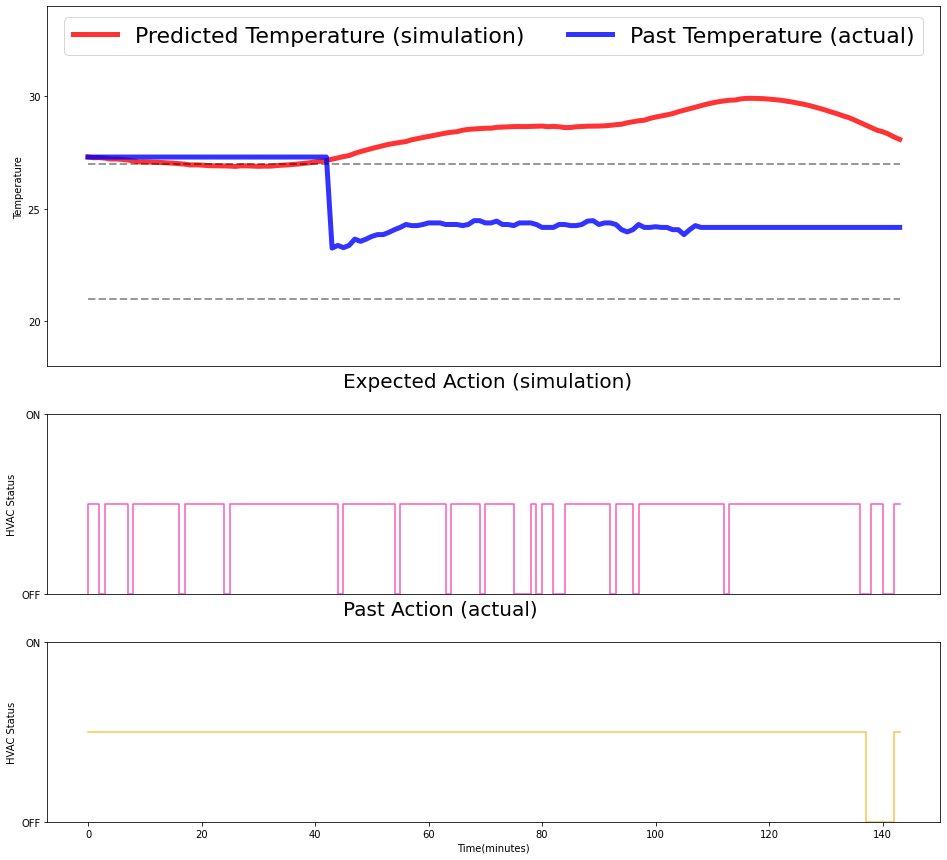

139.0
122
1 일 평균 절감율 :  12.23021582733813 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.265093306501498 오차율 :  -3.170579417612597


In [43]:
real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
new_df = pd.DataFrame()
new_df.index = real_df.index
new_df['real_temp'] = real_df['temp']
new_df['real_hum'] = real_df['hum']
new_df['real_action'] = real_df['action']
new_df['RL_temp'] = next_df['f3_temp']
new_df['RL_hum'] = next_df['f3_hum']
new_df['RL_action'] = actions
result_final_df = pd.DataFrame()

new_df.to_csv(f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DuelingDQN-pre.csv')
result_final_df = result_final_df.append(result_df)
result_final_df.to_csv("/raid/deallab/yechae/ECM/2023/result/DuelingDQN-pre.csv")

In [32]:
# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))

# config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
# config_dqn["log_level"] = "WARN"
# config_dqn["env"] = select_env
# config_dqn["env_config"] = env_config
# config_dqn["evaluation_num_workers"] = 1
# config_dqn["train_batch_size"] = 256
# # config_dqn["model.fcnet_activation"] = 'relu'
# config_dqn["target_network_update_freq"] = 50
# config_dqn["learning_starts"] = 100
# config_dqn["timesteps_per_iteration"] = 6
# config_dqn["num_gpus_per_worker"] = 1
# config_dqn["model"]["custom_model"] = False
# #config_dqn["model"]["custom_model"] = "my_model"
# config_dqn["model"]["fcnet_hiddens"] = [256,256]
# config_dqn["model"]["fcnet_activation"] = "relu"
# config_dqn["n_step"] = 6
# config_dqn["dueling"] = False
# config_dqn["double_q"] = False

In [38]:
checkpoint

'/raid/deallab/yechae/ECM/2023/result/2019-09-20/RL_ECM_DQN_linear_regression_2023-01-27_11-26-30j73v05ac/checkpoint_000100/checkpoint-100'

In [ ]:
w21_linear_regression

In [38]:
select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 100
config_dqn["timesteps_per_iteration"] = 6
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 6
config_dqn["dueling"] = True
config_dqn["double_q"] = False

2023-02-02 04:12:03,803	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-02-02 04:12:03,807	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 04:12:03,808	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-02-02 04:12:03,808	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


/raid/deallab/yechae/ECM/2023/result/2019-10-23/RL_ECM_DuelingDQN_2023-02-02_04-03-28j2g3xfzl/checkpoint_006100/checkpoint-6100
/raid/deallab/ecm/model_result/2019-10-24/20191024w7_linear_regression.joblib
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.4


2023-02-02 04:12:08,478	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 04:12:08,479	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


2023-02-02 04:12:08,771	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-23/RL_ECM_DuelingDQN_2023-02-02_04-03-28j2g3xfzl/checkpoint_006100/checkpoint-6100
2023-02-02 04:12:08,772	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 6100, '_timesteps_total': 1561600, '_time_total': 6922.641822814941, '_episodes_total': 28769}


100
start_after_for :  6.222724914550781e-05
Reset data f3_temp : 23.42
Reset data f3_temp : 23.72
Reset data f3_temp : 24.02
Reset data f3_temp : 23.42
Reset data f3_temp : 23.32
Reset data f3_temp : 23.32
Reset data f3_temp : 23.7
Reset data f3_temp : 24.1
Reset data f3_temp : 23.2
Reset data f3_temp : 24.05
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.32
Reset data f3_temp : 24.15
Reset data f3_temp : 23.82
Reset data f3_temp : 22.92
Reset data f3_temp : 23.42
Reset data f3_temp : 23.92


2023-02-02 04:12:10,582	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


  1 reward min :   0.00/ mean :  14.12/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DuelingDQN_2023-02-02_04-12-03_hn9krzq/checkpoint_006101/checkpoint-6101
Elapsed time one episode :  1.9184186458587646
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 24.1
Reset data f3_temp : 23.12
Reset data f3_temp : 23.82
Reset data f3_temp : 24.02
Reset data f3_temp : 24.1
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
(RolloutWorker pid=4127) Reset data f3_temp : 23.42
(RolloutWorker pid=4127) Reset data f3_temp : 23.72
Reset data f3_temp : 23.2
Reset data f3_temp : 23.4


(RolloutWorker pid=4127) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4127)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


  2 reward min : -15.00/ mean :   4.23/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9325509071350098
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.1
Reset data f3_temp : 23.12
Reset data f3_temp : 23.32
Reset data f3_temp : 23.32
Reset data f3_temp : 23.92
Reset data f3_temp : 23.2
Reset data f3_temp : 23.4
Reset data f3_temp : 23.2
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
  3 reward min : -15.00/ mean :   0.53/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0711472034454346
start_after_for :  4.76837158203125e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 23.12
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 23.4
Reset data f3_temp : 23.3
Reset data f3_temp : 24.05
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
Reset data f3_temp : 23.55
  4 reward min : -15.00/ mean :   0.75/ max :  15.00/ len   6.00
Elapsed time one episode :  1.05262494087

Reset data f3_temp : 23.12
Reset data f3_temp : 23.42
Reset data f3_temp : 23.12
Reset data f3_temp : 23.92
Reset data f3_temp : 23.32
Reset data f3_temp : 23.52
Reset data f3_temp : 23.4
Reset data f3_temp : 24.05
Reset data f3_temp : 23.42
 22 reward min : -15.00/ mean :  -7.74/ max :  12.48/ len   6.00
Elapsed time one episode :  1.0206916332244873
start_after_for :  5.9604644775390625e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 23.62
Reset data f3_temp : 24.05
Reset data f3_temp : 23.2
Reset data f3_temp : 23.92
Reset data f3_temp : 23.12
Reset data f3_temp : 23.3
Reset data f3_temp : 24.02
Reset data f3_temp : 23.25
Reset data f3_temp : 23.42
 23 reward min : -15.00/ mean :  -5.24/ max :  12.48/ len   6.00
Elapsed time one episode :  1.0220332145690918
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.92
Reset data f3_temp : 23.2
Reset data f3_temp : 23.12
Reset data f3_temp : 

Reset data f3_temp : 23.92
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 24.1
 41 reward min :   9.96/ mean :  12.35/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0009713172912598
start_after_for :  5.4836273193359375e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 23.72
Reset data f3_temp : 23.42
Reset data f3_temp : 24.1
Reset data f3_temp : 23.2
Reset data f3_temp : 23.82
Reset data f3_temp : 23.2
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 24.05
 42 reward min :   9.96/ mean :  12.18/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0163171291351318
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 23.12
Reset data f3_temp : 23.2
Reset data f3_temp : 23.92
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.82
Reset data f3_temp : 23.42
Reset data f3_temp : 23.32
 43 reward min :   9.96/ mean :  12.38/ max :  15.

Reset data f3_temp : 23.52
Reset data f3_temp : 23.92
Reset data f3_temp : 24.1
Reset data f3_temp : 23.62
Reset data f3_temp : 23.2
Reset data f3_temp : 23.82
Reset data f3_temp : 24.02
Reset data f3_temp : 23.2
Reset data f3_temp : 23.2
 61 reward min : -12.52/ mean :  11.36/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0466492176055908
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 23.2
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 23.32
Reset data f3_temp : 23.52
Reset data f3_temp : 23.92
Reset data f3_temp : 23.42
Reset data f3_temp : 23.82
 62 reward min : -12.52/ mean :  11.36/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1413092613220215
start_after_for :  1.3589859008789062e-05
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.92
Reset data f3_temp : 23

Reset data f3_temp : 24.02
Reset data f3_temp : 23.2
Reset data f3_temp : 23.42
Reset data f3_temp : 23.4
Reset data f3_temp : 23.42
Reset data f3_temp : 23.62
Reset data f3_temp : 23.92
Reset data f3_temp : 23.42
Reset data f3_temp : 23.32
Reset data f3_temp : 23.32
 81 reward min :  -0.02/ mean :  12.10/ max :  15.00/ len   6.00
Elapsed time one episode :  1.057990550994873
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 23.12
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.92
Reset data f3_temp : 23.72
Reset data f3_temp : 23.82
Reset data f3_temp : 23.12
Reset data f3_temp : 23.42
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
 82 reward min :   2.46/ mean :  12.23/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0107934474945068
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.55
Reset data f3_temp : 23.12
Reset data f3_temp : 23.42
Reset data f3_temp : 23.92
Reset data f3_temp : 2

Reset data f3_temp : 23.2
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
Reset data f3_temp : 23.2
Reset data f3_temp : 23.12
Reset data f3_temp : 23.12


2023-02-02 04:13:54,934	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


100 reward min : -15.00/ mean :  11.28/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0082595348358154
Elapsed time :  106.11518359184265
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DuelingDQN_2023-02-02_04-12-03_hn9krzq/checkpoint_006200/checkpoint-6200
F_SET_MODE_4
Reset data f3_temp : 23.72
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
2019-10-24 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  21 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.488294054764314


<Figure size 432x288 with 0 Axes>

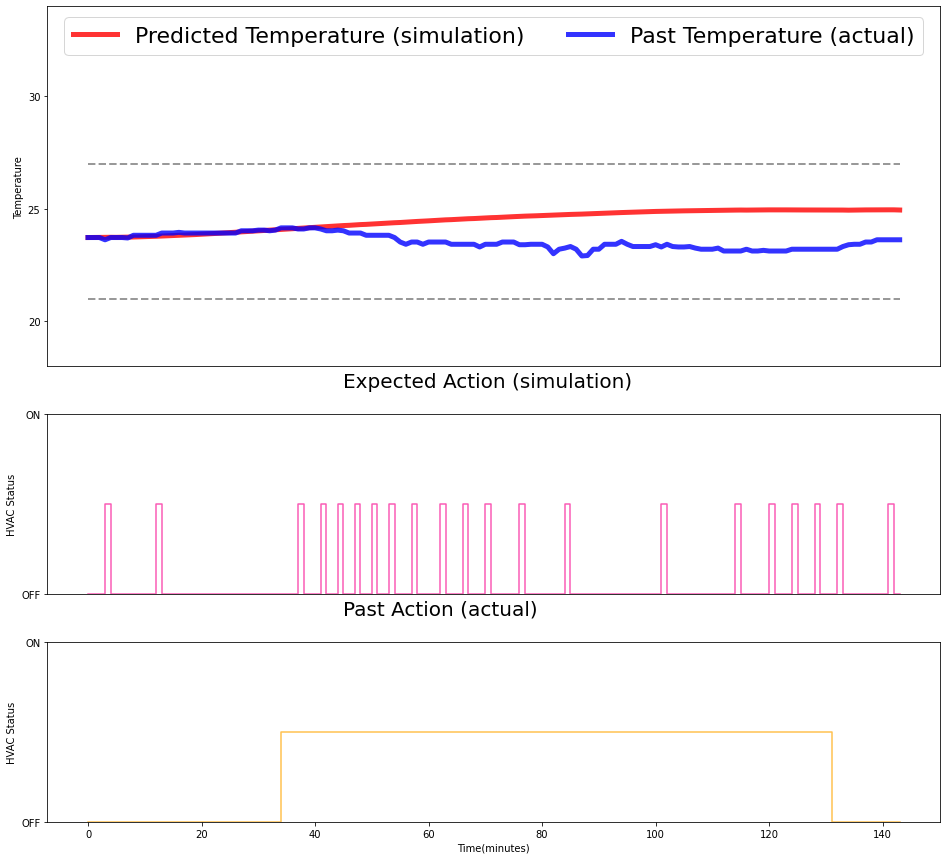

97.0
21
1 일 평균 절감율 :  78.35051546391753 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.488294054764314 오차율 :  -0.9335023880976578


In [39]:
Train_date =  datetime.date(2019,10,24)
#start_date = datetime.date(2019, 8,23)
end_date = datetime.date(2019,10,24)
daterange = pd.date_range(Train_date, end_date)

checkpoint_path = '/raid/deallab/yechae/ECM/2023/result/2019-10-23/RL_ECM_DuelingDQN_2023-02-02_04-03-28j2g3xfzl/checkpoint_006100/checkpoint-6100'
print(checkpoint_path)
first_start = time.time()
result_final_df = pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DuelingDQN-pre.csv')

for single_date in daterange:
#for i in range(81):
# 발산값 처리 
    if Train_date==datetime.date(2019,9,18) or Train_date==datetime.date(2019,8,27)  :
        Train_date = Train_date+datetime.timedelta(days=1)
        continue
        
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date)
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.window_size.values[0]
    model_name = cur_model.model.values[0]
    
    if Train_date == datetime.date(2019,10,3) or Train_date == datetime.date(2019,10,4):  # 결측 데이터 처리 
        df_test_pre = df_test_pre.interpolate(method='linear', limit_direction='forward')
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     one_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w1_linear_regression.joblib'
#     seven_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w7_linear_regression.joblib'
#     fourtenn_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w14_linear_regression.joblib'
#     model_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w21_linear_regression.joblib'


#     if Train_date <= datetime.date(2019,8,28):
#         path = one_day_path
#     elif Train_date <= datetime.date(2019,9,4):
#         path = seven_day_path
#     elif Train_date <= datetime.date(2019, 9,11):
#         path = fourtenn_day_path
#     else:
#         path = model_path
    path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
    print(path)
    
    max_action = getMaxAction(df_test_pre)
    method_name = "Env_ML"
    env_config = {'max_temp': 25, 'min_temp' : 23.5, 'method_name': method_name, 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}
    


    env = ECM_Env_ML(env_config)
    select_env = "ECMEnv2023-v0"
    register_env(select_env, lambda config: ECM_Env_ML(env_config))
    
    save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
    trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DuelingDQN'))
    
    trainer_dqn.restore(checkpoint_path)
    
    
    s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
    train_dqn_episode = 100
    reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
    # === Train === 
    start = time.time()
    start_after_for = time.time()
    print(train_dqn_episode)
    for i in range(train_dqn_episode):
        print("start_after_for : ", time.time() - start_after_for )
        start_episode = time.time()
        result = trainer_dqn.train()
        print(s.format(
            i + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"]
           ))
        reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
        if i % 100 == 0:
            checkpoint = trainer_dqn.save()
            print("checkpoint saved at", checkpoint)
        print("Elapsed time one episode : ", time.time() - start_episode)
        start_after_for = time.time()
    Elapsed_time = time.time() - start
    print("Elapsed time : ", Elapsed_time)
   
    checkpoint_path = trainer_dqn.save()

    print("checkpoint saved at", checkpoint_path)
    
    
    real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
    new_df = pd.DataFrame()
    new_df.index = real_df.index
    new_df['real_temp'] = real_df['temp']
    new_df['real_hum'] = real_df['hum']
    new_df['real_action'] = real_df['action']
    new_df['RL_temp'] = next_df['f3_temp']
    new_df['RL_hum'] = next_df['f3_hum']
    new_df['RL_action'] = actions
    
    # path 변경하기 
    new_df_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DuelingDQN-pre.csv.csv'
    new_df.to_csv(new_df_path)
    result_final_df = result_df.append(result_final_df)
    
     # elapsed 타임 너무 오래 걸리면 끝내기
    if Elapsed_time > 240:
        print(checkpoint)
        print(Train_date)
        print("Finished Time : ", time.time() - first_start)
        break

    
    Train_date = Train_date+datetime.timedelta(days=1)
    
#result_final_df = result_final_df.sort_values(by=['0'], axis=0)
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DuelingDQN-pre.csv'
result_final_df.to_csv(result_df_path)

    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [ ]:
# /raid/deallab/yechae/ECM/2023/result/2019-09-20/RL_ECM_DQN-lin-6-pre-basic-3_2023-02-01_13-15-35fvg49ev7/checkpoint_002800/checkpoint-2800 : 결과 잘 나올 것 같음 ㅠㅠ 

In [66]:
[ 5.2000000e+01,  5.6270924e+01,  2.5820463e+01,  2.2370001e+01,
       -7.8326700e+11,  8.0400002e+01,  9.6600801e+10,  2.7500000e+01,
       -2.0922839e+10]

2023-02-01 11:14:06,722	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff0e159c35f2d0f2d108f42edd01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 126.704317 GiB/126.704317 GiB memory, 0.000000/1.000000 GPU, 58.293233 GiB/58.293233 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


[52.0,
 56.270924,
 25.820463,
 22.370001,
 -783267000000.0,
 80.400002,
 96600801000.0,
 27.5,
 -20922839000.0]

(RolloutWorker pid=18204) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=18204)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


(RolloutWorker pid=18204) Reset data f3_temp : 21.07
(RolloutWorker pid=18204) Reset data f3_temp : 25.37


In [ ]:
app = test1.append(test2)

In [50]:
app = app.sort_values(by=['0'], axis=0)

In [51]:
app.to_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result.csv')

In [43]:
test1= pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result.csv')

In [44]:
test2= pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result-2.csv')

In [43]:
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-result.csv'
result_df.to_csv(result_df_path)

In [ ]:
'/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DQN-lin-6-pre-basic_2023-01-31_21-28-08h1rw2fp6/checkpoint_006300/checkpoint-6300' # 첫번째, reward = (action_reward * 2.5)  - temp_violation_reward - power_reward , basic

# 결과 확인

2023-02-02 04:14:36,106	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DuelingDQN_2023-02-02_04-12-03_hn9krzq/checkpoint_006200/checkpoint-6200
Reset data f3_temp : 23.2
Reset data f3_temp : 23.92
Reset data f3_temp : 23.72


2023-02-02 04:14:37,913	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 04:14:37,914	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 04:14:38,300	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DuelingDQN_2023-02-02_04-12-03_hn9krzq/checkpoint_006200/checkpoint-6200
2023-02-02 04:14:38,303	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 6200, '_timesteps_total': 1587200, '_time_total': 7023.969156742096, '_episodes_total': 29787}


/raid/deallab/ecm/model_result/2019-08-23/20190823w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 27.3
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-23 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  125 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.26900074137922


<Figure size 432x288 with 0 Axes>

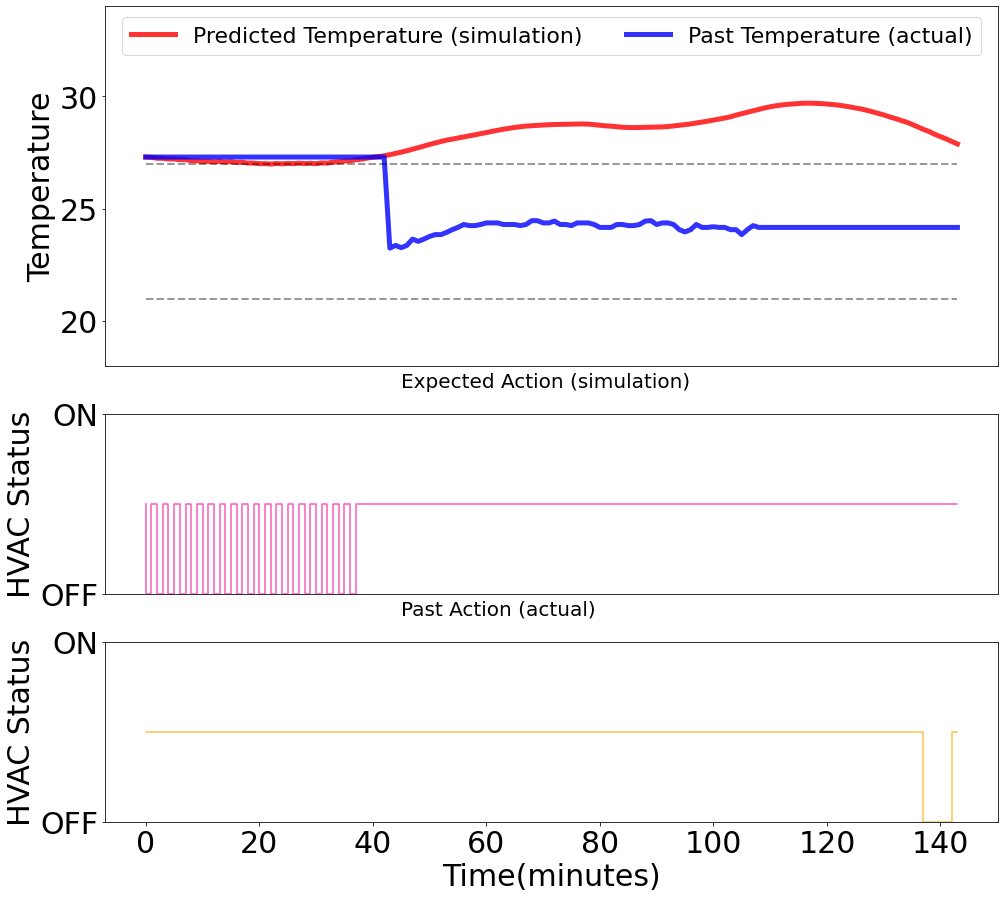

139.0
125
1 일 평균 절감율 :  10.071942446043165 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.26900074137922 오차율 :  -3.1744868524903183
/raid/deallab/ecm/model_result/2019-08-24/20190824w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 24.17
(RolloutWorker pid=4073) Reset data f3_temp : 23.2
(RolloutWorker pid=4073) Reset data f3_temp : 23.32


(RolloutWorker pid=4073) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4073)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-24 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  143 실제 평균 온도 :  21.98923611111115 학습 평균 온도 :  22.738814214536514


<Figure size 432x288 with 0 Axes>

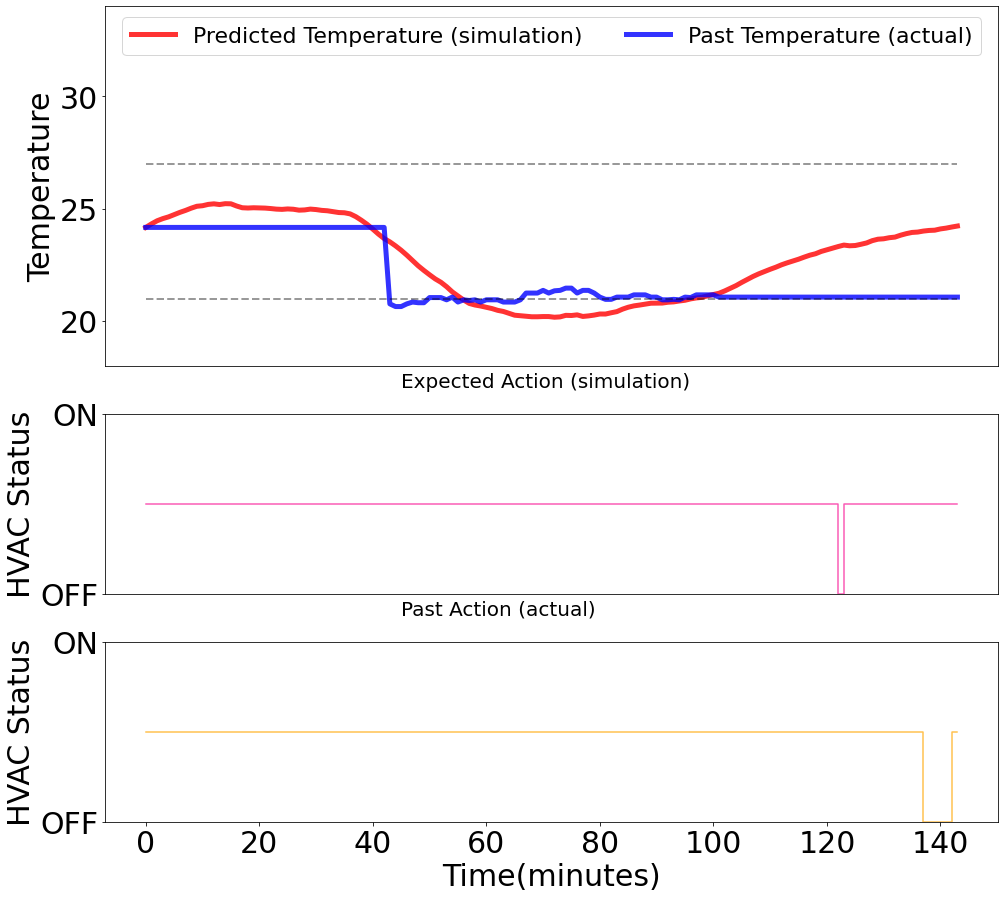

139.0
143
1 일 평균 절감율 :  -2.877697841726619 실제 평균 온도 :  21.98923611111115 학습 평균 온도 :  22.738814214536514 오차율 :  -0.7495781034253639
/raid/deallab/ecm/model_result/2019-08-25/20190825w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 21.07
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-25 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  141 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.698075312853952


<Figure size 432x288 with 0 Axes>

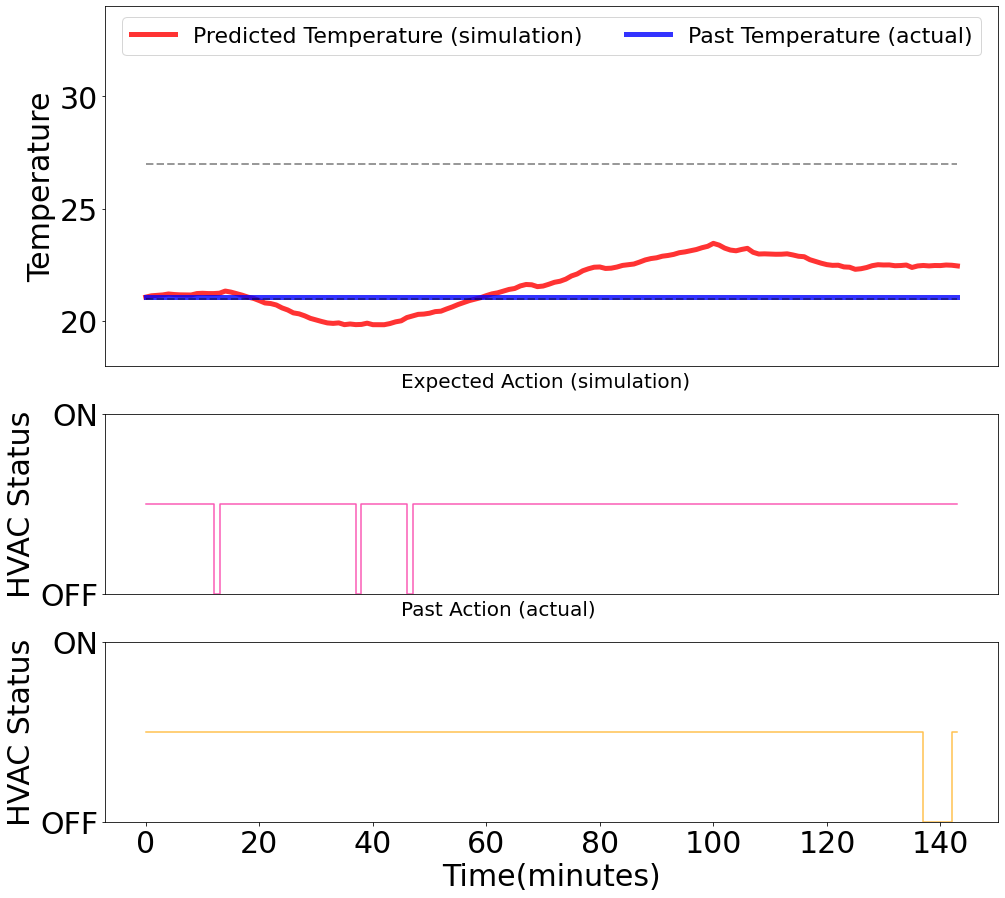

139.0
141
1 일 평균 절감율 :  -1.4388489208633095 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.698075312853952 오차율 :  -0.628075312853916
/raid/deallab/ecm/model_result/2019-08-26/20190826w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 21.07
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-26 실제 데이터 길이 :  144  : real action :  144.0 , expected action :  142 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.07000000000004


<Figure size 432x288 with 0 Axes>

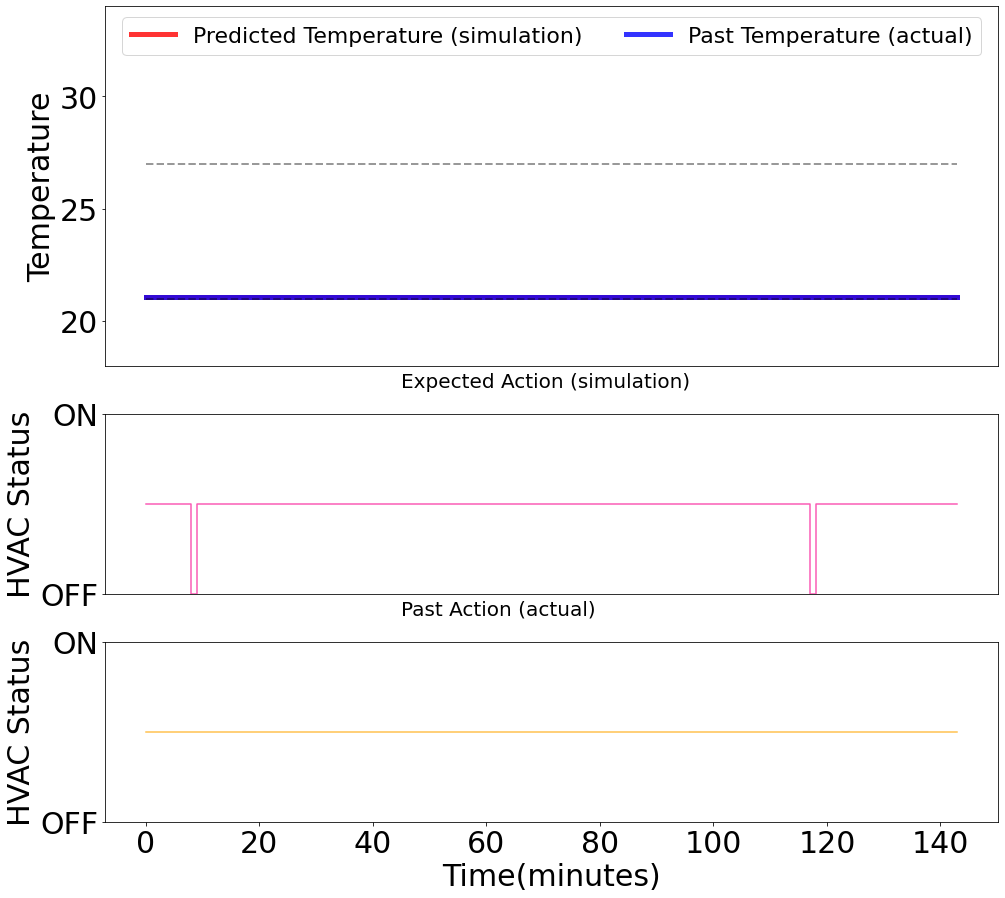

144.0
142
1 일 평균 절감율 :  1.3888888888888888 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.07000000000004 오차율 :  -3.552713678800501e-15
/raid/deallab/ecm/model_result/2019-08-27/20190827w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.07
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-27 실제 데이터 길이 :  144  : real action :  79.0 , expected action :  143 실제 평균 온도 :  23.379374999999953 학습 평균 온도 :  21.070000000000036


<Figure size 432x288 with 0 Axes>

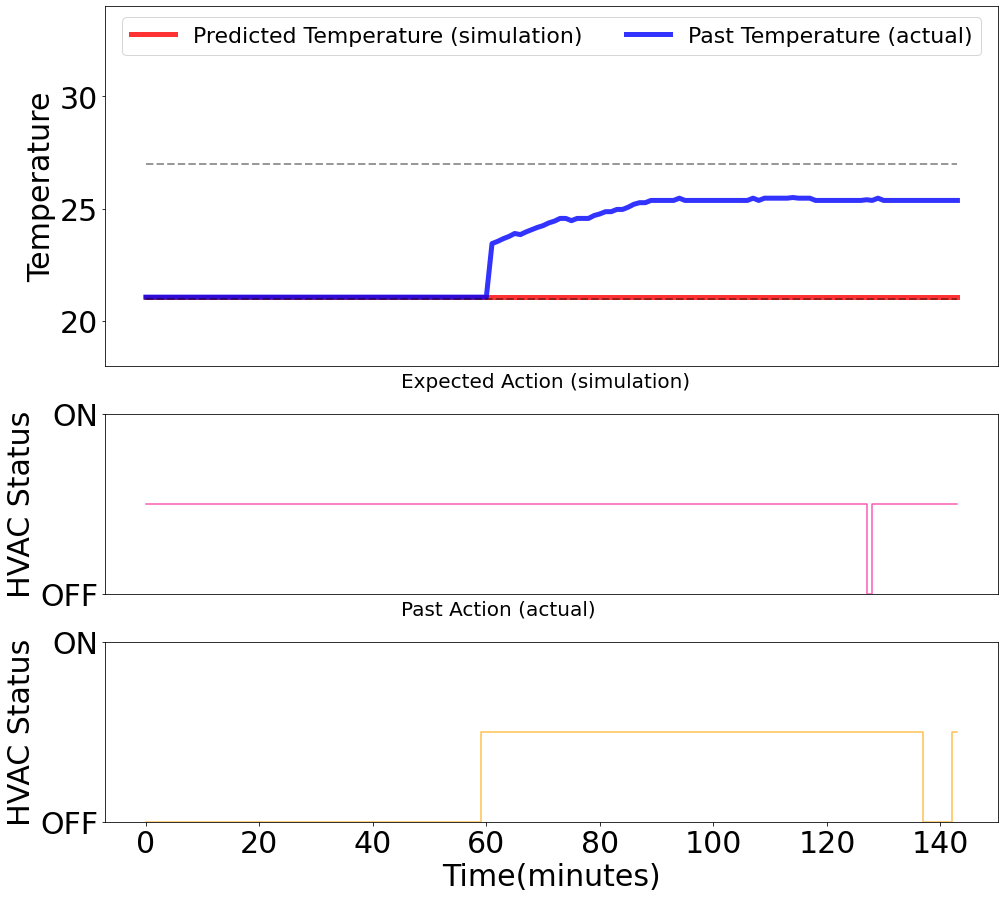

79.0
143
1 일 평균 절감율 :  -81.0126582278481 실제 평균 온도 :  23.379374999999953 학습 평균 온도 :  21.070000000000036 오차율 :  2.3093749999999176
/raid/deallab/ecm/model_result/2019-08-28/20190828w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.37
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-08-28 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  34 실제 평균 온도 :  25.814513888888925 학습 평균 온도 :  25.336650836955236


<Figure size 432x288 with 0 Axes>

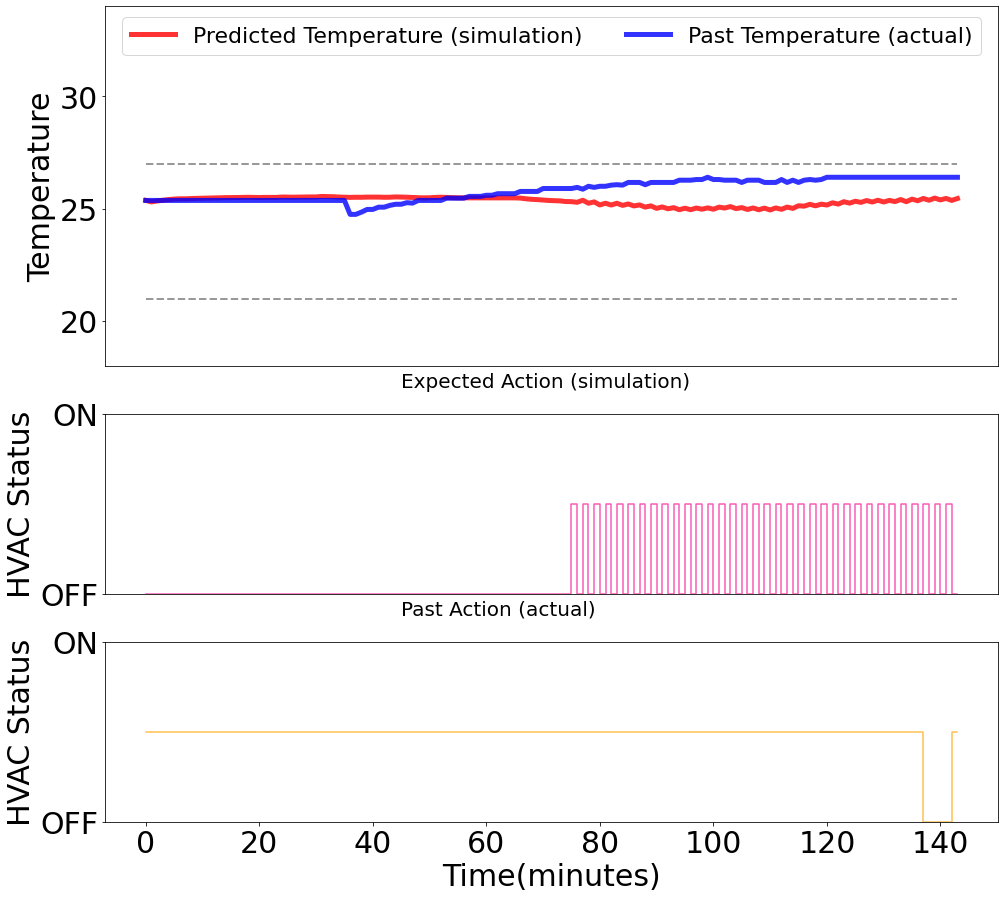

139.0
34
1 일 평균 절감율 :  75.53956834532374 실제 평균 온도 :  25.814513888888925 학습 평균 온도 :  25.336650836955236 오차율 :  0.4778630519336886
/raid/deallab/ecm/model_result/2019-08-29/20190829w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.4
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-08-29 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  43 실제 평균 온도 :  25.631250000000026 학습 평균 온도 :  26.129478565530132


<Figure size 432x288 with 0 Axes>

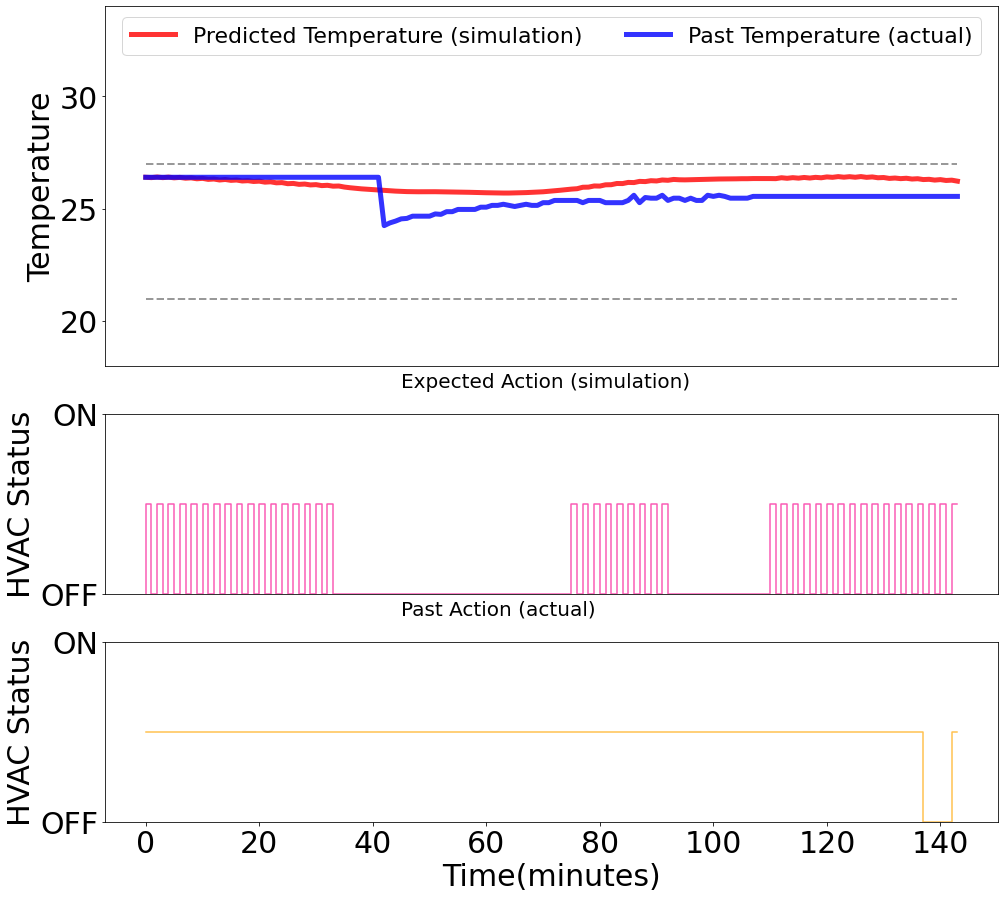

139.0
43
1 일 평균 절감율 :  69.06474820143885 실제 평균 온도 :  25.631250000000026 학습 평균 온도 :  26.129478565530132 오차율 :  -0.4982285655301055
/raid/deallab/ecm/model_result/2019-08-30/20190830w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.55
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-08-30 실제 데이터 길이 :  144  : real action :  137.0 , expected action :  72 실제 평균 온도 :  24.43333333333327 학습 평균 온도 :  24.02784588014593


<Figure size 432x288 with 0 Axes>

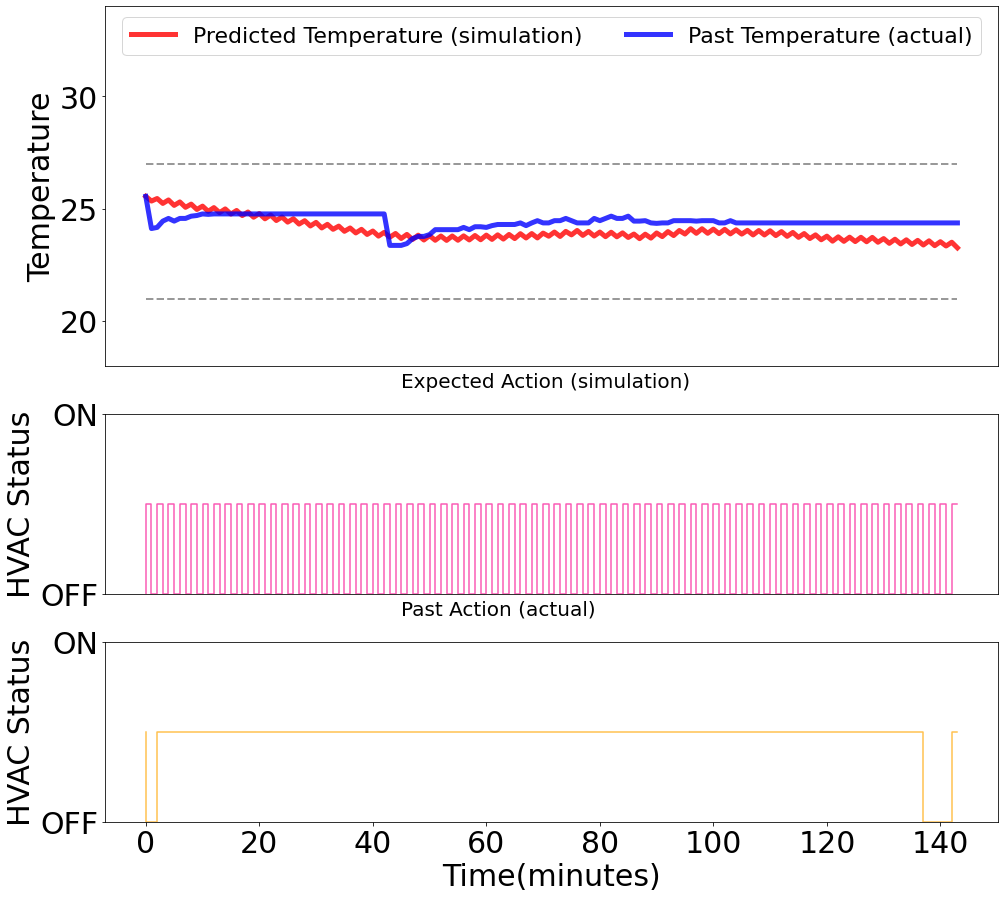

137.0
72
1 일 평균 절감율 :  47.44525547445255 실제 평균 온도 :  24.43333333333327 학습 평균 온도 :  24.02784588014593 오차율 :  0.4054874531873409
/raid/deallab/ecm/model_result/2019-08-31/20190831w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.37
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-08-31 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  72 실제 평균 온도 :  23.26999999999999 학습 평균 온도 :  23.540746256814806


<Figure size 432x288 with 0 Axes>

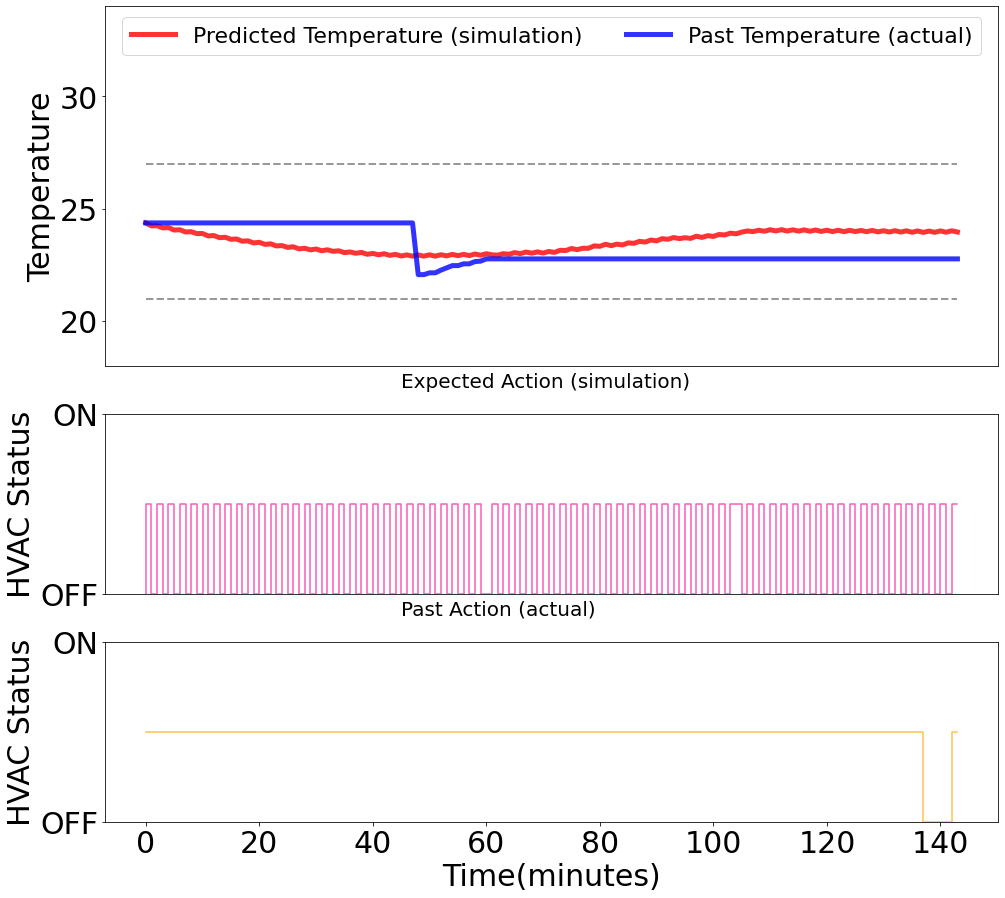

139.0
72
1 일 평균 절감율 :  48.201438848920866 실제 평균 온도 :  23.26999999999999 학습 평균 온도 :  23.540746256814806 오차율 :  -0.27074625681481734
/raid/deallab/ecm/model_result/2019-09-01/20190901w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.77
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
2019-09-01 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  57 실제 평균 온도 :  22.769999999999985 학습 평균 온도 :  23.549032436629222


<Figure size 432x288 with 0 Axes>

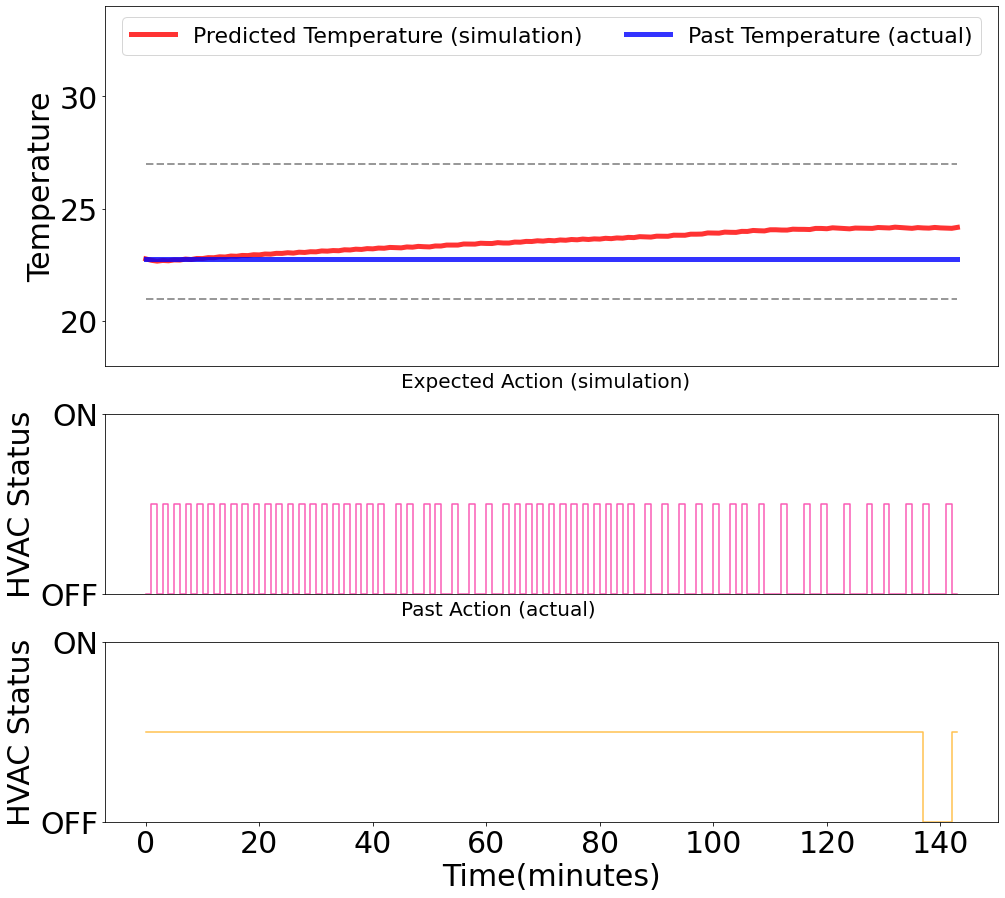

139.0
57
1 일 평균 절감율 :  58.992805755395686 실제 평균 온도 :  22.769999999999985 학습 평균 온도 :  23.549032436629222 오차율 :  -0.7790324366292367
/raid/deallab/ecm/model_result/2019-09-02/20190902w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-02 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  2 실제 평균 온도 :  23.638333333333335 학습 평균 온도 :  23.837486591056702


<Figure size 432x288 with 0 Axes>

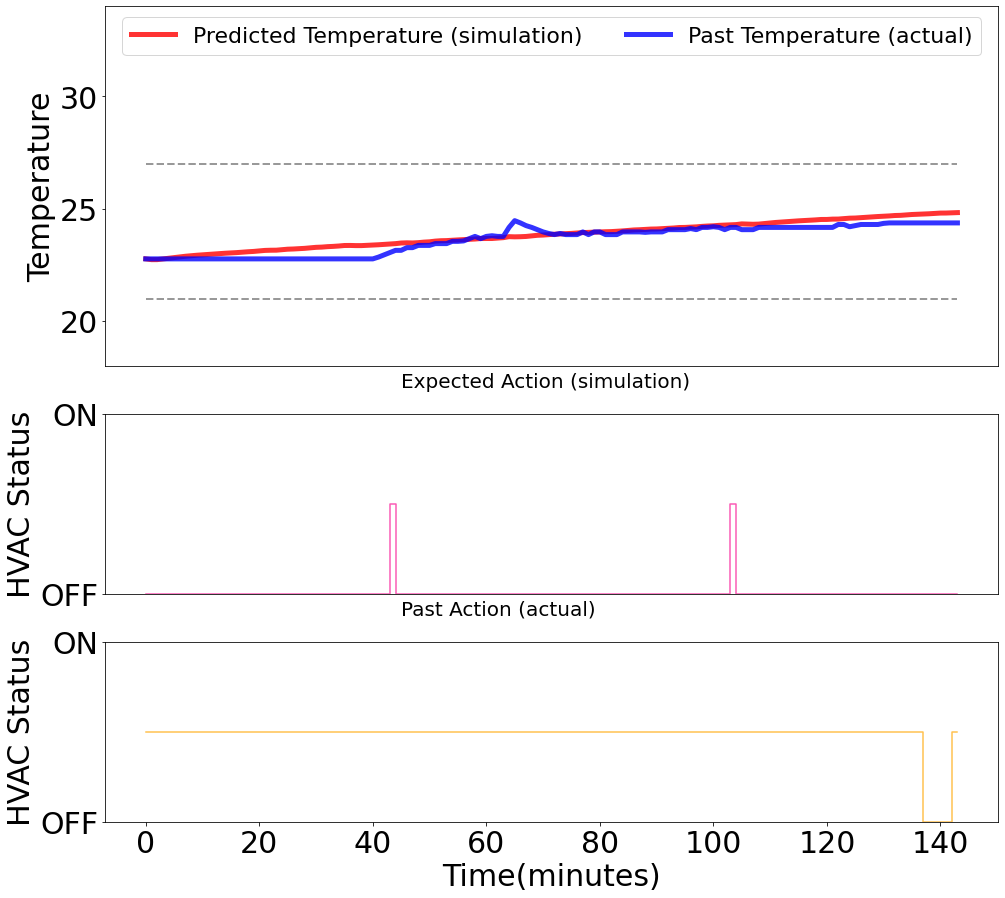

139.0
2
1 일 평균 절감율 :  98.56115107913669 실제 평균 온도 :  23.638333333333335 학습 평균 온도 :  23.837486591056702 오차율 :  -0.199153257723367
/raid/deallab/ecm/model_result/2019-09-03/20190903w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.37
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-03 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  4 실제 평균 온도 :  24.793124999999982 학습 평균 온도 :  25.074832739481568


<Figure size 432x288 with 0 Axes>

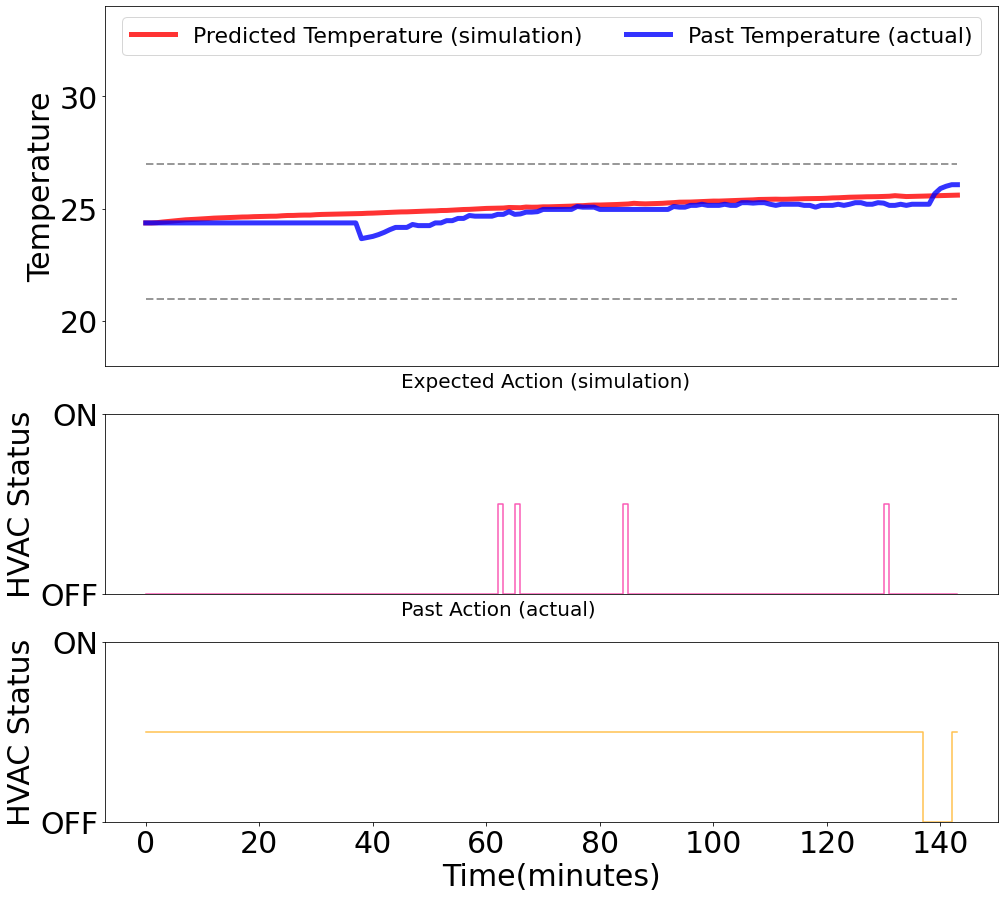

139.0
4
1 일 평균 절감율 :  97.12230215827337 실제 평균 온도 :  24.793124999999982 학습 평균 온도 :  25.074832739481568 오차율 :  -0.2817077394815861
/raid/deallab/ecm/model_result/2019-09-04/20190904w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.07
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
2019-09-04 실제 데이터 길이 :  144  : real action :  130.0 , expected action :  3 실제 평균 온도 :  26.05597222222217 학습 평균 온도 :  25.839129727481907


<Figure size 432x288 with 0 Axes>

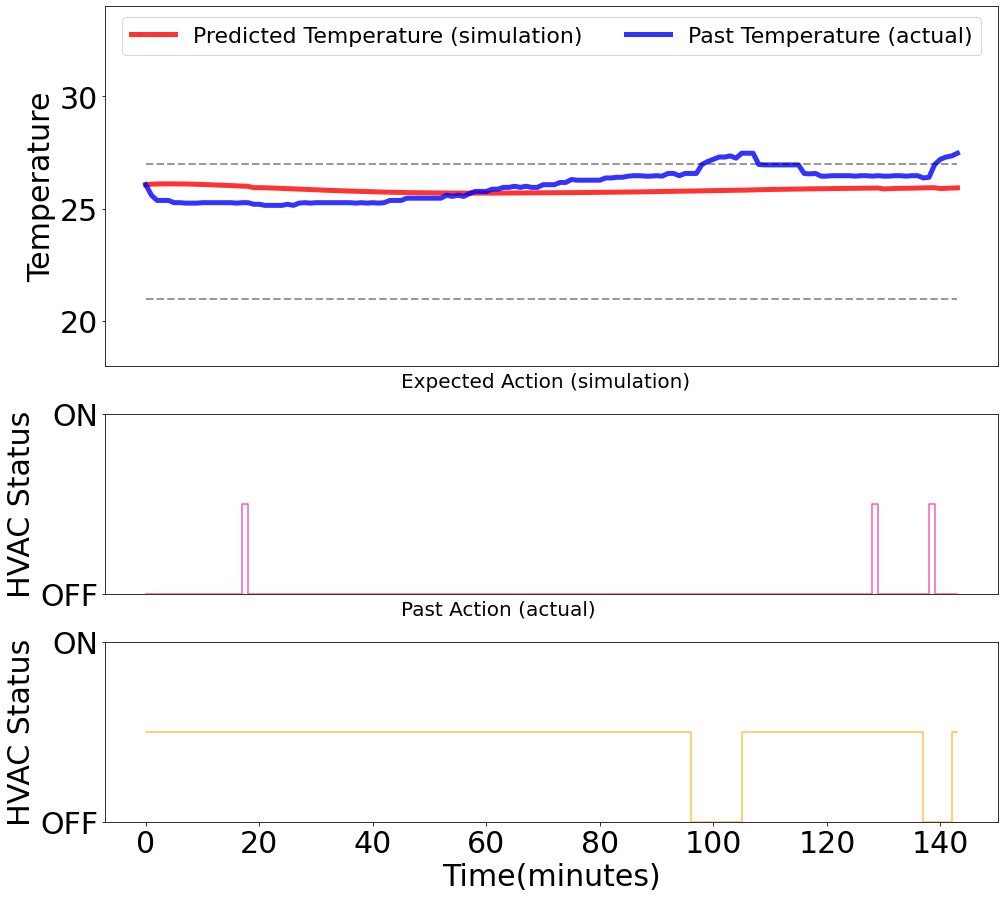

130.0
3
1 일 평균 절감율 :  97.6923076923077 실제 평균 온도 :  26.05597222222217 학습 평균 온도 :  25.839129727481907 오차율 :  0.21684249474026274
/raid/deallab/ecm/model_result/2019-09-05/20190905w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 27.37
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
2019-09-05 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  39 실제 평균 온도 :  25.426458333333343 학습 평균 온도 :  27.76967053105861


<Figure size 432x288 with 0 Axes>

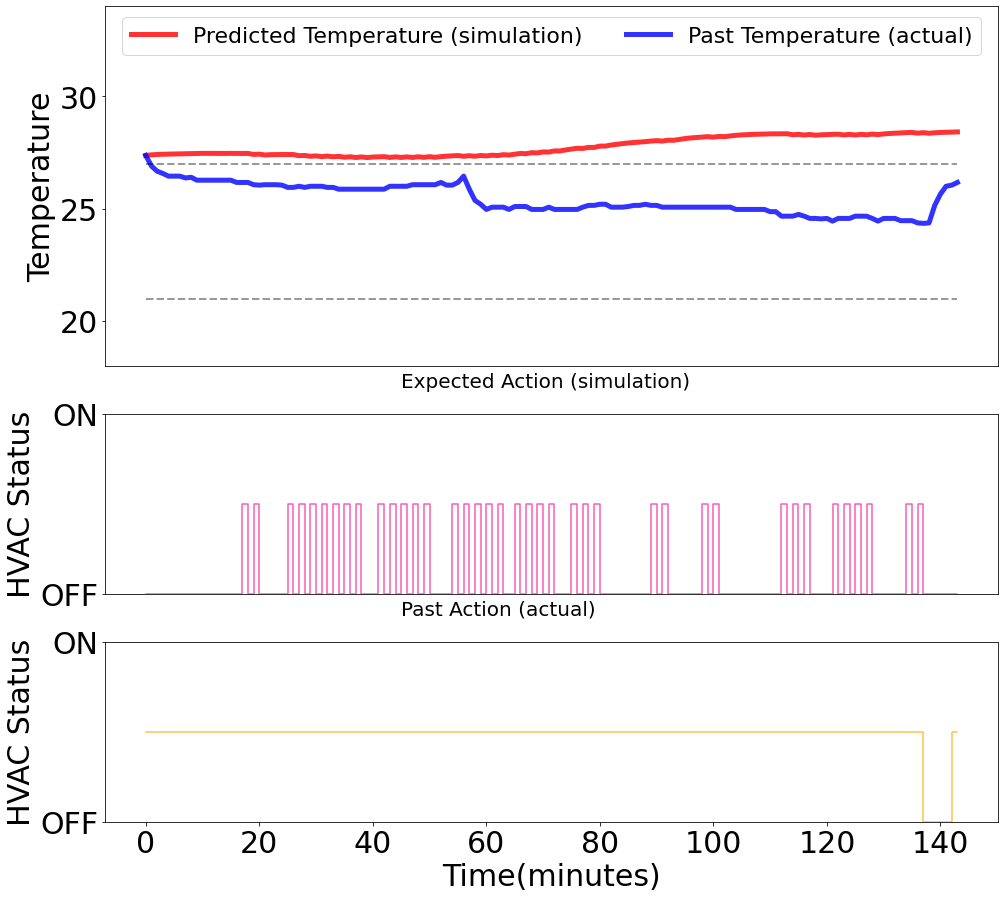

139.0
39
1 일 평균 절감율 :  71.94244604316546 실제 평균 온도 :  25.426458333333343 학습 평균 온도 :  27.76967053105861 오차율 :  -2.343212197725265
/raid/deallab/ecm/model_result/2019-09-06/20190906w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
2019-09-06 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  11 실제 평균 온도 :  24.405972222222196 학습 평균 온도 :  28.346614700431104


<Figure size 432x288 with 0 Axes>

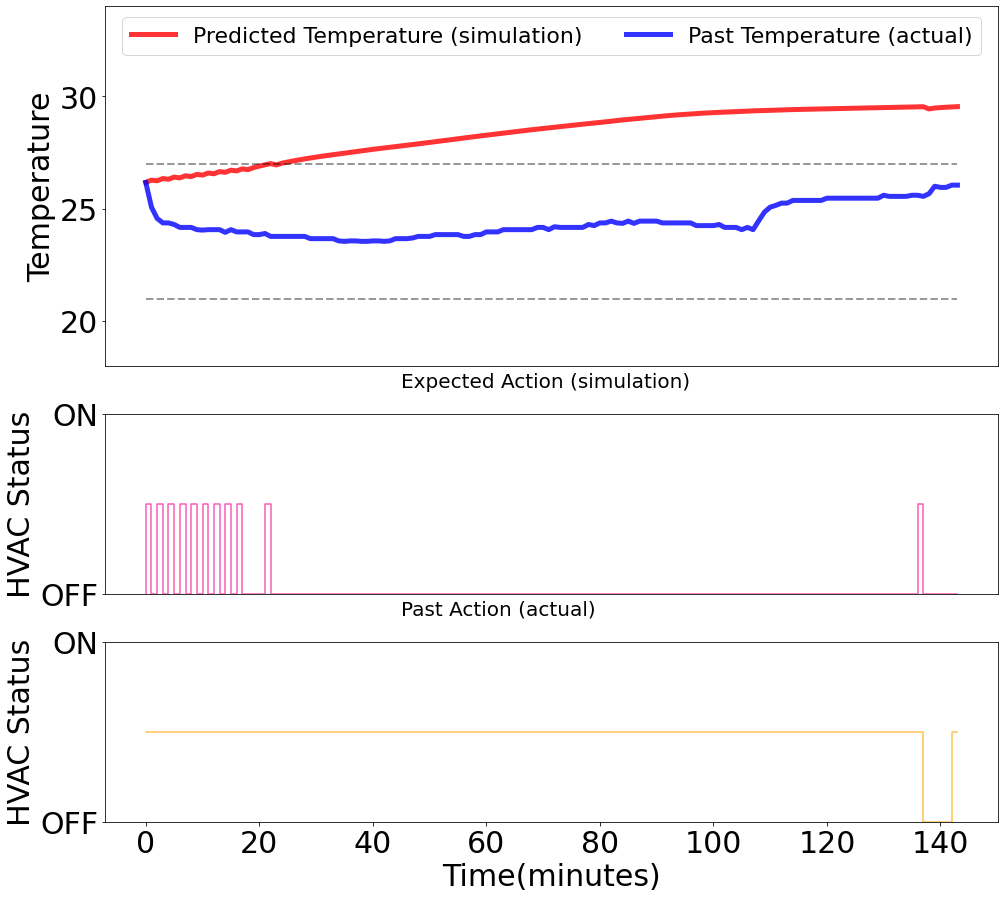

139.0
11
1 일 평균 절감율 :  92.08633093525181 실제 평균 온도 :  24.405972222222196 학습 평균 온도 :  28.346614700431104 오차율 :  -3.9406424782089076
/raid/deallab/ecm/model_result/2019-09-07/20190907w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.95
[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-07 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  60 실제 평균 온도 :  25.782152777777753 학습 평균 온도 :  27.5037668394114


<Figure size 432x288 with 0 Axes>

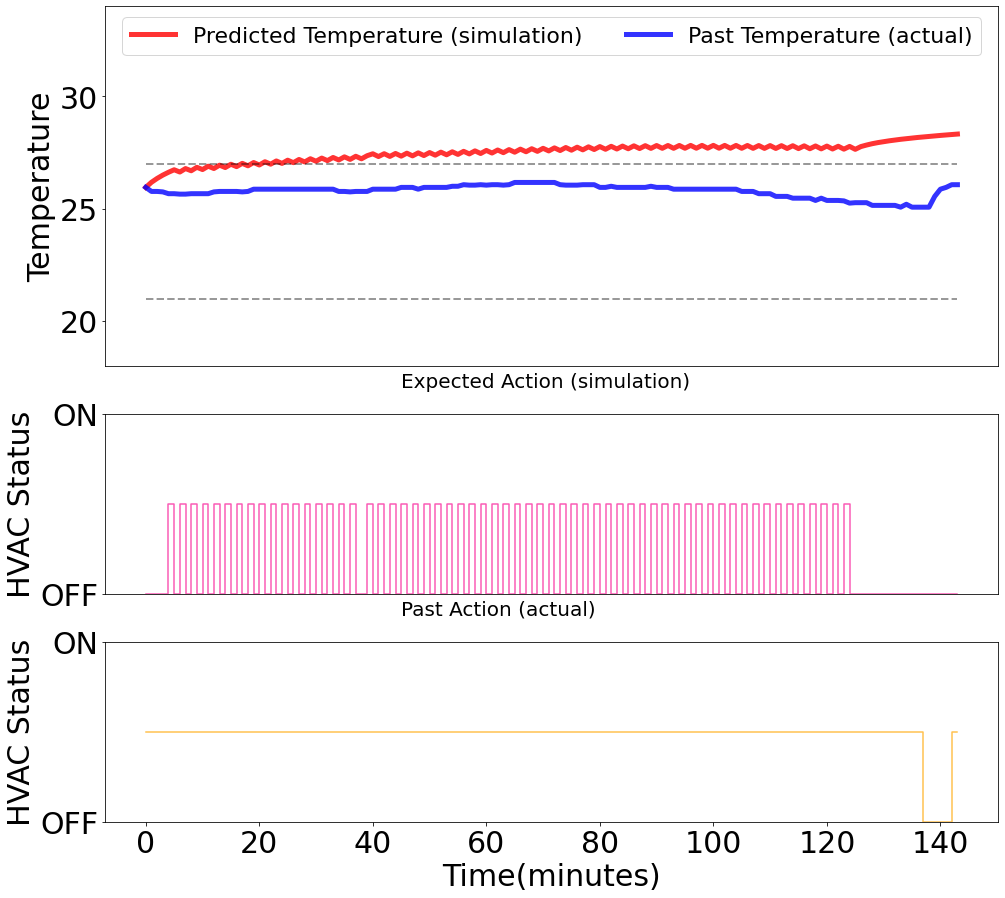

139.0
60
1 일 평균 절감율 :  56.83453237410072 실제 평균 온도 :  25.782152777777753 학습 평균 온도 :  27.5037668394114 오차율 :  -1.7216140616336482
/raid/deallab/ecm/model_result/2019-09-08/20190908w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.05
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-08 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  4 실제 평균 온도 :  25.039444444444403 학습 평균 온도 :  28.043766051291755


<Figure size 432x288 with 0 Axes>

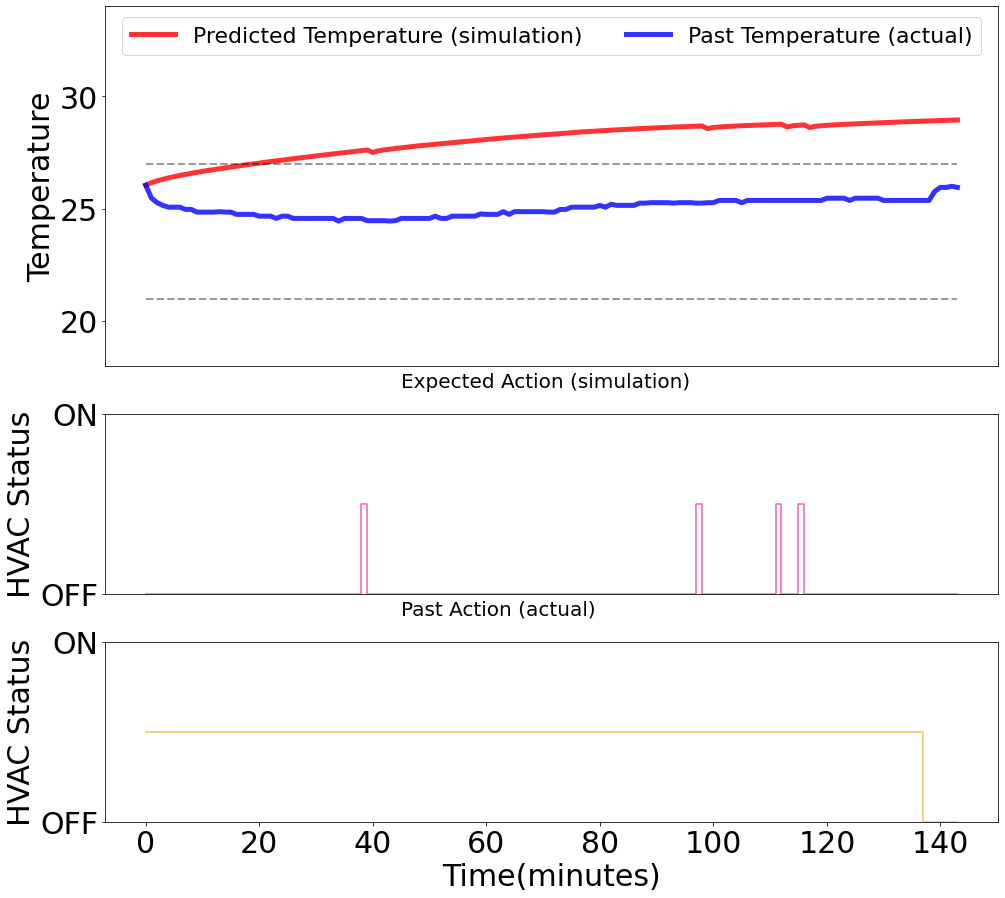

138.0
4
1 일 평균 절감율 :  97.10144927536231 실제 평균 온도 :  25.039444444444403 학습 평균 온도 :  28.043766051291755 오차율 :  -3.004321606847352
/raid/deallab/ecm/model_result/2019-09-09/20190909w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.95
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-09 실제 데이터 길이 :  144  : real action :  140.0 , expected action :  14 실제 평균 온도 :  25.180833333333325 학습 평균 온도 :  27.979975571728506


<Figure size 432x288 with 0 Axes>

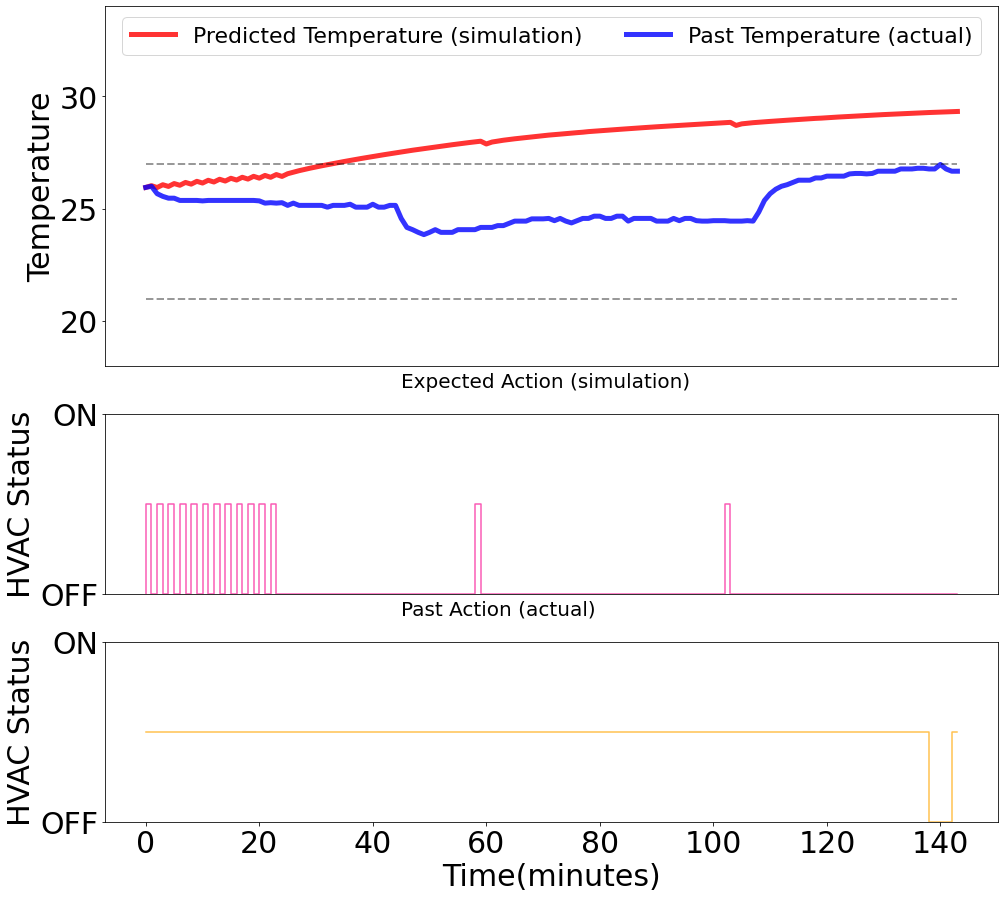

140.0
14
1 일 평균 절감율 :  90.0 실제 평균 온도 :  25.180833333333325 학습 평균 온도 :  27.979975571728506 오차율 :  -2.7991422383951807
/raid/deallab/ecm/model_result/2019-09-10/20190910w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-10 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  50 실제 평균 온도 :  25.288888888888867 학습 평균 온도 :  27.181630037802258


<Figure size 432x288 with 0 Axes>

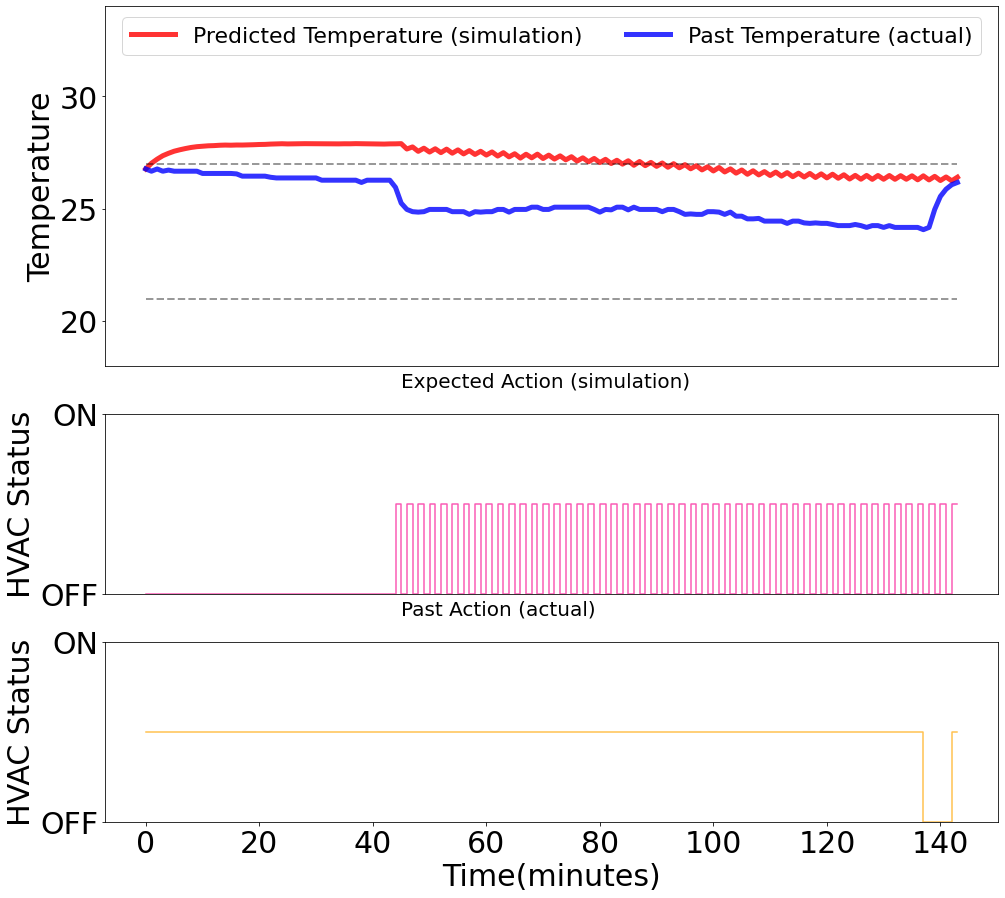

139.0
50
1 일 평균 절감율 :  64.02877697841727 실제 평균 온도 :  25.288888888888867 학습 평균 온도 :  27.181630037802258 오차율 :  -1.892741148913391
/raid/deallab/ecm/model_result/2019-09-11/20190911w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-09-11 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  70 실제 평균 온도 :  24.302152777777774 학습 평균 온도 :  26.758052502291157


<Figure size 432x288 with 0 Axes>

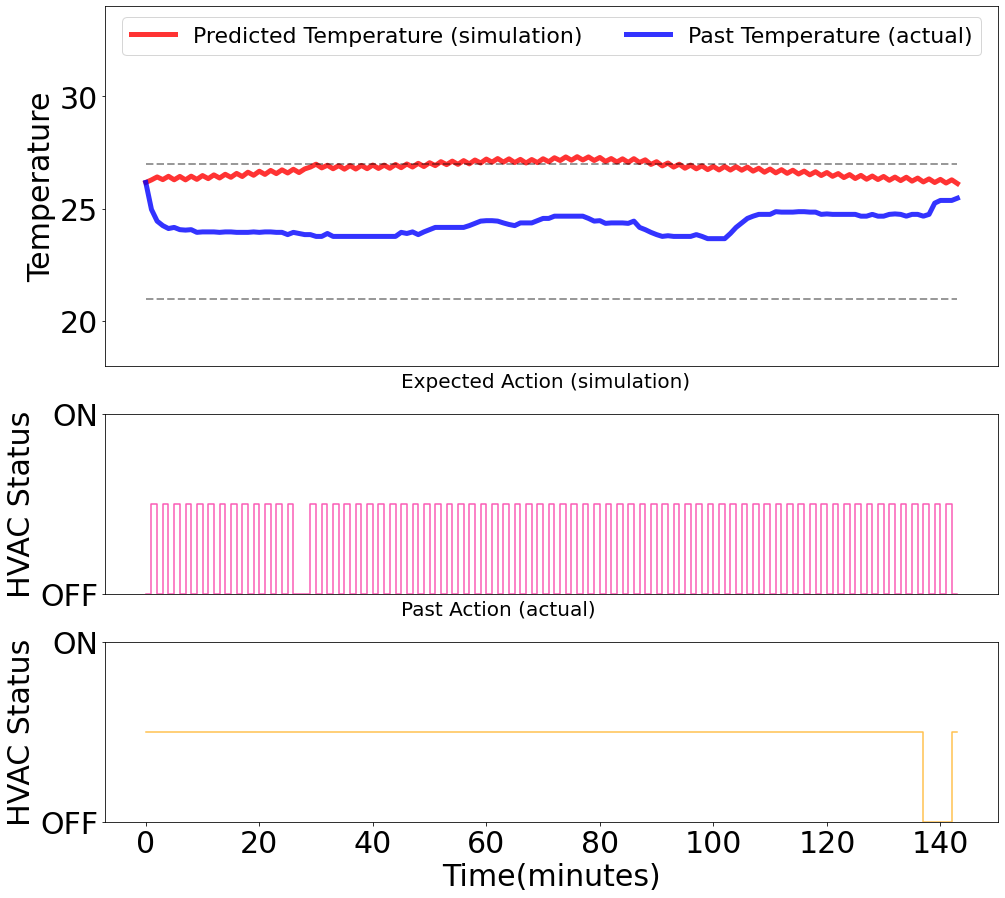

139.0
70
1 일 평균 절감율 :  49.64028776978417 실제 평균 온도 :  24.302152777777774 학습 평균 온도 :  26.758052502291157 오차율 :  -2.455899724513383
/raid/deallab/ecm/model_result/2019-09-12/20190912w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.47
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-12 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  44 실제 평균 온도 :  23.907569444444448 학습 평균 온도 :  25.302169509054703


<Figure size 432x288 with 0 Axes>

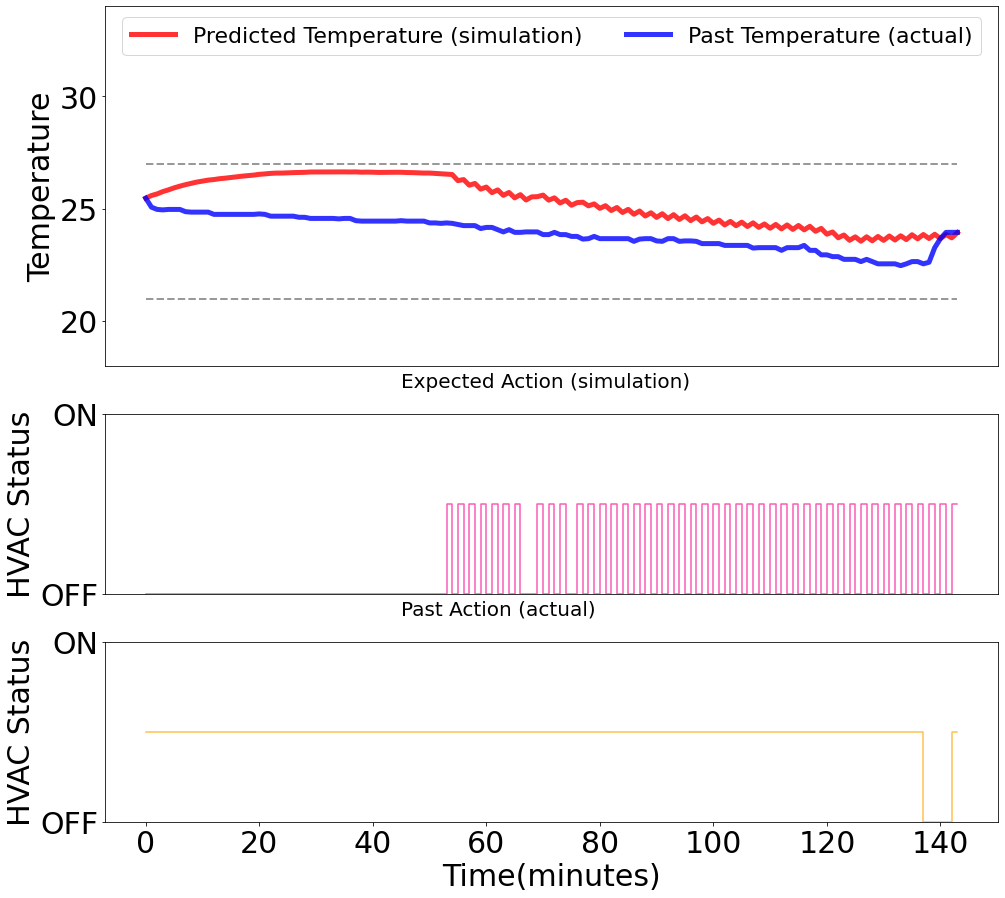

139.0
44
1 일 평균 절감율 :  68.34532374100719 실제 평균 온도 :  23.907569444444448 학습 평균 온도 :  25.302169509054703 오차율 :  -1.3946000646102554
/raid/deallab/ecm/model_result/2019-09-13/20190913w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.95
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-13 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  0 실제 평균 온도 :  22.905625000000043 학습 평균 온도 :  26.07264162850676


<Figure size 432x288 with 0 Axes>

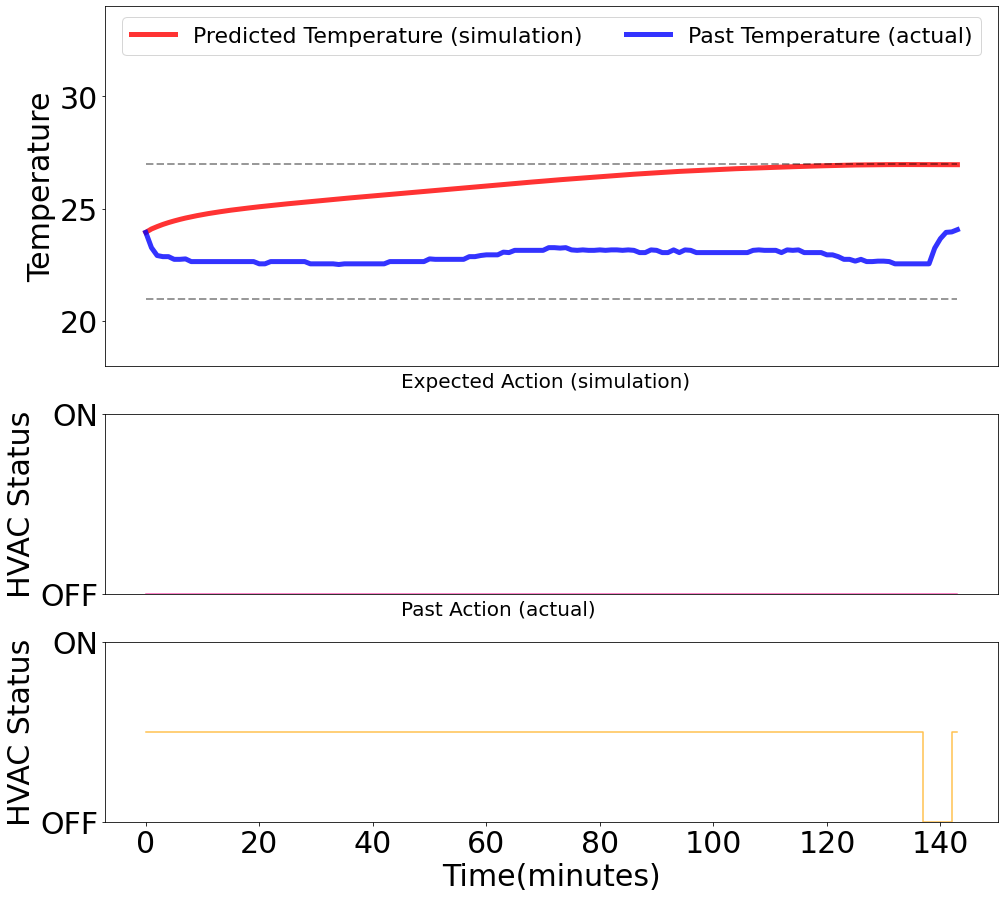

139.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  22.905625000000043 학습 평균 온도 :  26.07264162850676 오차율 :  -3.1670166285067154
/raid/deallab/ecm/model_result/2019-09-14/20190914w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.97
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-09-14 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  41 실제 평균 온도 :  23.40687499999999 학습 평균 온도 :  25.056434698503782


<Figure size 432x288 with 0 Axes>

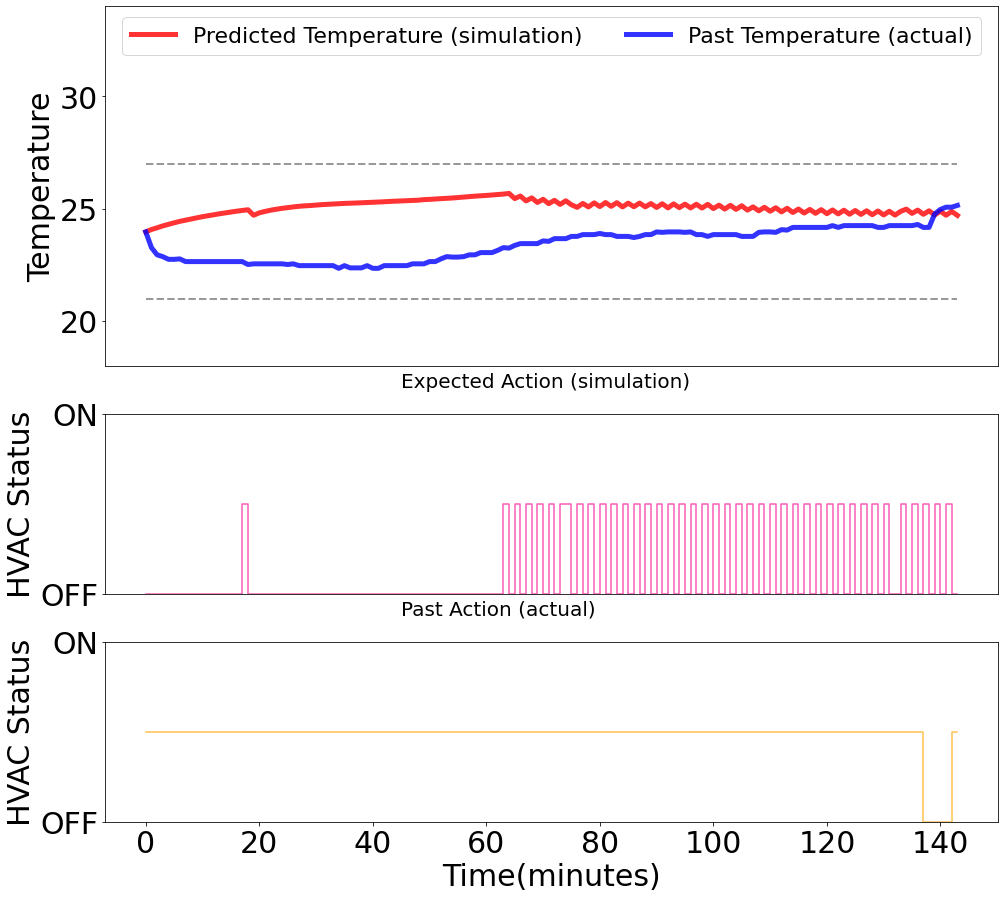

139.0
41
1 일 평균 절감율 :  70.50359712230215 실제 평균 온도 :  23.40687499999999 학습 평균 온도 :  25.056434698503782 오차율 :  -1.6495596985037935
/raid/deallab/ecm/model_result/2019-09-15/20190915w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.15
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
2019-09-15 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  24.792361111111124 학습 평균 온도 :  27.7773527265296


<Figure size 432x288 with 0 Axes>

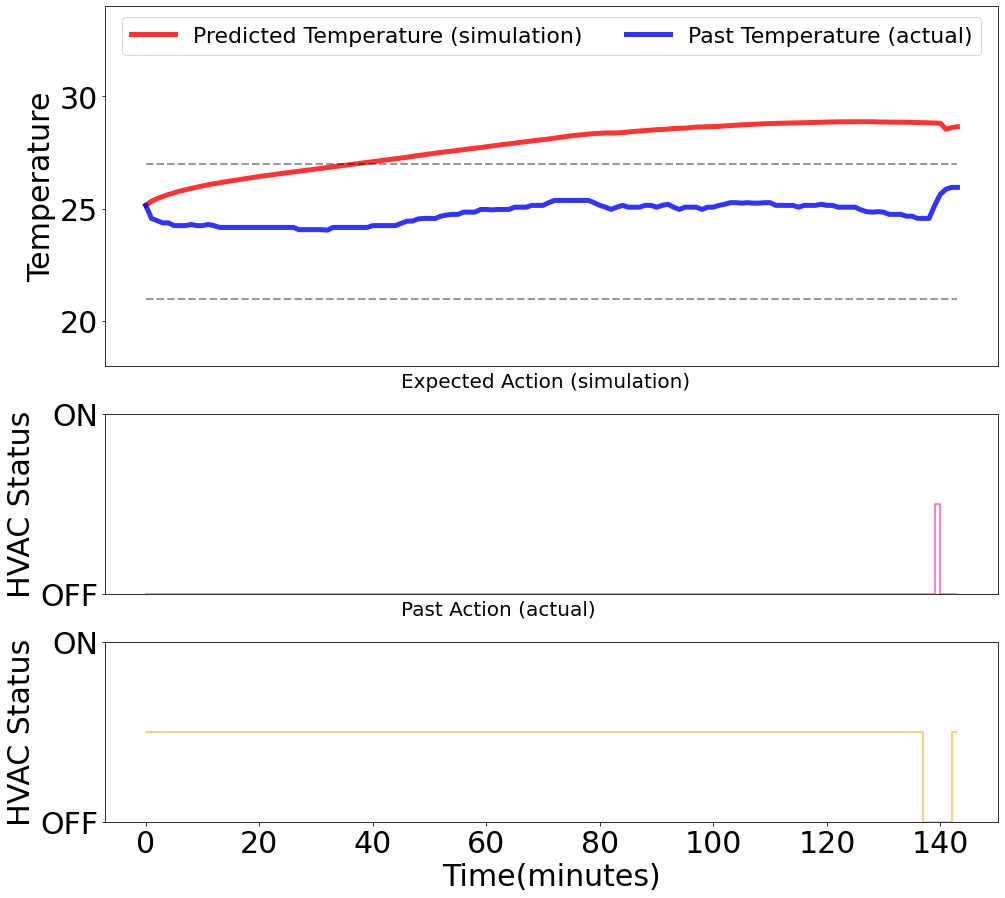

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  24.792361111111124 학습 평균 온도 :  27.7773527265296 오차율 :  -2.984991615418476
/raid/deallab/ecm/model_result/2019-09-16/20190916w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.87
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-16 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  23.038611111111102 학습 평균 온도 :  27.233289448184145


<Figure size 432x288 with 0 Axes>

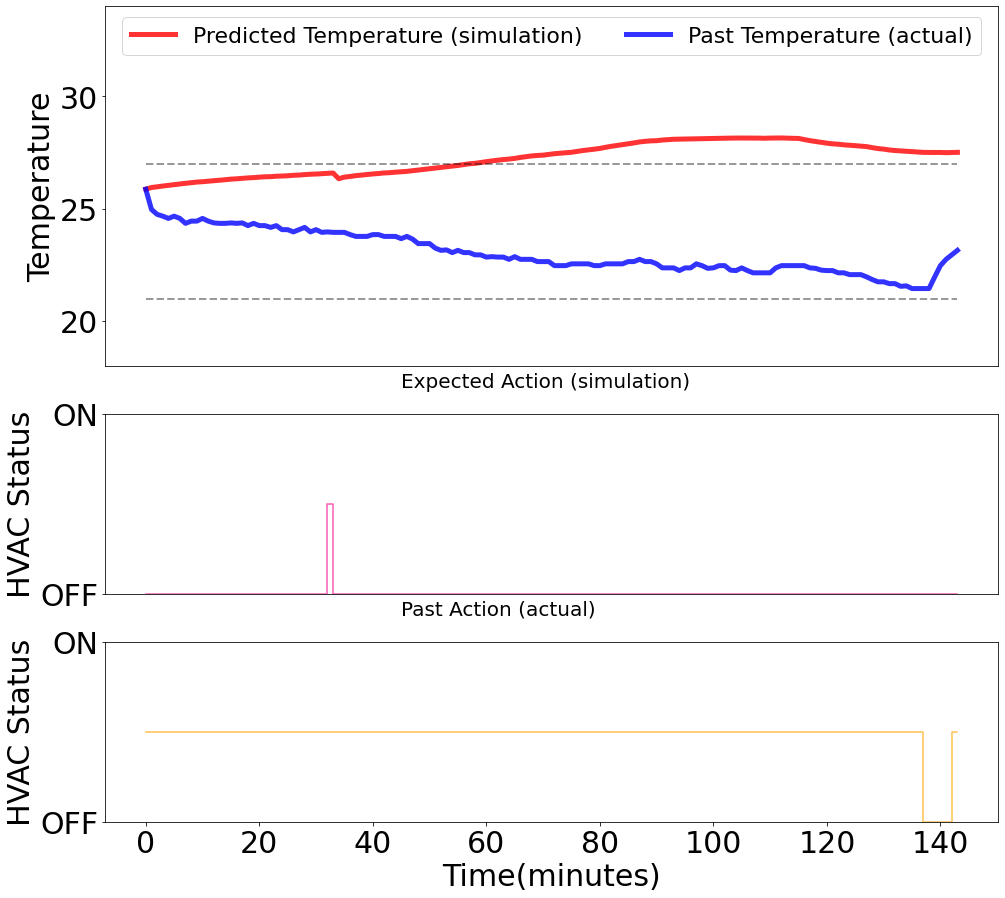

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  23.038611111111102 학습 평균 온도 :  27.233289448184145 오차율 :  -4.194678337073043
/raid/deallab/ecm/model_result/2019-09-17/20190917w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.95
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-17 실제 데이터 길이 :  144  : real action :  106.0 , expected action :  12 실제 평균 온도 :  20.71111111111105 학습 평균 온도 :  26.30093899260687


<Figure size 432x288 with 0 Axes>

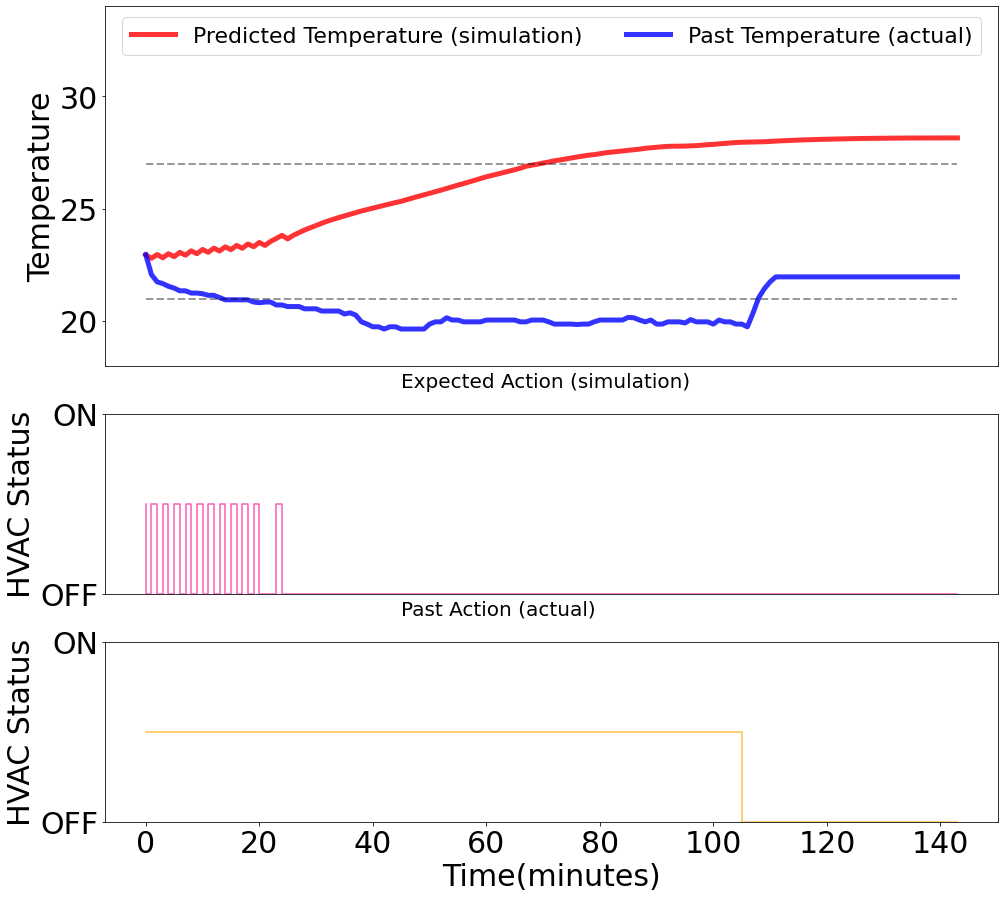

106.0
12
1 일 평균 절감율 :  88.67924528301887 실제 평균 온도 :  20.71111111111105 학습 평균 온도 :  26.30093899260687 오차율 :  -5.589827881495818
/raid/deallab/ecm/model_result/2019-09-18/20190918w1_linear_regression.joblib
F_SET_MODE_0
Reset data f3_temp : 21.97
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-18 실제 데이터 길이 :  144  : real action :  98.0 , expected action :  143 실제 평균 온도 :  21.58861111111112 학습 평균 온도 :  20.735822419252578


<Figure size 432x288 with 0 Axes>

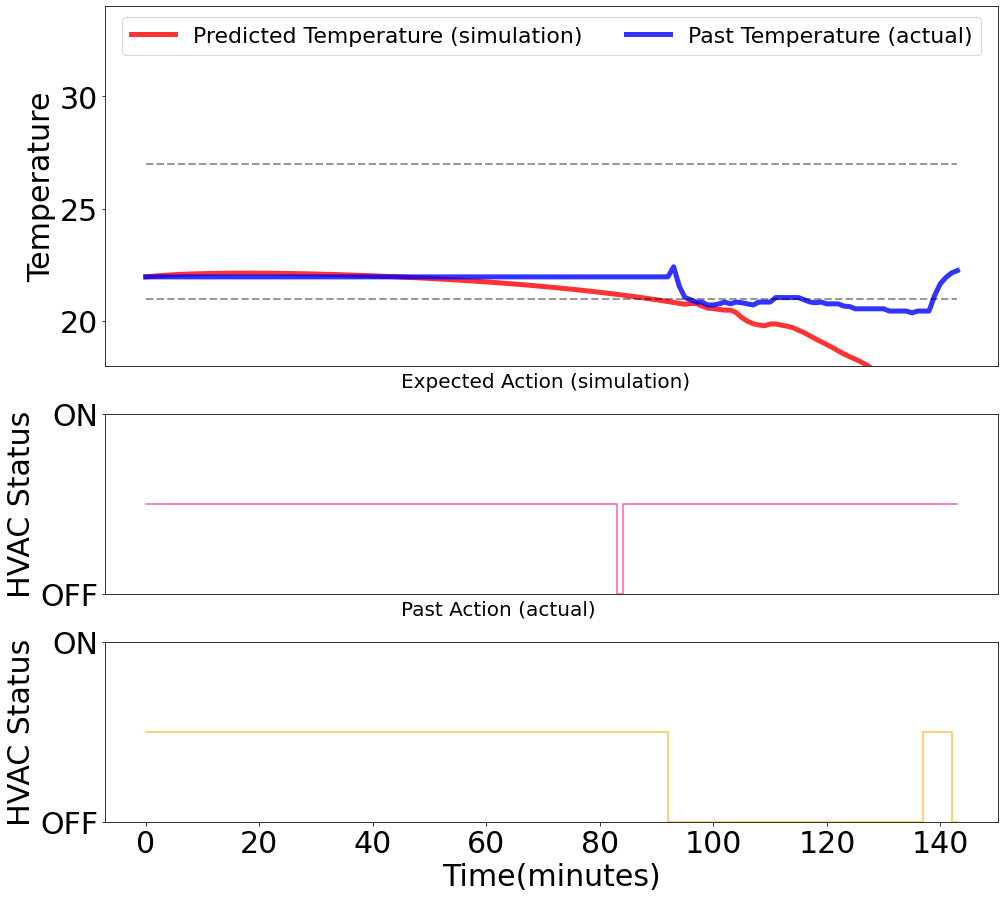

98.0
143
1 일 평균 절감율 :  -45.91836734693878 실제 평균 온도 :  21.58861111111112 학습 평균 온도 :  20.735822419252578 오차율 :  0.8527886918585423
/raid/deallab/ecm/model_result/2019-09-19/20190919w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.07
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-19 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  113 실제 평균 온도 :  20.312569444444435 학습 평균 온도 :  21.276248590652774


<Figure size 432x288 with 0 Axes>

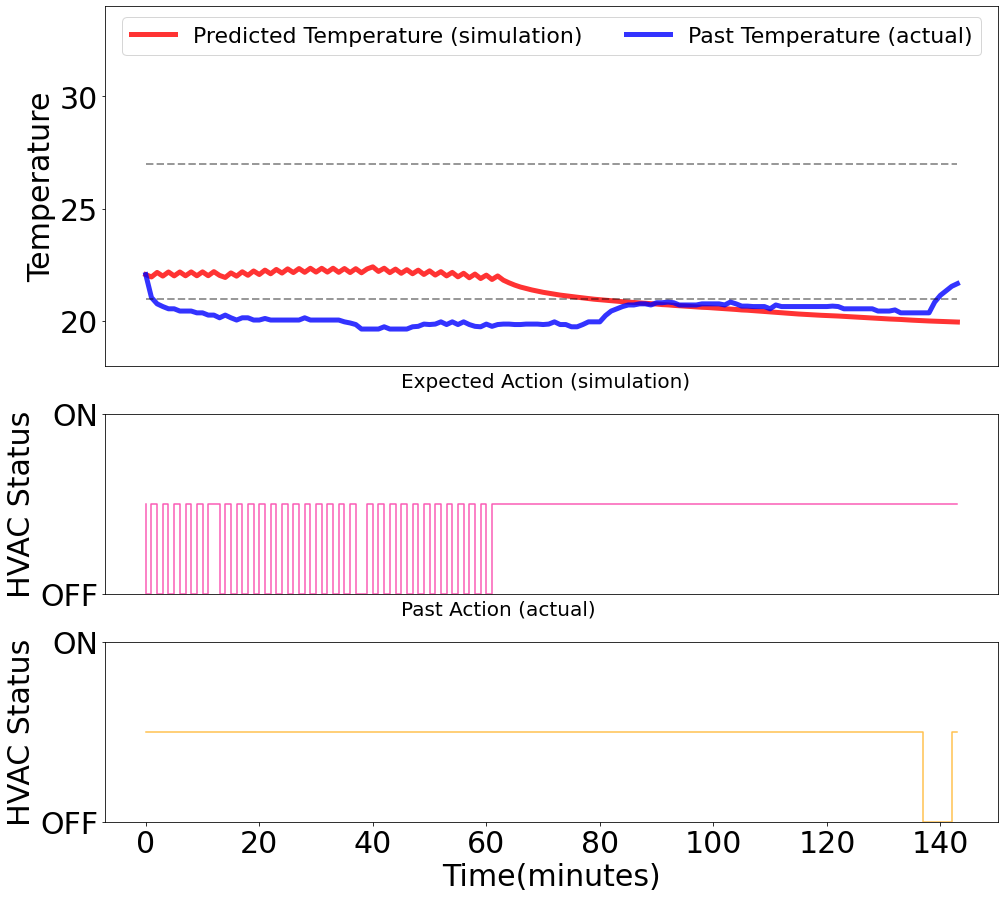

139.0
113
1 일 평균 절감율 :  18.705035971223023 실제 평균 온도 :  20.312569444444435 학습 평균 온도 :  21.276248590652774 오차율 :  -0.9636791462083387
/raid/deallab/ecm/model_result/2019-09-20/20190920w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.55
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-20 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  143 실제 평균 온도 :  20.338472222222222 학습 평균 온도 :  20.38775567811876


<Figure size 432x288 with 0 Axes>

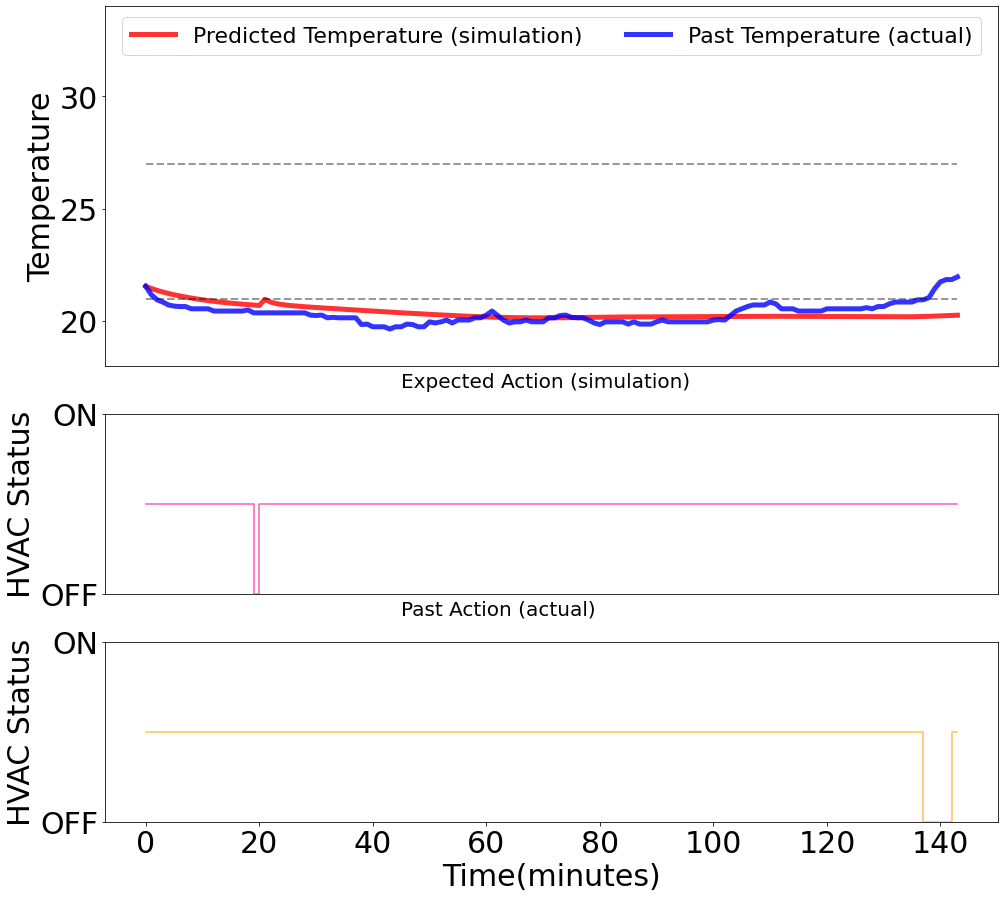

139.0
143
1 일 평균 절감율 :  -2.877697841726619 실제 평균 온도 :  20.338472222222222 학습 평균 온도 :  20.38775567811876 오차율 :  -0.04928345589653915
/raid/deallab/ecm/model_result/2019-09-21/20190921w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.85
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-21 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  21.357361111111096 학습 평균 온도 :  24.075434511222497


<Figure size 432x288 with 0 Axes>

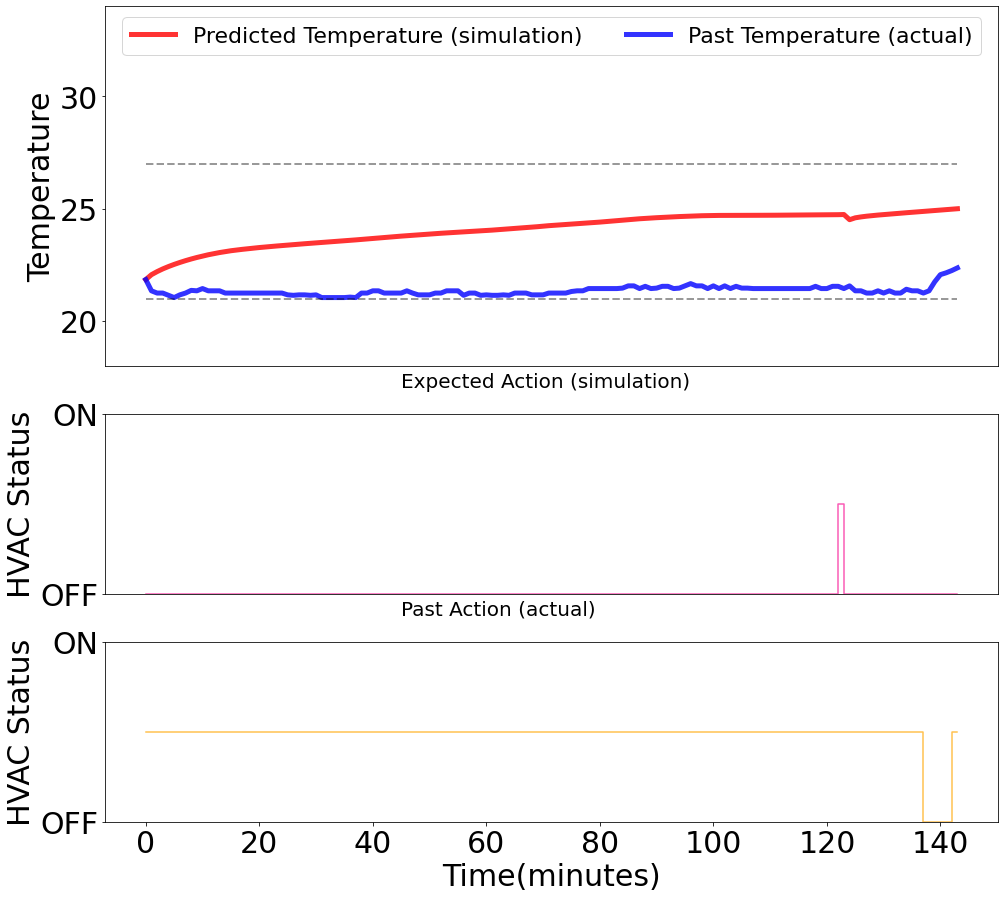

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  21.357361111111096 학습 평균 온도 :  24.075434511222497 오차율 :  -2.7180734001114004
/raid/deallab/ecm/model_result/2019-09-22/20190922w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.15
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-22 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  21.800625000000032 학습 평균 온도 :  24.908263006265646


<Figure size 432x288 with 0 Axes>

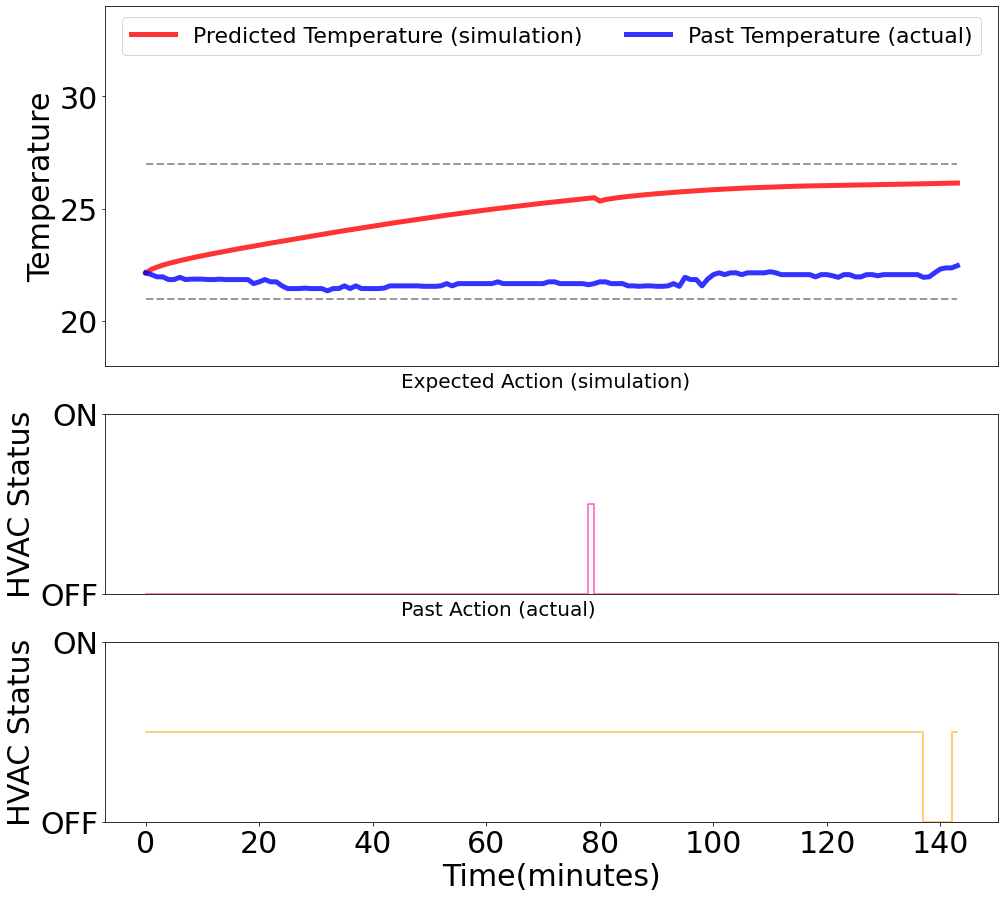

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  21.800625000000032 학습 평균 온도 :  24.908263006265646 오차율 :  -3.1076380062656135
/raid/deallab/ecm/model_result/2019-09-23/20190923w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.25
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-23 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  21.74673611111113 학습 평균 온도 :  23.932108586244812


<Figure size 432x288 with 0 Axes>

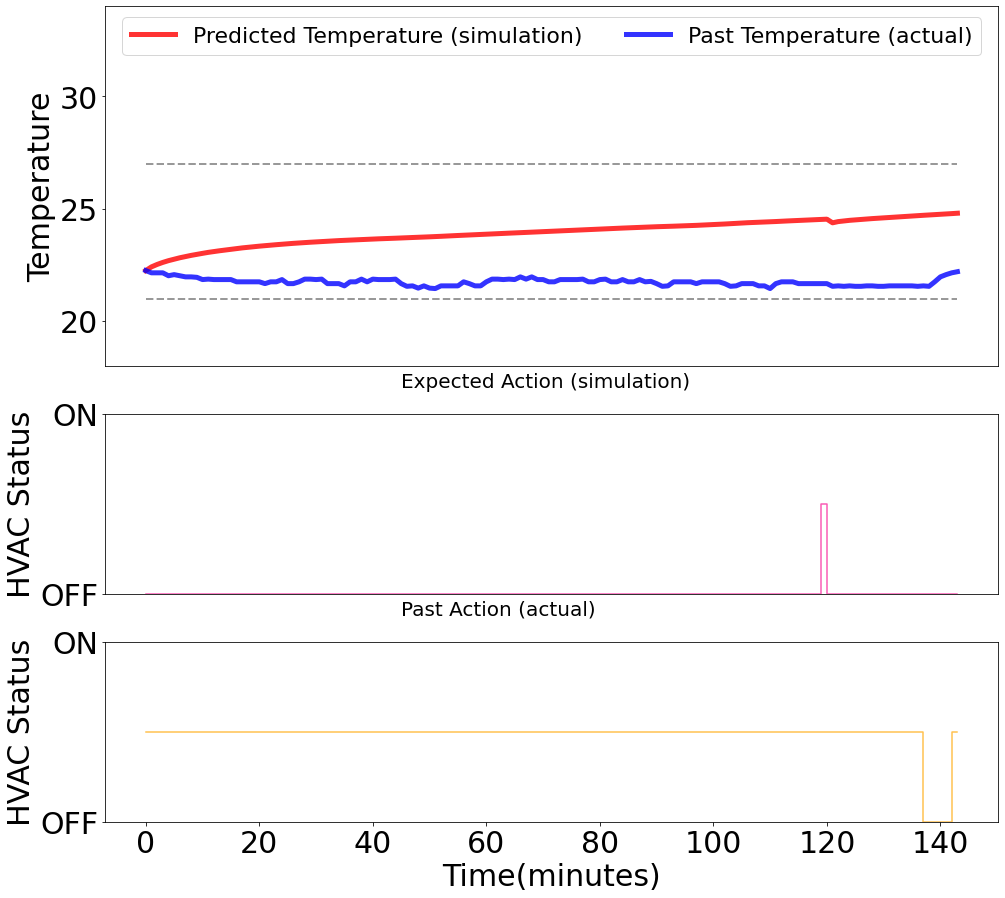

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  21.74673611111113 학습 평균 온도 :  23.932108586244812 오차율 :  -2.1853724751336827
/raid/deallab/ecm/model_result/2019-09-24/20190924w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.97
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0]
2019-09-24 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  62 실제 평균 온도 :  21.069166666666646 학습 평균 온도 :  22.43980514304664


<Figure size 432x288 with 0 Axes>

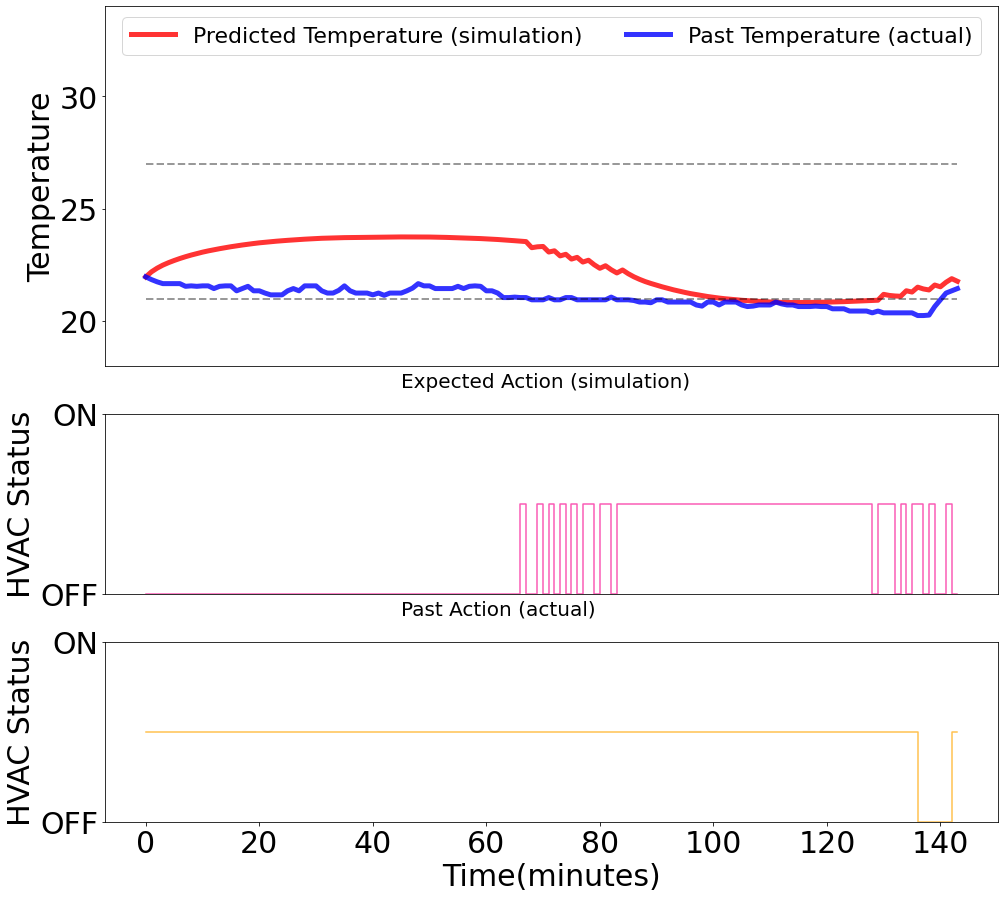

138.0
62
1 일 평균 절감율 :  55.072463768115945 실제 평균 온도 :  21.069166666666646 학습 평균 온도 :  22.43980514304664 오차율 :  -1.3706384763799946
/raid/deallab/ecm/model_result/2019-09-25/20190925w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.25
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-25 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  142 실제 평균 온도 :  19.939027777777756 학습 평균 온도 :  20.157988361856276


<Figure size 432x288 with 0 Axes>

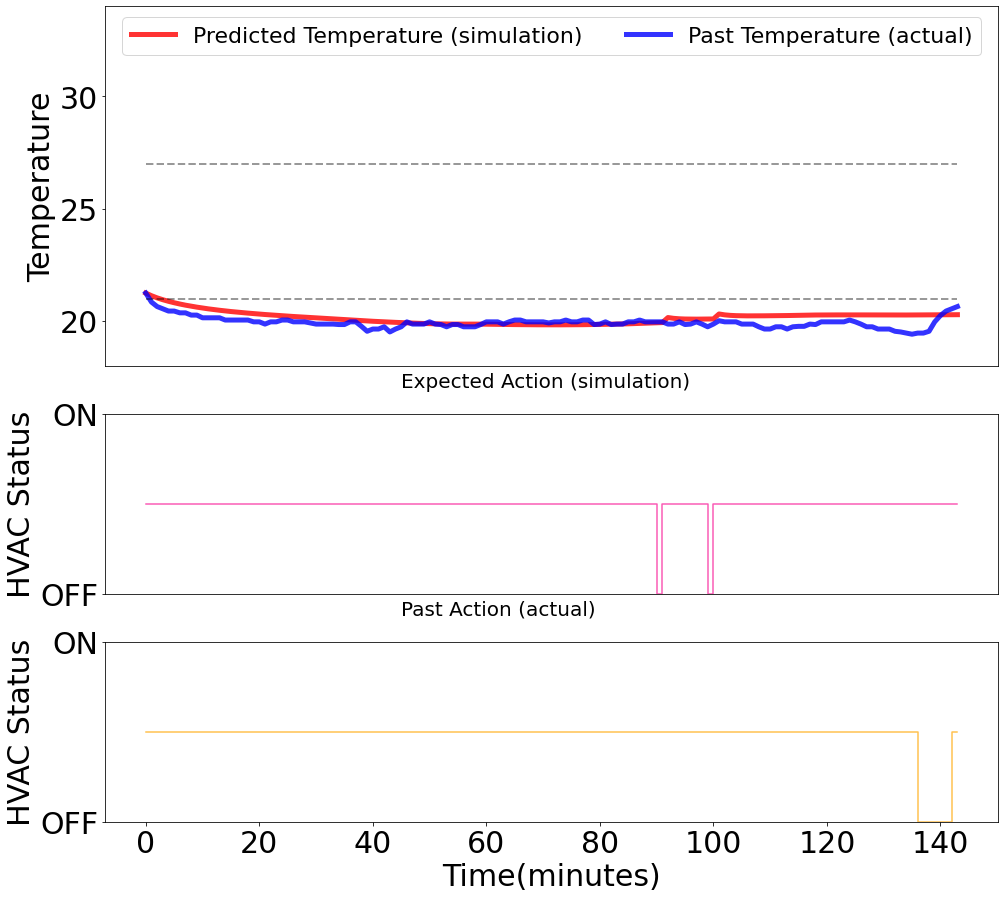

138.0
142
1 일 평균 절감율 :  -2.898550724637681 실제 평균 온도 :  19.939027777777756 학습 평균 온도 :  20.157988361856276 오차율 :  -0.21896058407851982
/raid/deallab/ecm/model_result/2019-09-26/20190926w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.45
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-26 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  57 실제 평균 온도 :  19.976111111111123 학습 평균 온도 :  22.368214806638054


<Figure size 432x288 with 0 Axes>

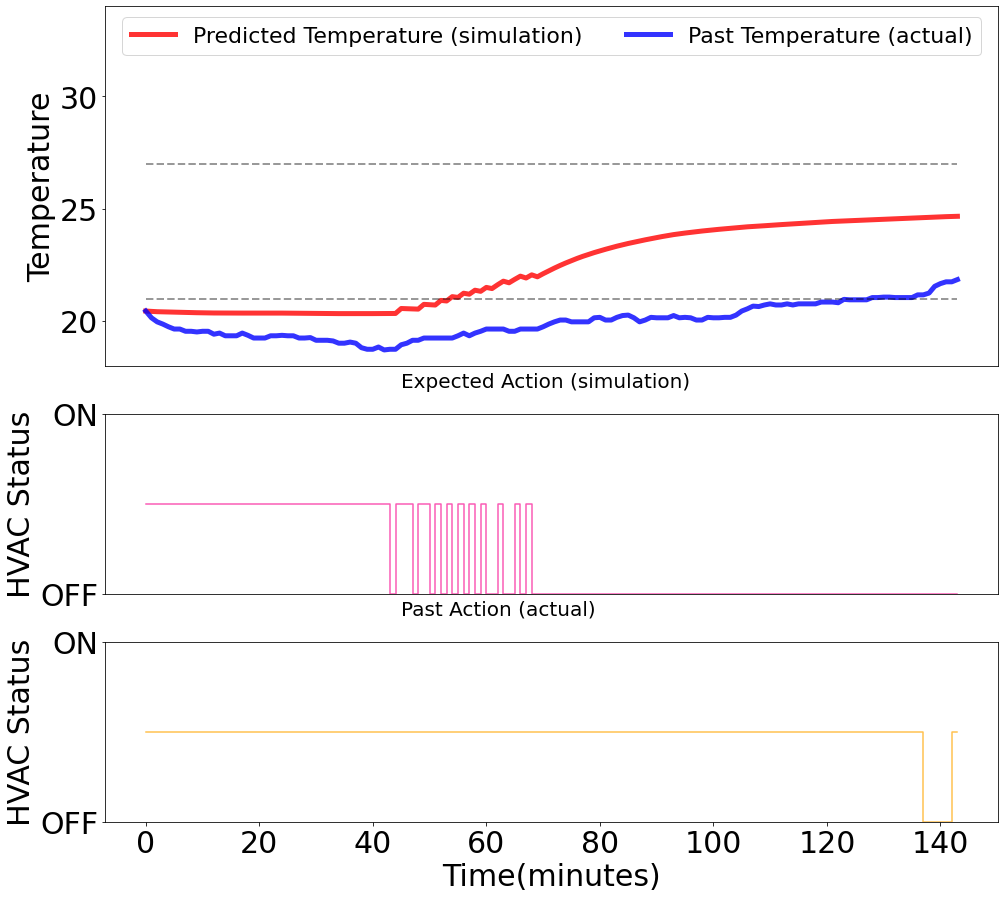

139.0
57
1 일 평균 절감율 :  58.992805755395686 실제 평균 온도 :  19.976111111111123 학습 평균 온도 :  22.368214806638054 오차율 :  -2.392103695526931
/raid/deallab/ecm/model_result/2019-09-27/20190927w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.67
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-27 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  0 실제 평균 온도 :  21.957916666666677 학습 평균 온도 :  25.479311146550895


<Figure size 432x288 with 0 Axes>

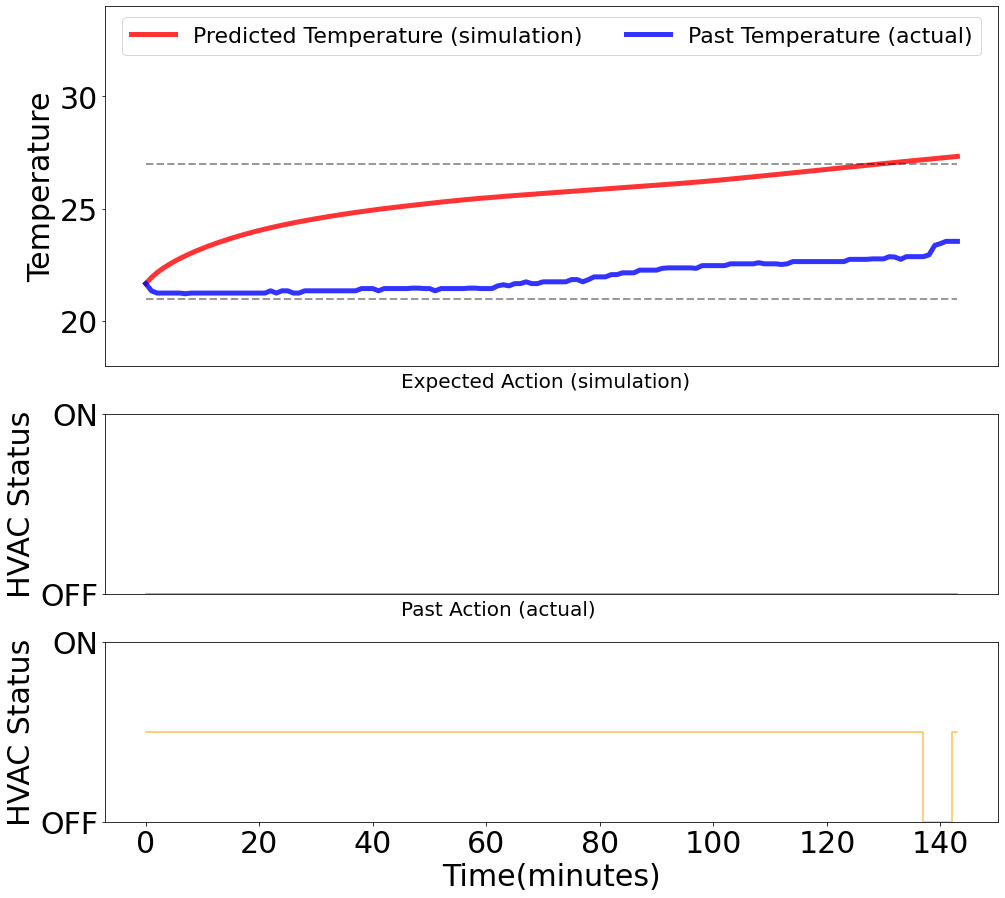

139.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  21.957916666666677 학습 평균 온도 :  25.479311146550895 오차율 :  -3.5213944798842185
/raid/deallab/ecm/model_result/2019-09-28/20190928w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-28 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  0 실제 평균 온도 :  23.78881944444445 학습 평균 온도 :  26.848415066873606


<Figure size 432x288 with 0 Axes>

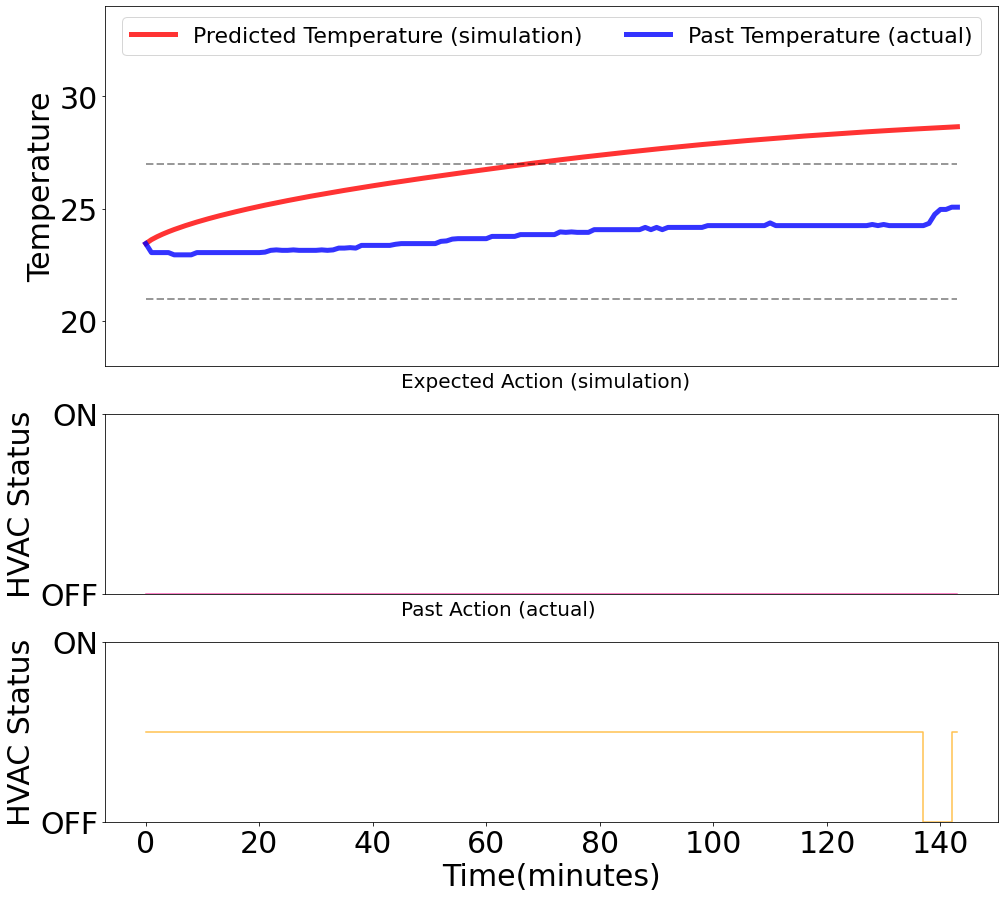

139.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  23.78881944444445 학습 평균 온도 :  26.848415066873606 오차율 :  -3.059595622429157
/raid/deallab/ecm/model_result/2019-09-29/20190929w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.87
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-29 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  24.81729166666667 학습 평균 온도 :  25.735110838980596


<Figure size 432x288 with 0 Axes>

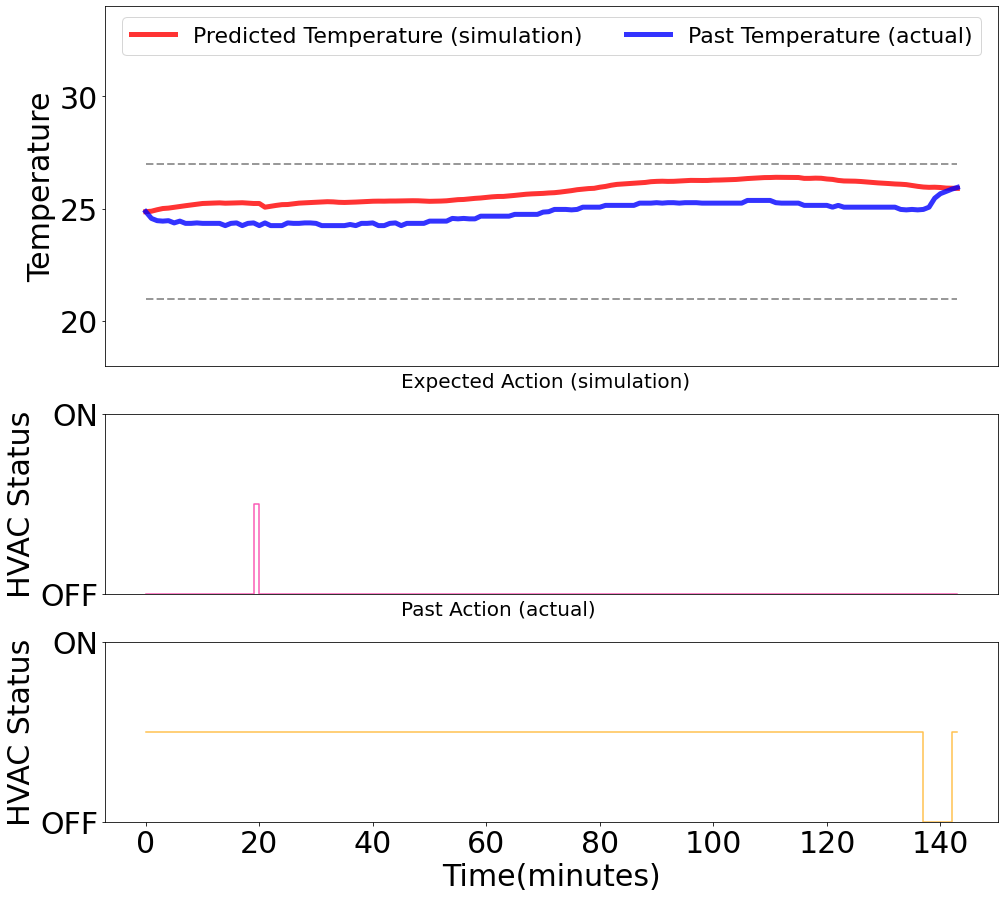

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  24.81729166666667 학습 평균 온도 :  25.735110838980596 오차율 :  -0.9178191723139264
/raid/deallab/ecm/model_result/2019-09-30/20190930w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.65
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-30 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  3 실제 평균 온도 :  24.941805555555547 학습 평균 온도 :  31.268506876143835


<Figure size 432x288 with 0 Axes>

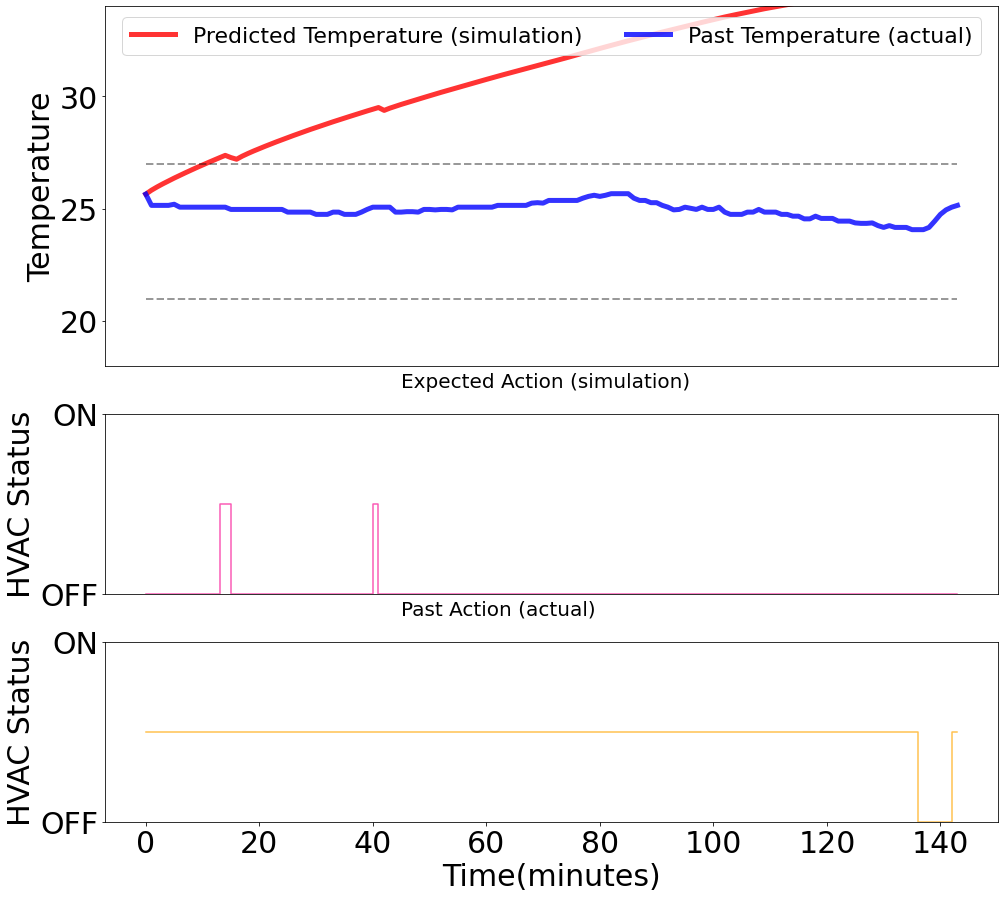

138.0
3
1 일 평균 절감율 :  97.82608695652173 실제 평균 온도 :  24.941805555555547 학습 평균 온도 :  31.268506876143835 오차율 :  -6.326701320588288
/raid/deallab/ecm/model_result/2019-10-01/20191001w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.97
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]
2019-10-01 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  67 실제 평균 온도 :  24.01958333333332 학습 평균 온도 :  25.444261121787093


<Figure size 432x288 with 0 Axes>

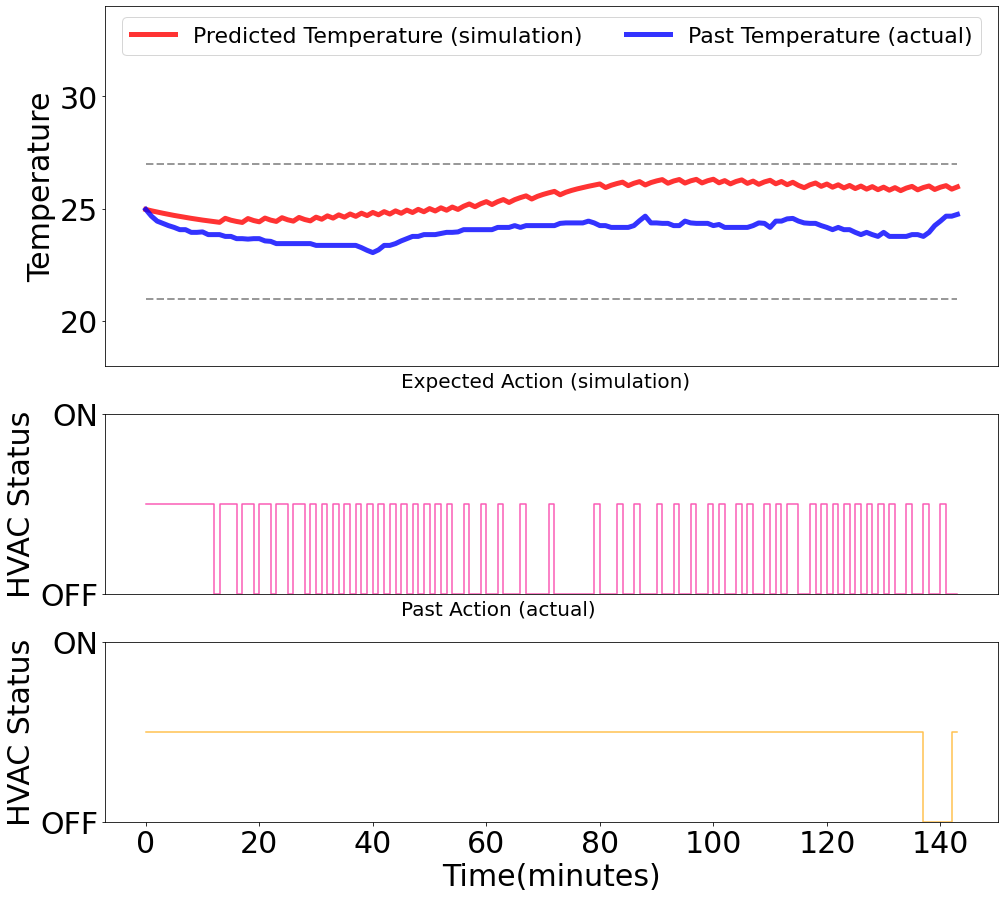

139.0
67
1 일 평균 절감율 :  51.798561151079134 실제 평균 온도 :  24.01958333333332 학습 평균 온도 :  25.444261121787093 오차율 :  -1.4246777884537742
/raid/deallab/ecm/model_result/2019-10-02/20191002w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-02 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  0 실제 평균 온도 :  24.525972222222197 학습 평균 온도 :  27.353102944647908


<Figure size 432x288 with 0 Axes>

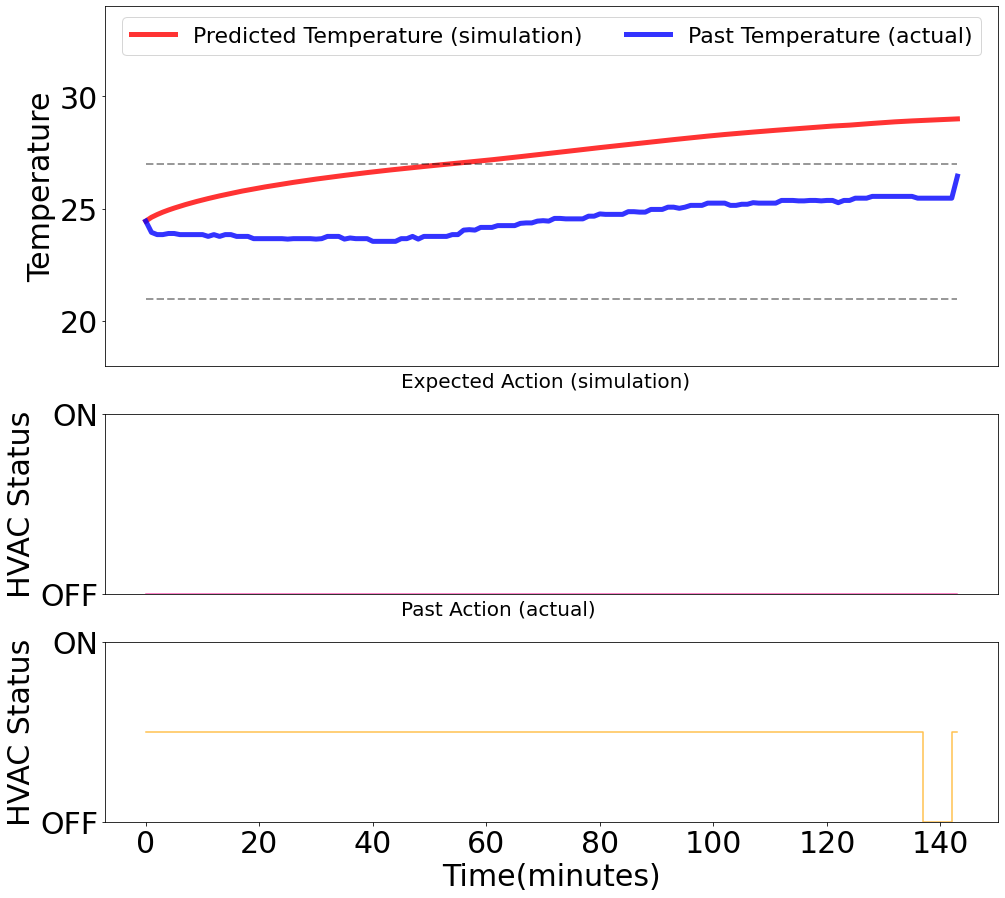

139.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  24.525972222222197 학습 평균 온도 :  27.353102944647908 오차율 :  -2.8271307224257107
/raid/deallab/ecm/model_result/2019-10-03/20191003w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
2019-10-03 실제 데이터 길이 :  144  : real action :  97.5 , expected action :  68 실제 평균 온도 :  25.42805555555554 학습 평균 온도 :  26.276136416120348


<Figure size 432x288 with 0 Axes>

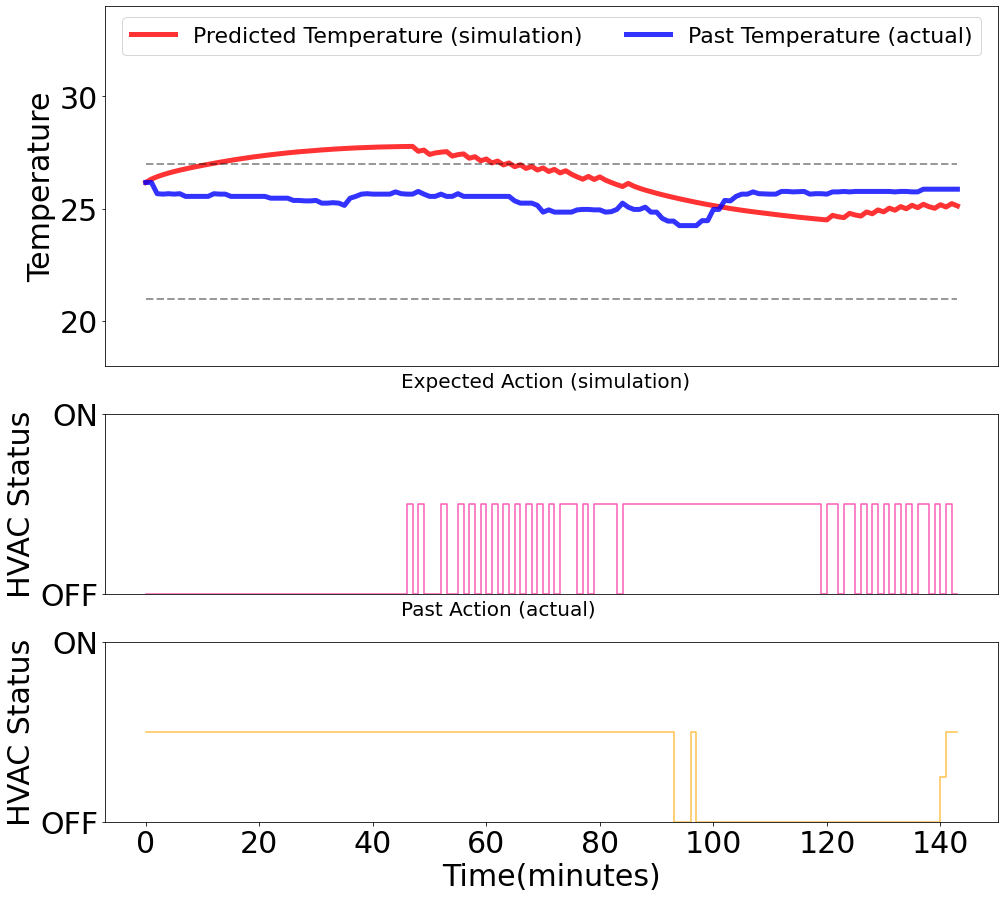

97.5
68
1 일 평균 절감율 :  30.256410256410255 실제 평균 온도 :  25.42805555555554 학습 평균 온도 :  26.276136416120348 오차율 :  -0.8480808605648065
/raid/deallab/ecm/model_result/2019-10-04/20191004w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.25
[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-10-04 실제 데이터 길이 :  144  : real action :  137.0 , expected action :  69 실제 평균 온도 :  23.413124999999994 학습 평균 온도 :  24.788987113599532


<Figure size 432x288 with 0 Axes>

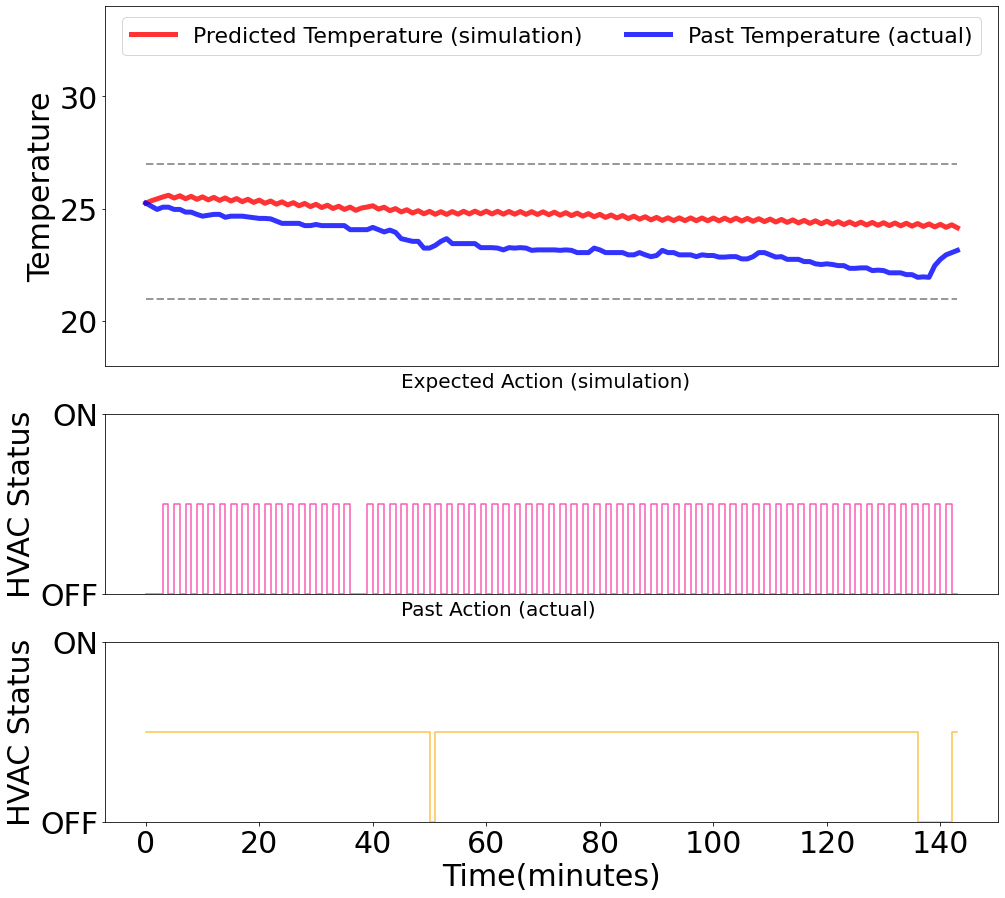

137.0
69
1 일 평균 절감율 :  49.63503649635037 실제 평균 온도 :  23.413124999999994 학습 평균 온도 :  24.788987113599532 오차율 :  -1.3758621135995384
/raid/deallab/ecm/model_result/2019-10-05/20191005w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.85
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-05 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  113 실제 평균 온도 :  21.53027777777776 학습 평균 온도 :  23.348419470528256


<Figure size 432x288 with 0 Axes>

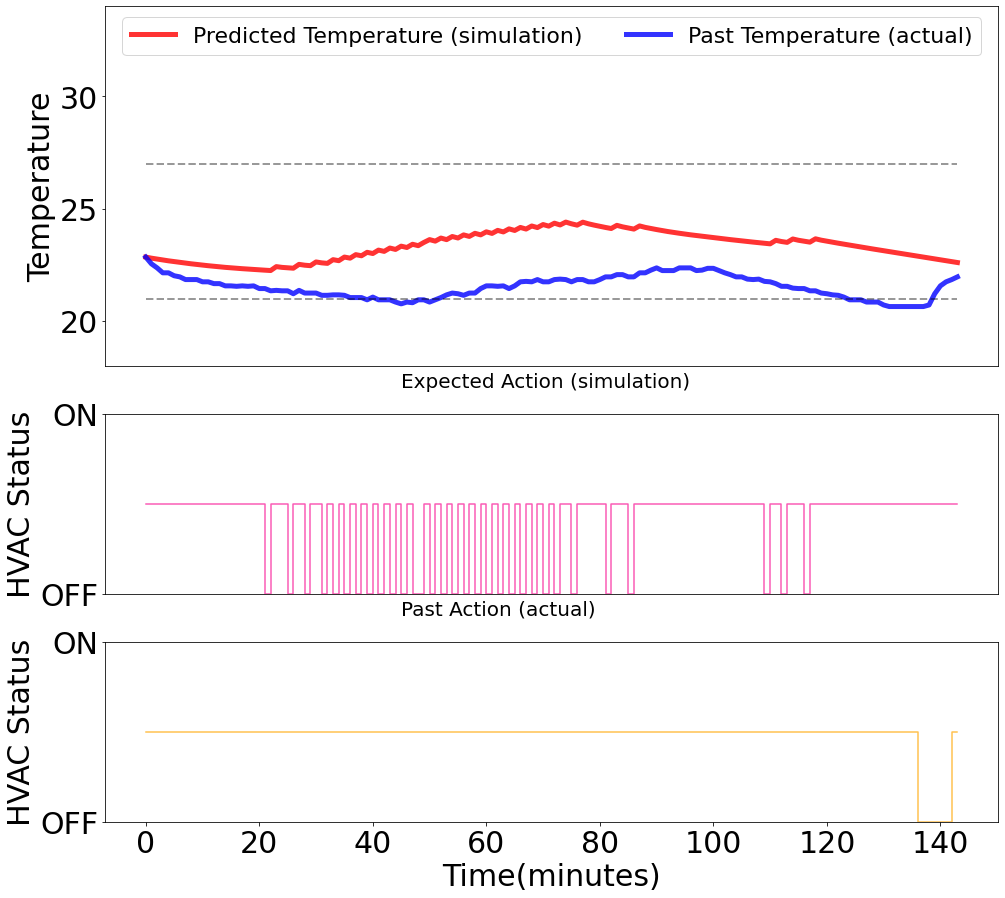

138.0
113
1 일 평균 절감율 :  18.115942028985508 실제 평균 온도 :  21.53027777777776 학습 평균 온도 :  23.348419470528256 오차율 :  -1.8181416927504976
/raid/deallab/ecm/model_result/2019-10-06/20191006w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.67
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-06 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  141 실제 평균 온도 :  19.38729166666664 학습 평균 온도 :  18.523355626372947


<Figure size 432x288 with 0 Axes>

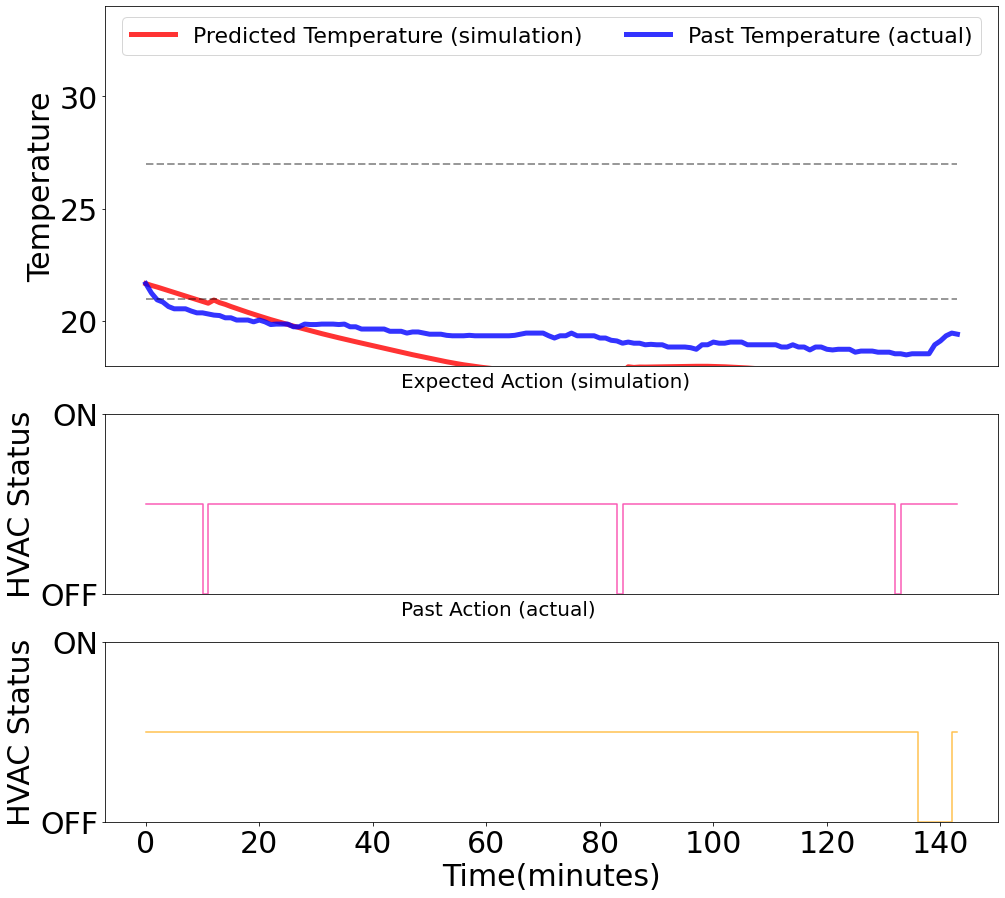

138.0
141
1 일 평균 절감율 :  -2.1739130434782608 실제 평균 온도 :  19.38729166666664 학습 평균 온도 :  18.523355626372947 오차율 :  0.8639360402936944
/raid/deallab/ecm/model_result/2019-10-07/20191007w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 19.25
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-07 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  117 실제 평균 온도 :  19.7011111111111 학습 평균 온도 :  19.772869545705408


<Figure size 432x288 with 0 Axes>

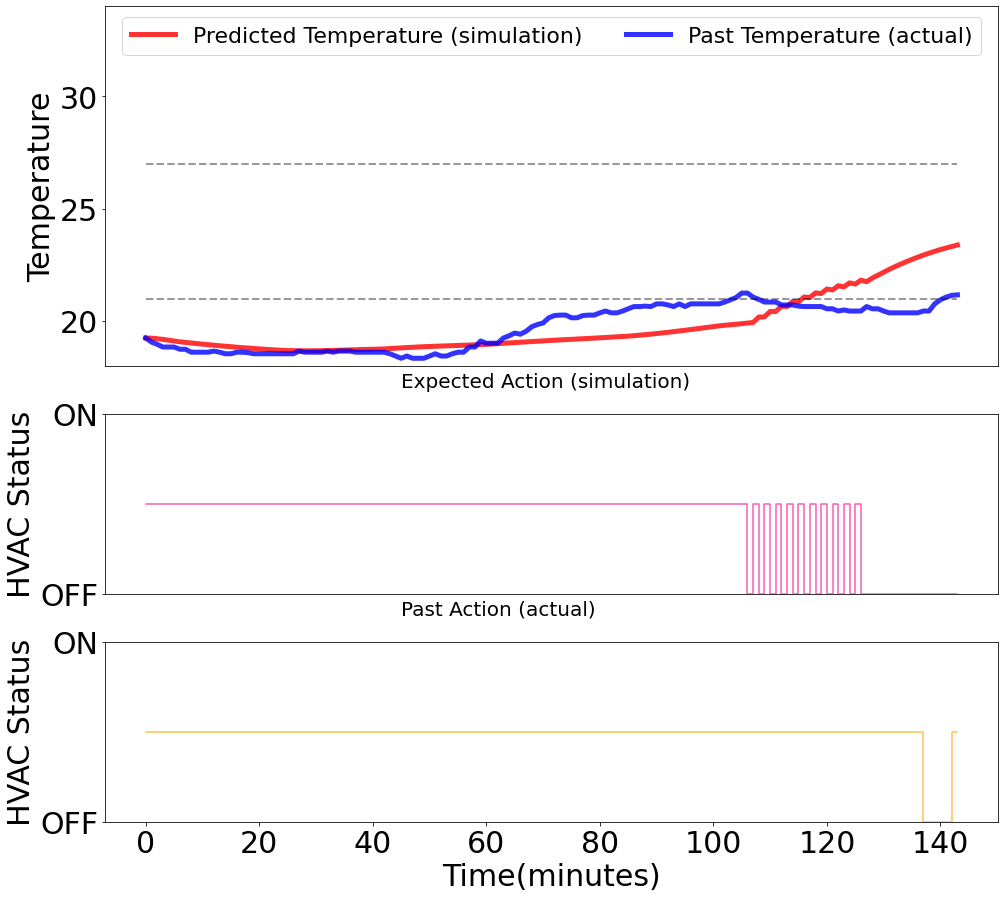

139.0
117
1 일 평균 절감율 :  15.827338129496402 실제 평균 온도 :  19.7011111111111 학습 평균 온도 :  19.772869545705408 오차율 :  -0.07175843459430808
/raid/deallab/ecm/model_result/2019-10-08/20191008w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.85
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-08 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  75 실제 평균 온도 :  20.987222222222215 학습 평균 온도 :  21.887735445136716


<Figure size 432x288 with 0 Axes>

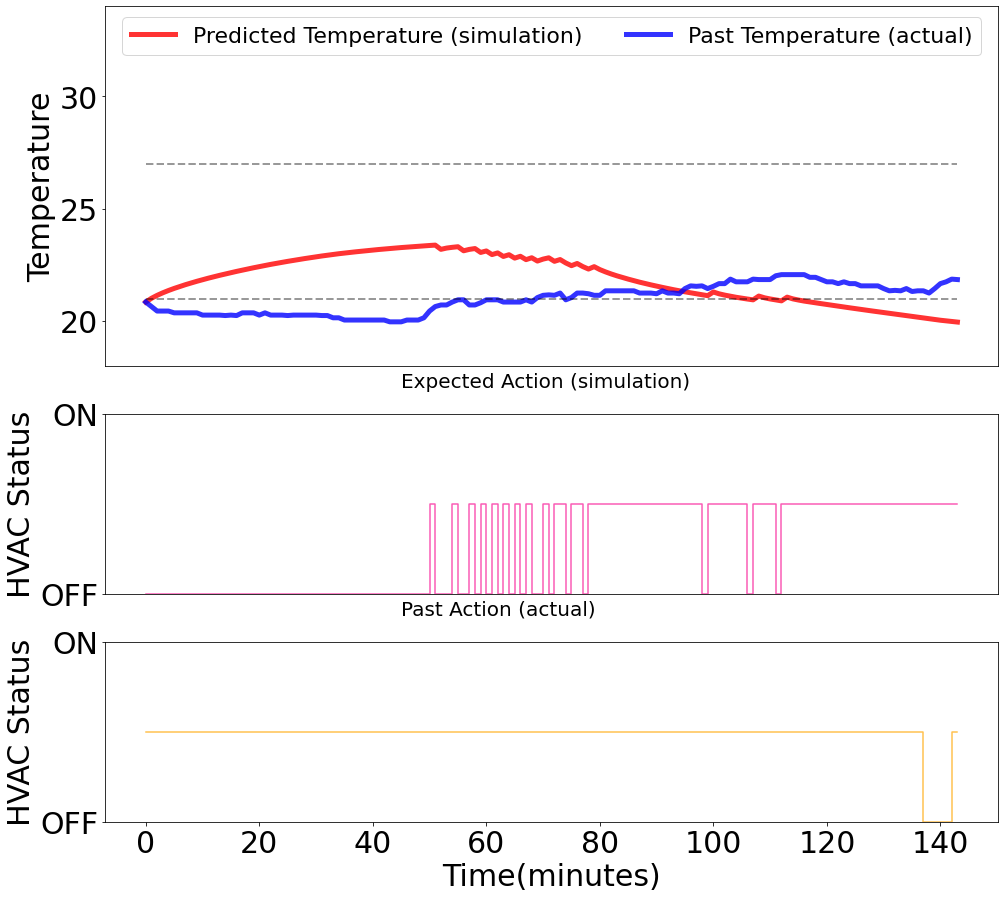

139.0
75
1 일 평균 절감율 :  46.043165467625904 실제 평균 온도 :  20.987222222222215 학습 평균 온도 :  21.887735445136716 오차율 :  -0.9005132229145012
/raid/deallab/ecm/model_result/2019-10-09/20191009w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.55
[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-09 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  18 실제 평균 온도 :  20.557152777777784 학습 평균 온도 :  22.285293610233744


<Figure size 432x288 with 0 Axes>

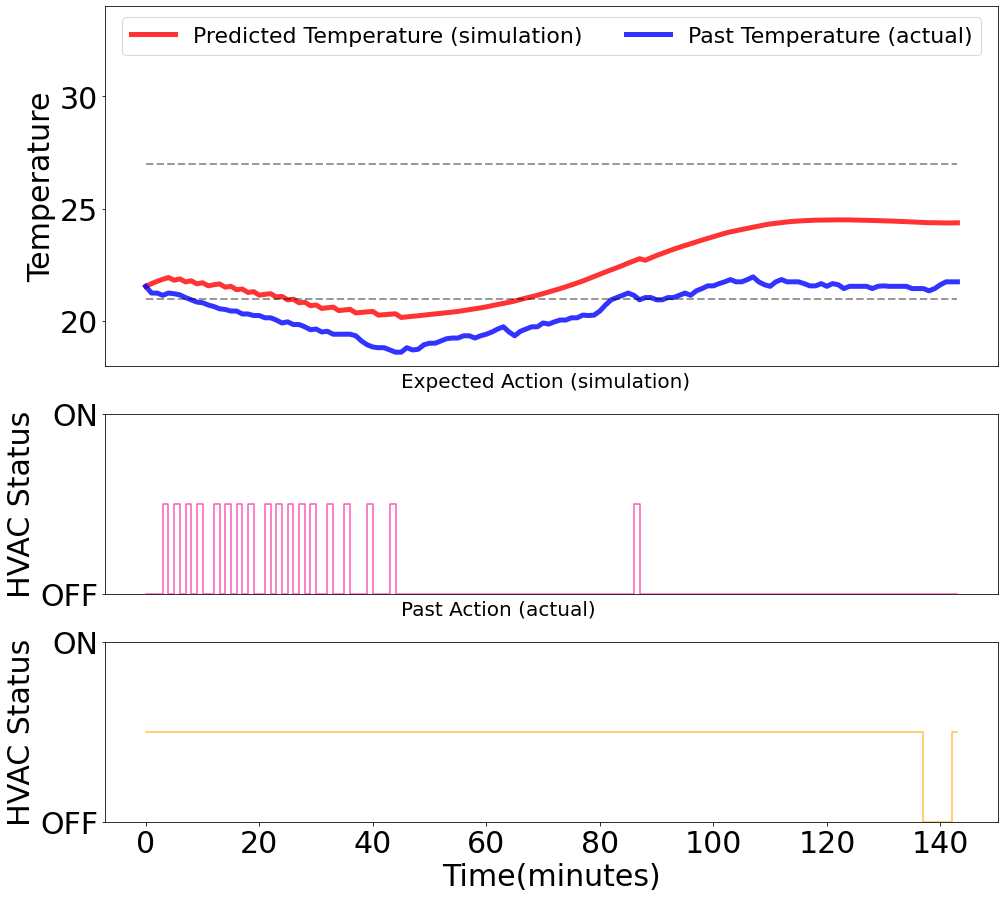

139.0
18
1 일 평균 절감율 :  87.05035971223022 실제 평균 온도 :  20.557152777777784 학습 평균 온도 :  22.285293610233744 오차율 :  -1.72814083245596
/raid/deallab/ecm/model_result/2019-10-10/20191010w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.32
[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-10 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  8 실제 평균 온도 :  21.28416666666667 학습 평균 온도 :  25.107765654556616


<Figure size 432x288 with 0 Axes>

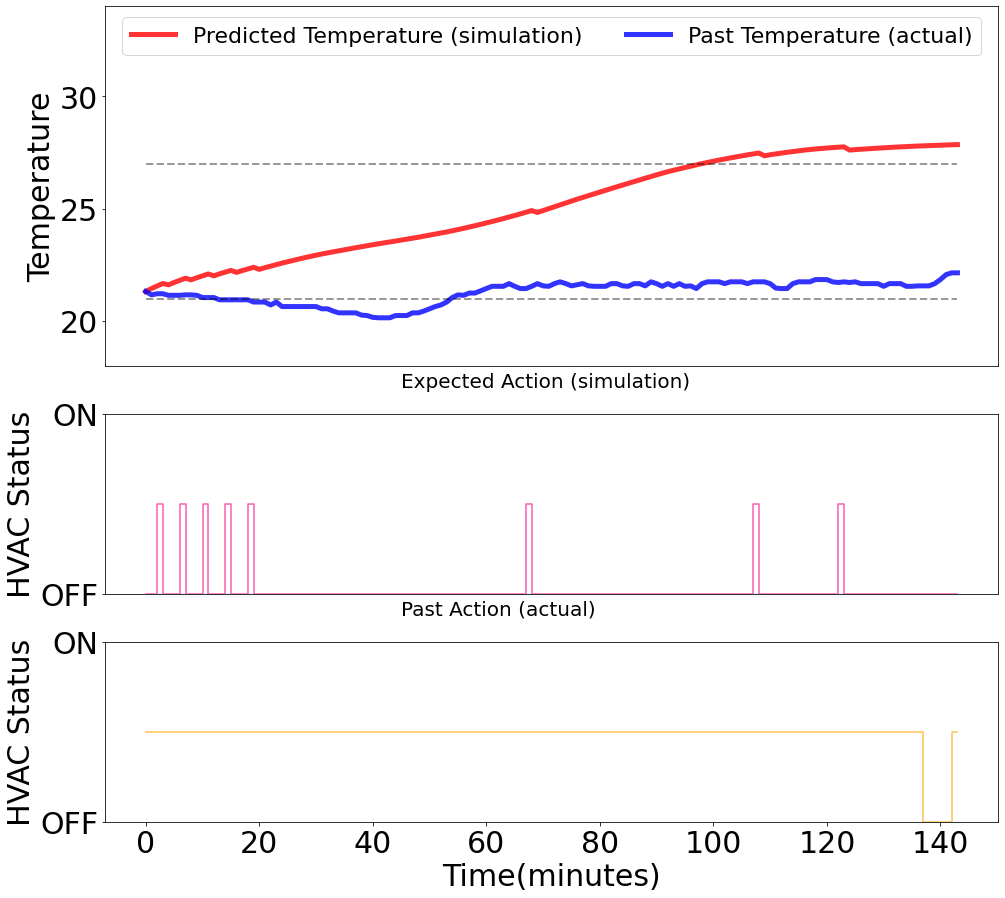

139.0
8
1 일 평균 절감율 :  94.24460431654677 실제 평균 온도 :  21.28416666666667 학습 평균 온도 :  25.107765654556616 오차율 :  -3.8235989878899446
/raid/deallab/ecm/model_result/2019-10-11/20191011w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.85
[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
2019-10-11 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  57 실제 평균 온도 :  21.629513888888866 학습 평균 온도 :  23.01756294197048


<Figure size 432x288 with 0 Axes>

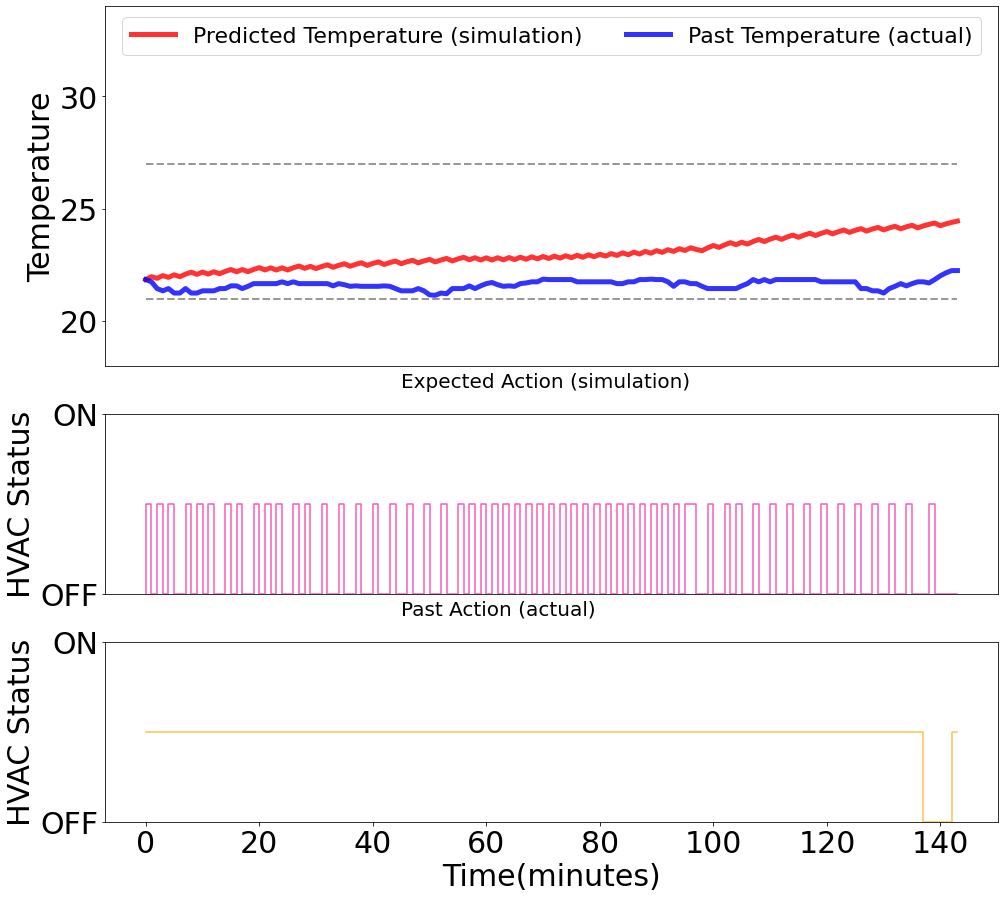

139.0
57
1 일 평균 절감율 :  58.992805755395686 실제 평균 온도 :  21.629513888888866 학습 평균 온도 :  23.01756294197048 오차율 :  -1.3880490530816125
/raid/deallab/ecm/model_result/2019-10-12/20191012w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.07
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
2019-10-12 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  66 실제 평균 온도 :  21.715694444444427 학습 평균 온도 :  23.49195704205825


<Figure size 432x288 with 0 Axes>

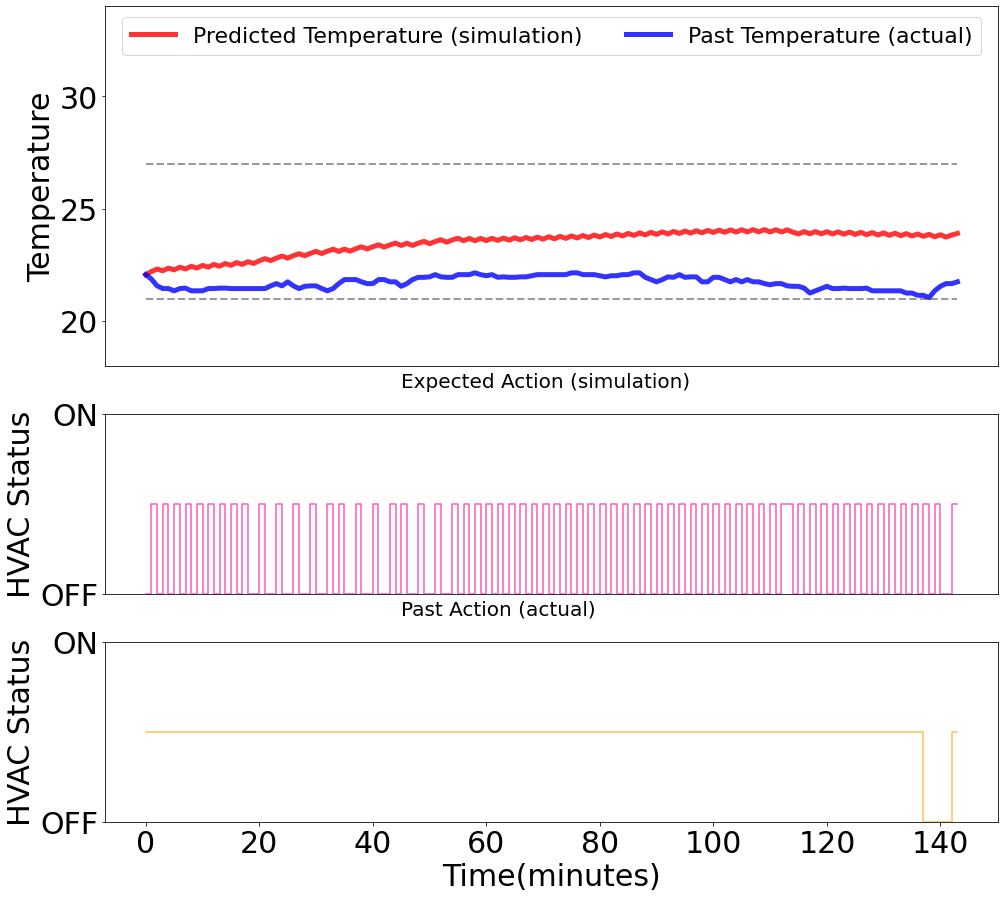

139.0
66
1 일 평균 절감율 :  52.51798561151079 실제 평균 온도 :  21.715694444444427 학습 평균 온도 :  23.49195704205825 오차율 :  -1.7762625976138224
/raid/deallab/ecm/model_result/2019-10-13/20191013w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.45
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-13 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  2 실제 평균 온도 :  20.33749999999999 학습 평균 온도 :  24.451270310823656


<Figure size 432x288 with 0 Axes>

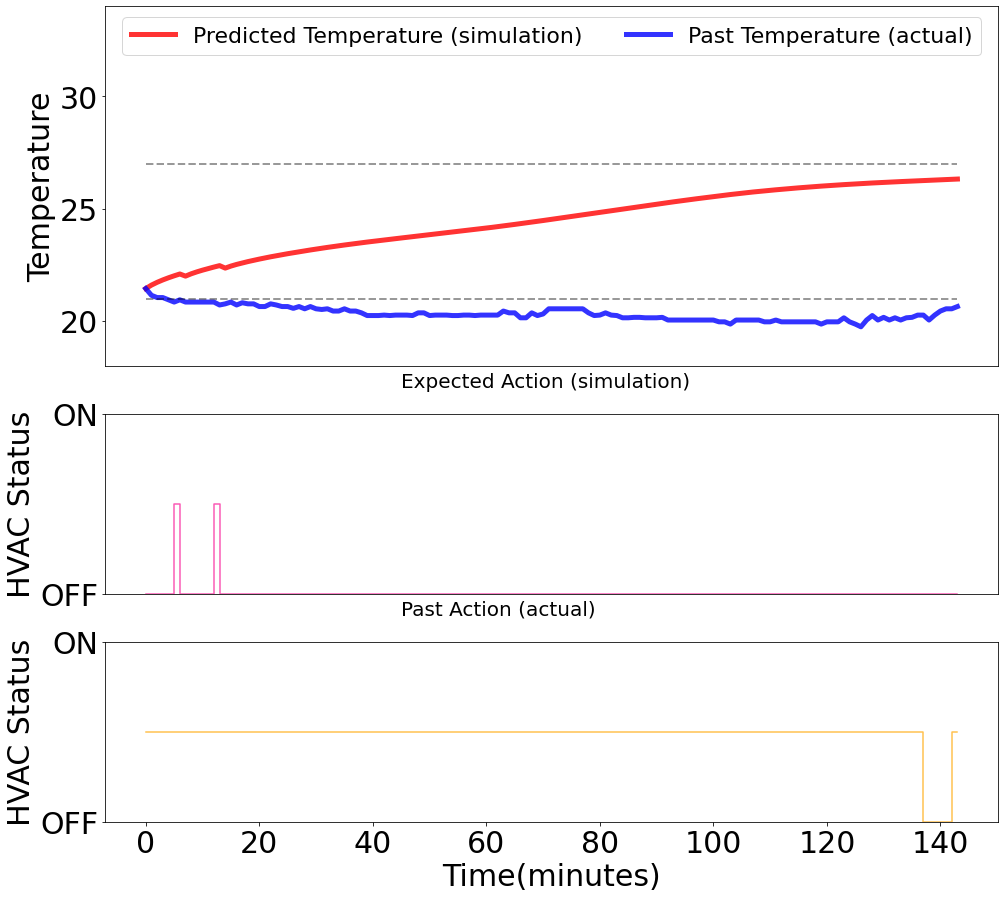

139.0
2
1 일 평균 절감율 :  98.56115107913669 실제 평균 온도 :  20.33749999999999 학습 평균 온도 :  24.451270310823656 오차율 :  -4.113770310823664
/raid/deallab/ecm/model_result/2019-10-14/20191014w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.37
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-14 실제 데이터 길이 :  144  : real action :  68.0 , expected action :  62 실제 평균 온도 :  21.350902777777772 학습 평균 온도 :  21.432404008742814


<Figure size 432x288 with 0 Axes>

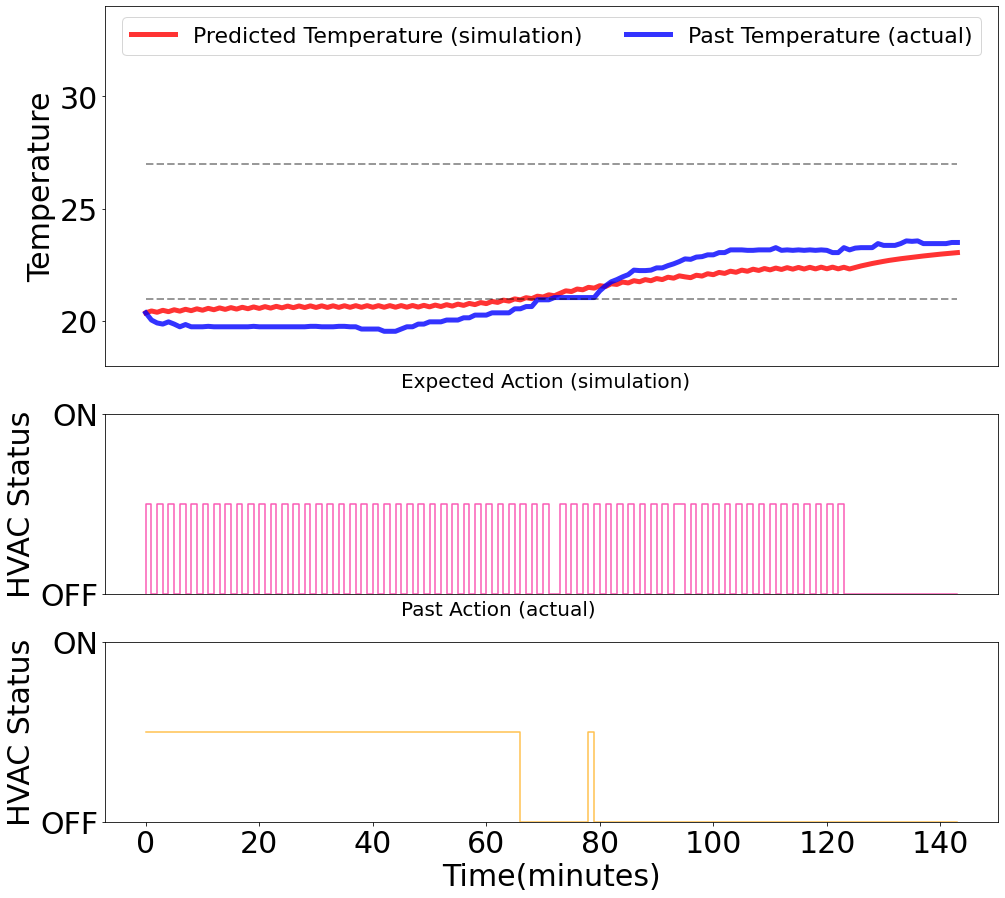

68.0
62
1 일 평균 절감율 :  8.823529411764707 실제 평균 온도 :  21.350902777777772 학습 평균 온도 :  21.432404008742814 오차율 :  -0.08150123096504203
/raid/deallab/ecm/model_result/2019-10-15/20191015w14_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 23.45
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-15 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  144 실제 평균 온도 :  22.925277777777783 학습 평균 온도 :  21.776548318880554


<Figure size 432x288 with 0 Axes>

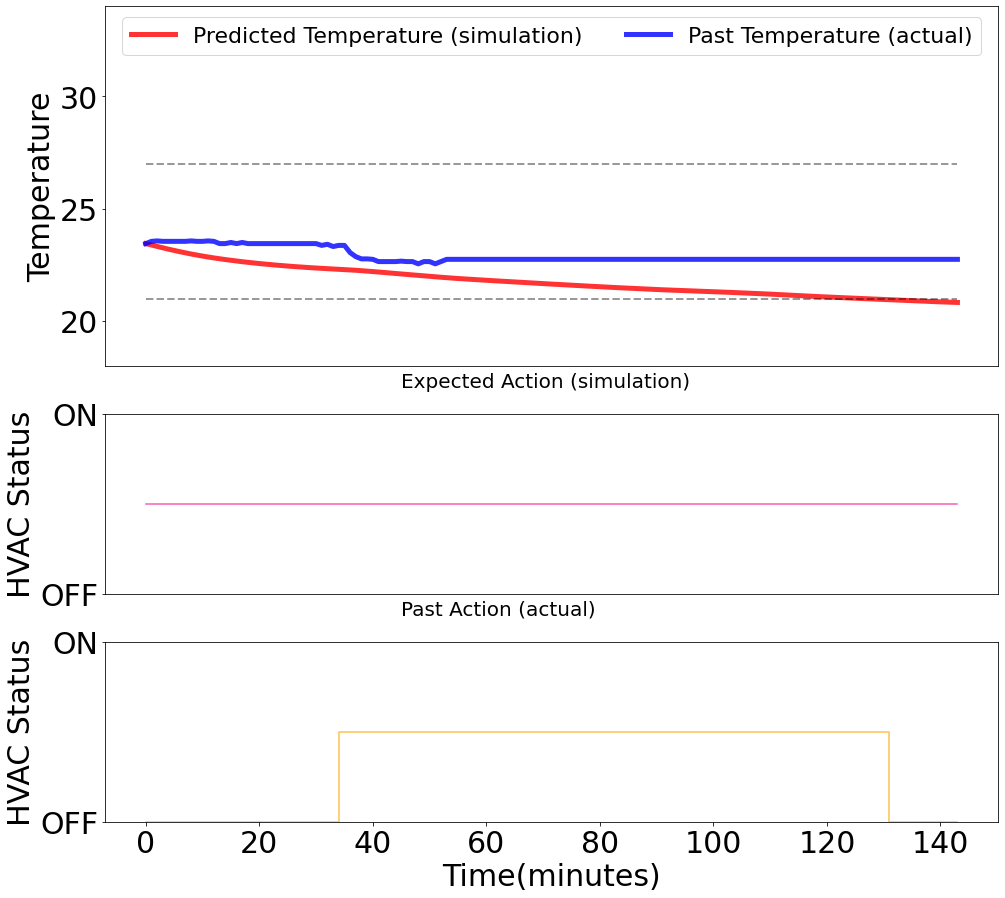

97.0
144
1 일 평균 절감율 :  -48.45360824742268 실제 평균 온도 :  22.925277777777783 학습 평균 온도 :  21.776548318880554 오차율 :  1.148729458897229
/raid/deallab/ecm/model_result/2019-10-16/20191016w30_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 22.75
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
2019-10-16 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  120 실제 평균 온도 :  23.85097222222219 학습 평균 온도 :  22.54043857096409


<Figure size 432x288 with 0 Axes>

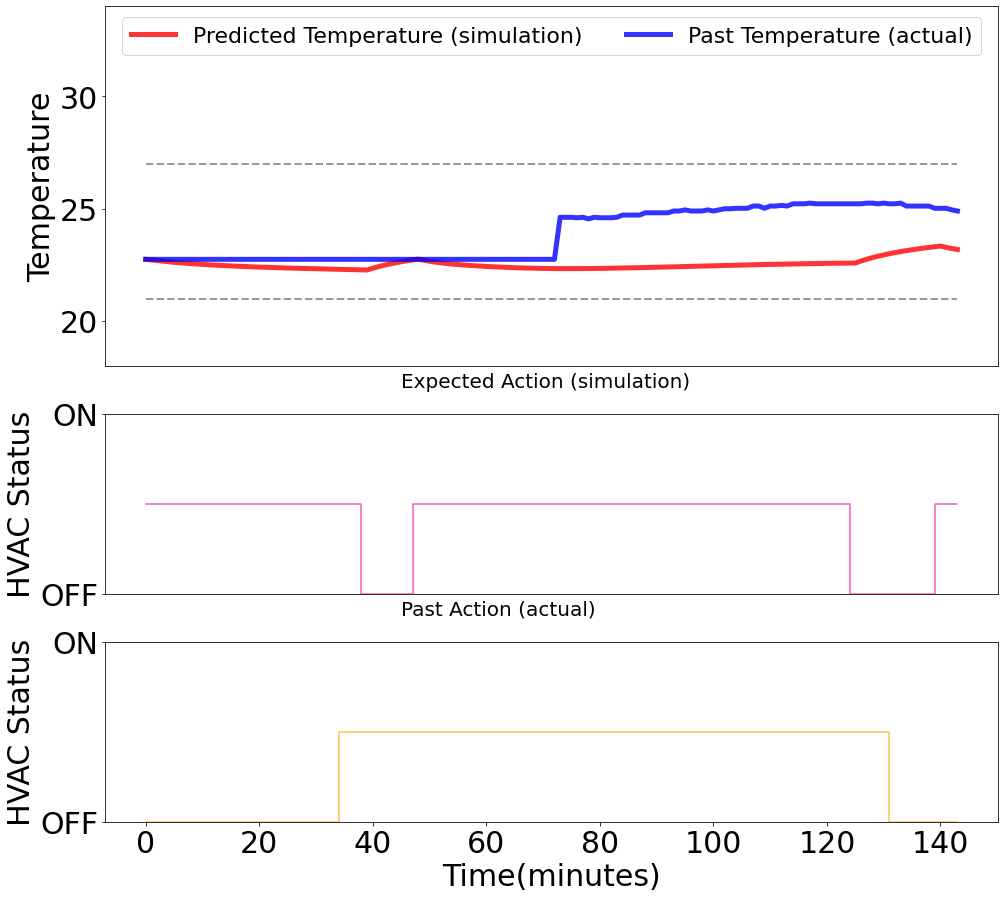

97.0
120
1 일 평균 절감율 :  -23.711340206185564 실제 평균 온도 :  23.85097222222219 학습 평균 온도 :  22.54043857096409 오차율 :  1.3105336512581012
/raid/deallab/ecm/model_result/2019-10-17/20191017w7_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 24.95
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-10-17 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  71 실제 평균 온도 :  25.320625000000017 학습 평균 온도 :  24.226786650802158


<Figure size 432x288 with 0 Axes>

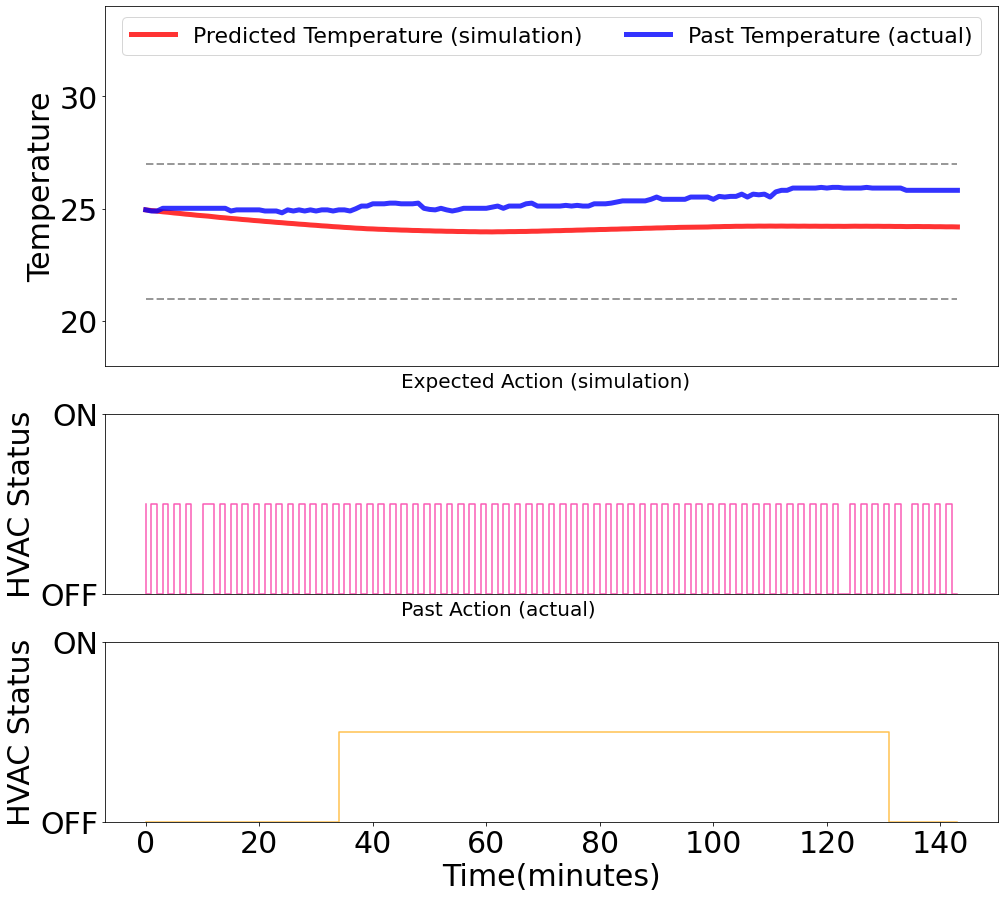

97.0
71
1 일 평균 절감율 :  26.804123711340207 실제 평균 온도 :  25.320625000000017 학습 평균 온도 :  24.226786650802158 오차율 :  1.0938383491978598
/raid/deallab/ecm/model_result/2019-10-18/20191018w30_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 25.82
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
2019-10-18 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  21 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.57549675073826


<Figure size 432x288 with 0 Axes>

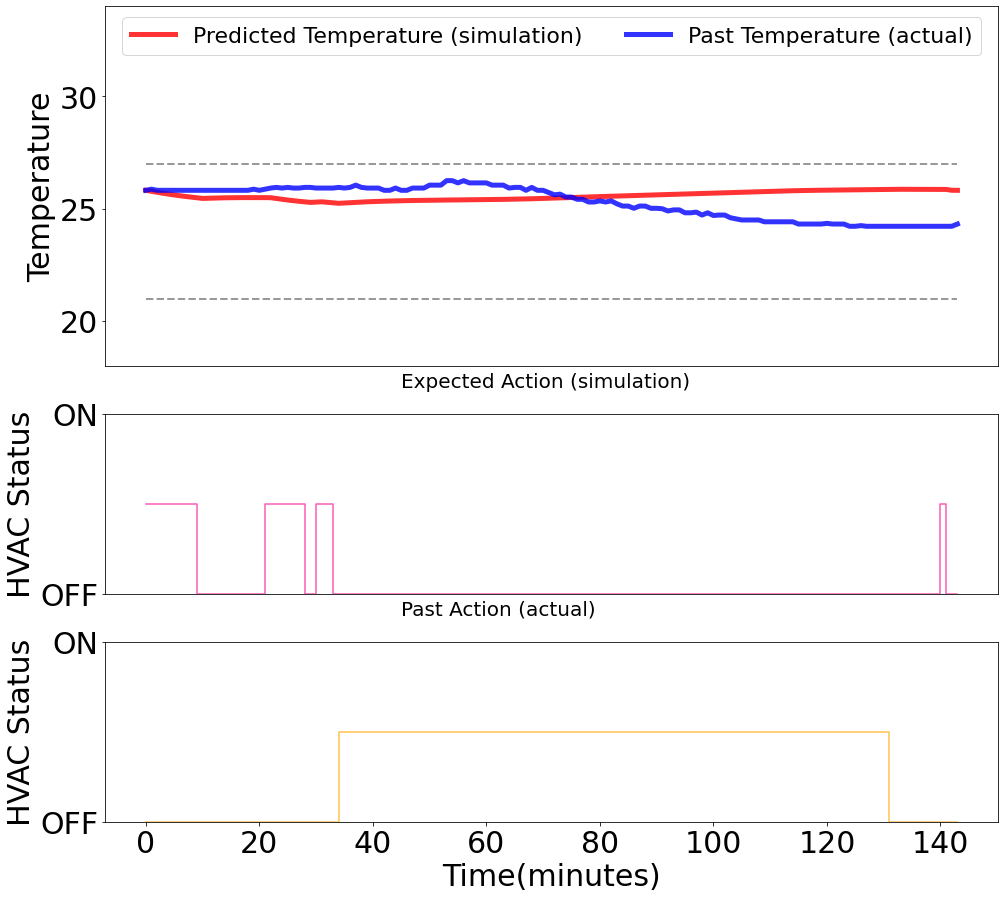

97.0
21
1 일 평균 절감율 :  78.35051546391753 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.57549675073826 오차율 :  -0.28223286184939056
/raid/deallab/ecm/model_result/2019-10-19/20191019w7_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 24.35
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-19 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  4 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.17693808767405


<Figure size 432x288 with 0 Axes>

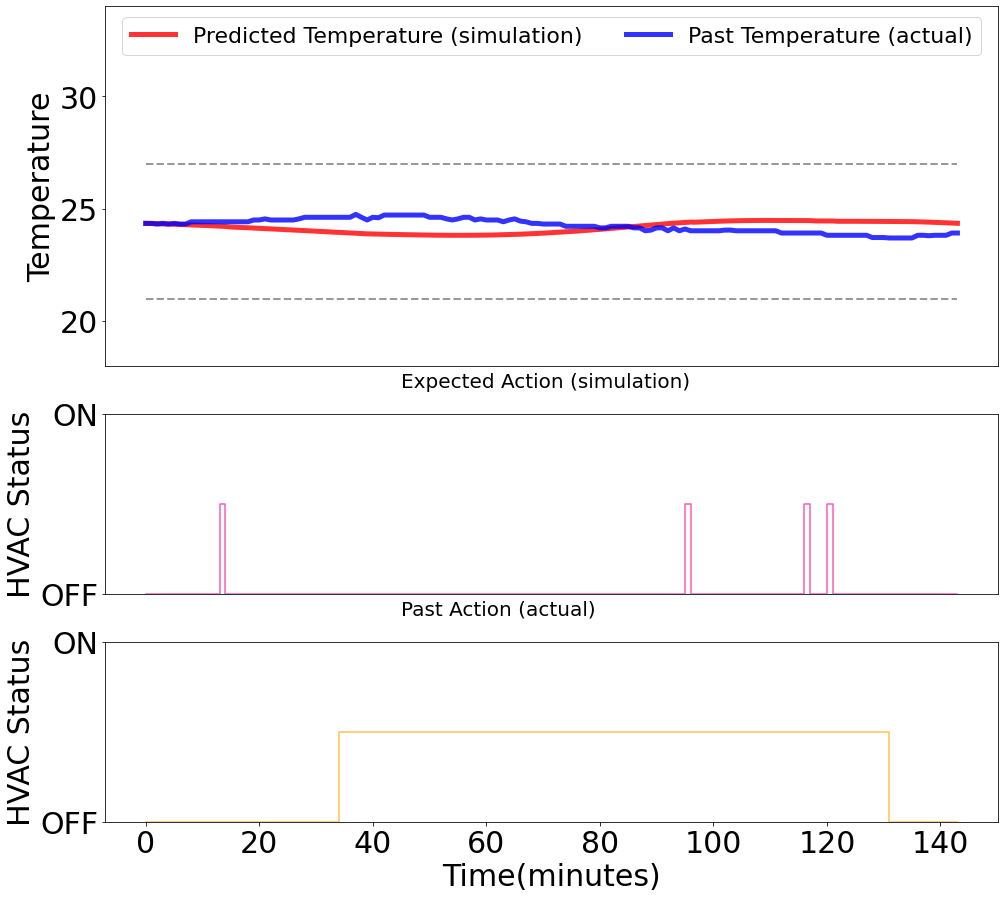

97.0
4
1 일 평균 절감율 :  95.87628865979381 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.17693808767405 오차율 :  0.07347857899262777
/raid/deallab/ecm/model_result/2019-10-20/20191020w1_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 23.92
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
2019-10-20 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  39 실제 평균 온도 :  24.05208333333334 학습 평균 온도 :  24.609068946890897


<Figure size 432x288 with 0 Axes>

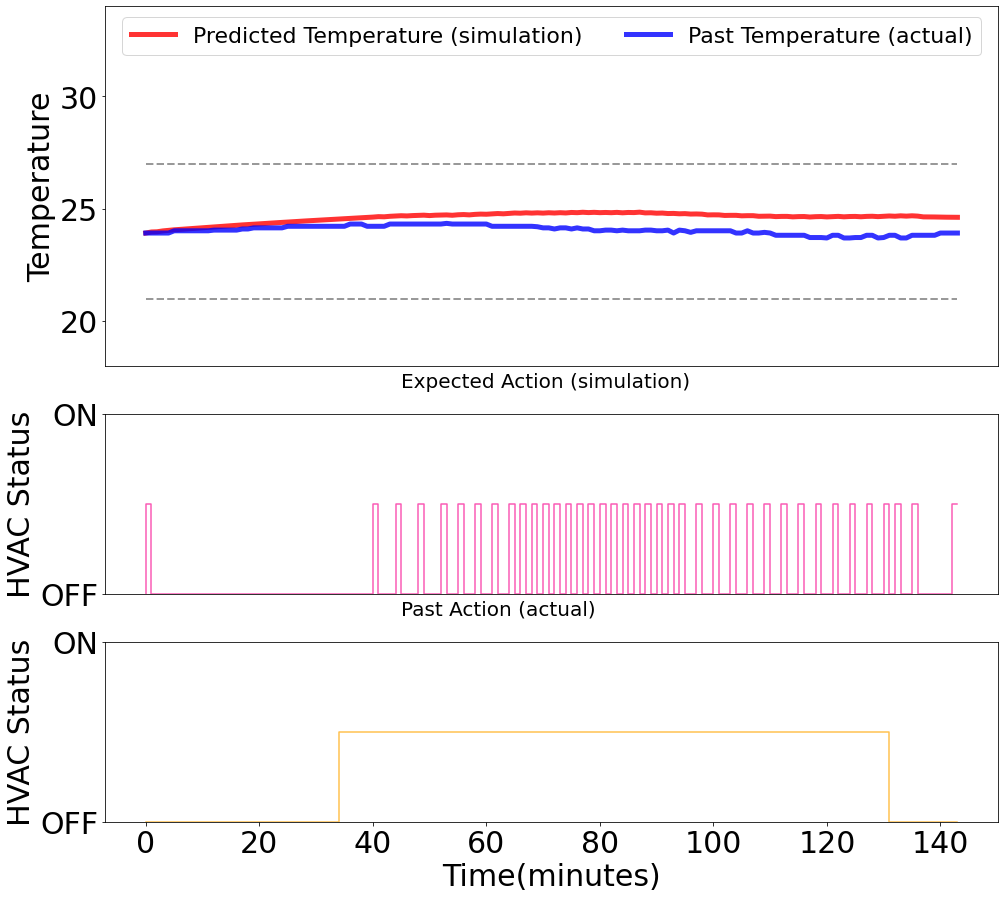

97.0
39
1 일 평균 절감율 :  59.79381443298969 실제 평균 온도 :  24.05208333333334 학습 평균 온도 :  24.609068946890897 오차율 :  -0.5569856135575577
/raid/deallab/ecm/model_result/2019-10-21/20191021w14_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.92
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-21 실제 데이터 길이 :  144  : real action :  53.0 , expected action :  53 실제 평균 온도 :  24.083680555555585 학습 평균 온도 :  24.06268101766206


<Figure size 432x288 with 0 Axes>

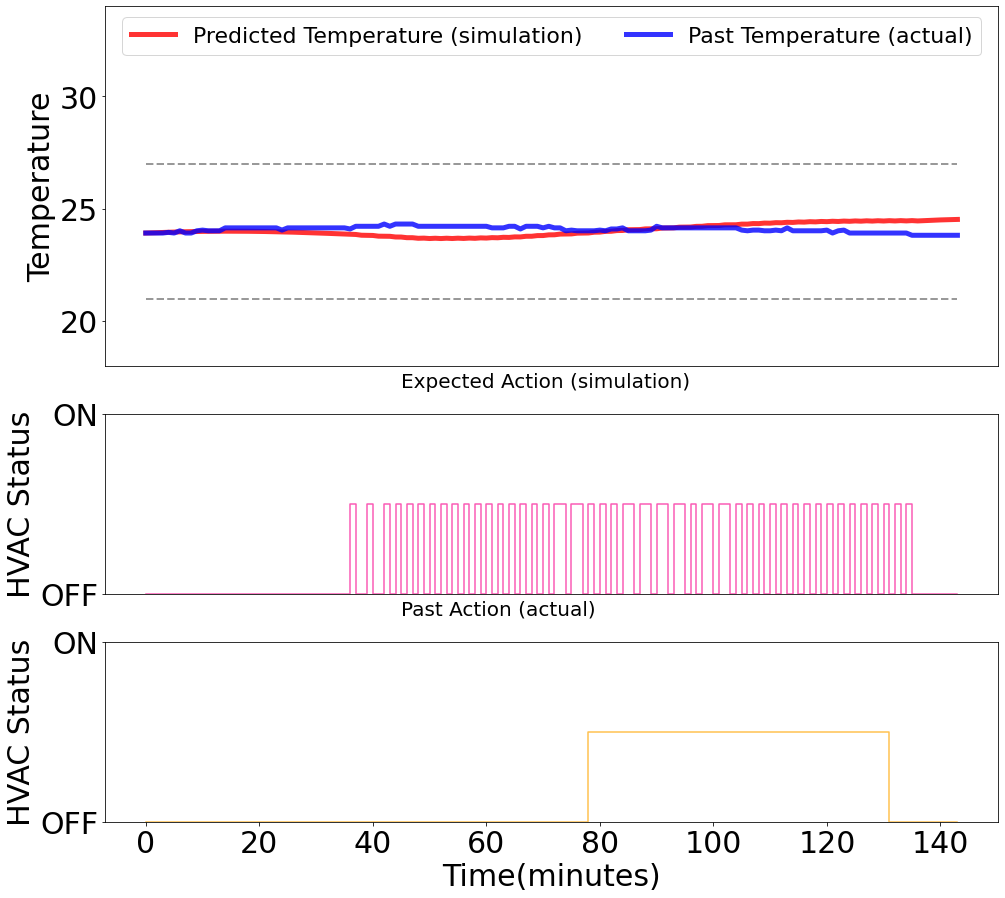

53.0
53
1 일 평균 절감율 :  0.0 실제 평균 온도 :  24.083680555555585 학습 평균 온도 :  24.06268101766206 오차율 :  0.020999537893523268
/raid/deallab/ecm/model_result/2019-10-22/20191022w7_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.82
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-22 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  27 실제 평균 온도 :  23.582847222222213 학습 평균 온도 :  23.83450449495522


<Figure size 432x288 with 0 Axes>

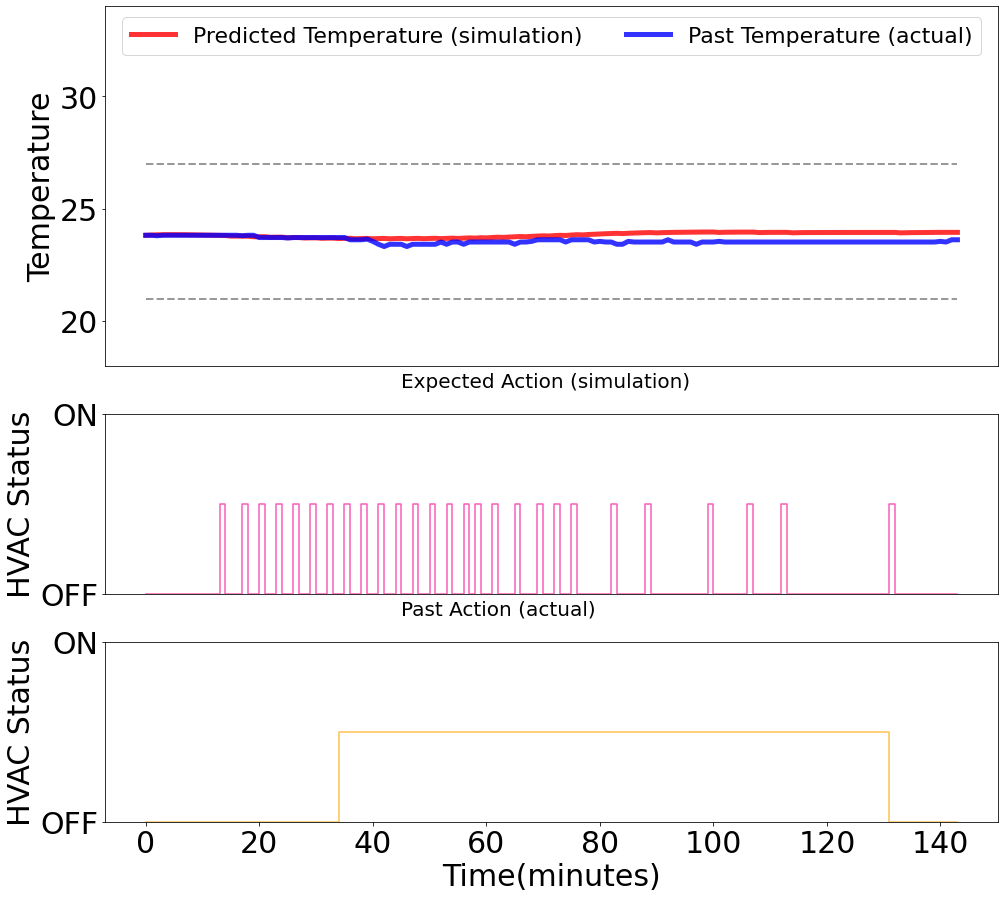

97.0
27
1 일 평균 절감율 :  72.16494845360825 실제 평균 온도 :  23.582847222222213 학습 평균 온도 :  23.83450449495522 오차율 :  -0.25165727273300575
/raid/deallab/ecm/model_result/2019-10-23/20191023w30_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.7
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
2019-10-23 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  35 실제 평균 온도 :  23.762013888888905 학습 평균 온도 :  24.35687911207365


<Figure size 432x288 with 0 Axes>

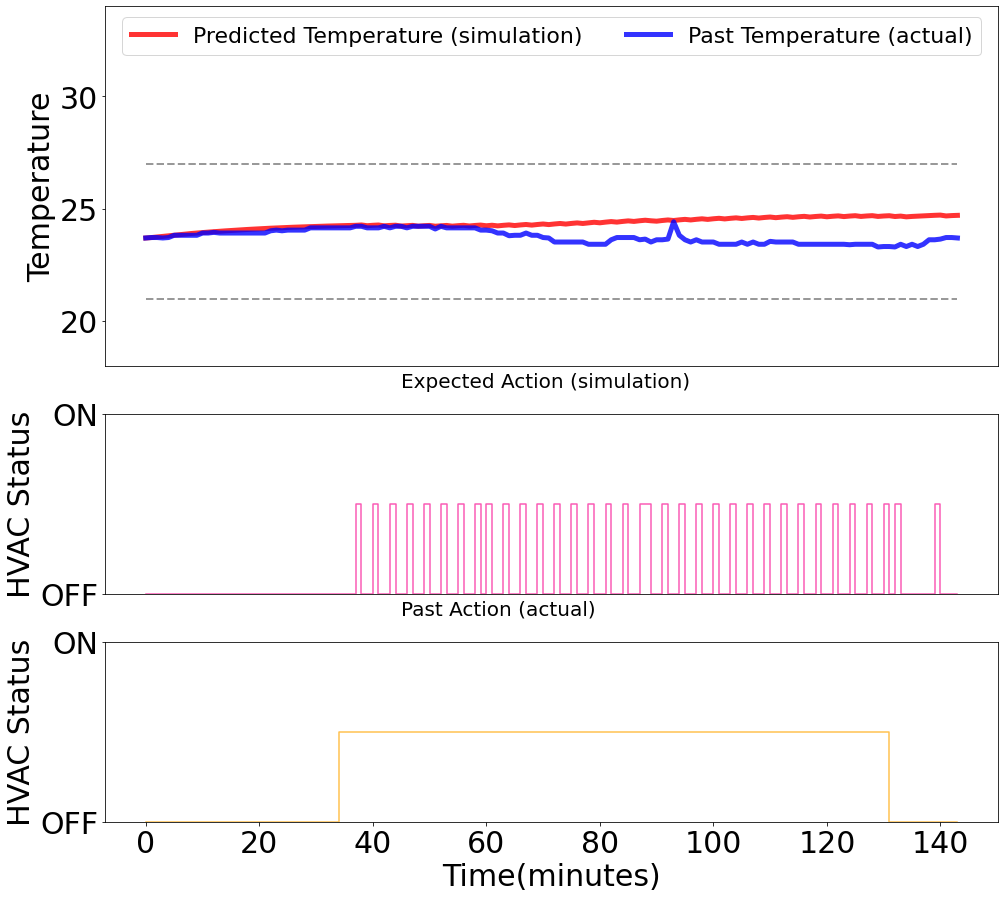

97.0
35
1 일 평균 절감율 :  63.91752577319587 실제 평균 온도 :  23.762013888888905 학습 평균 온도 :  24.35687911207365 오차율 :  -0.594865223184744
/raid/deallab/ecm/model_result/2019-10-24/20191024w7_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.72
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
2019-10-24 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  21 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.507437994461995


<Figure size 432x288 with 0 Axes>

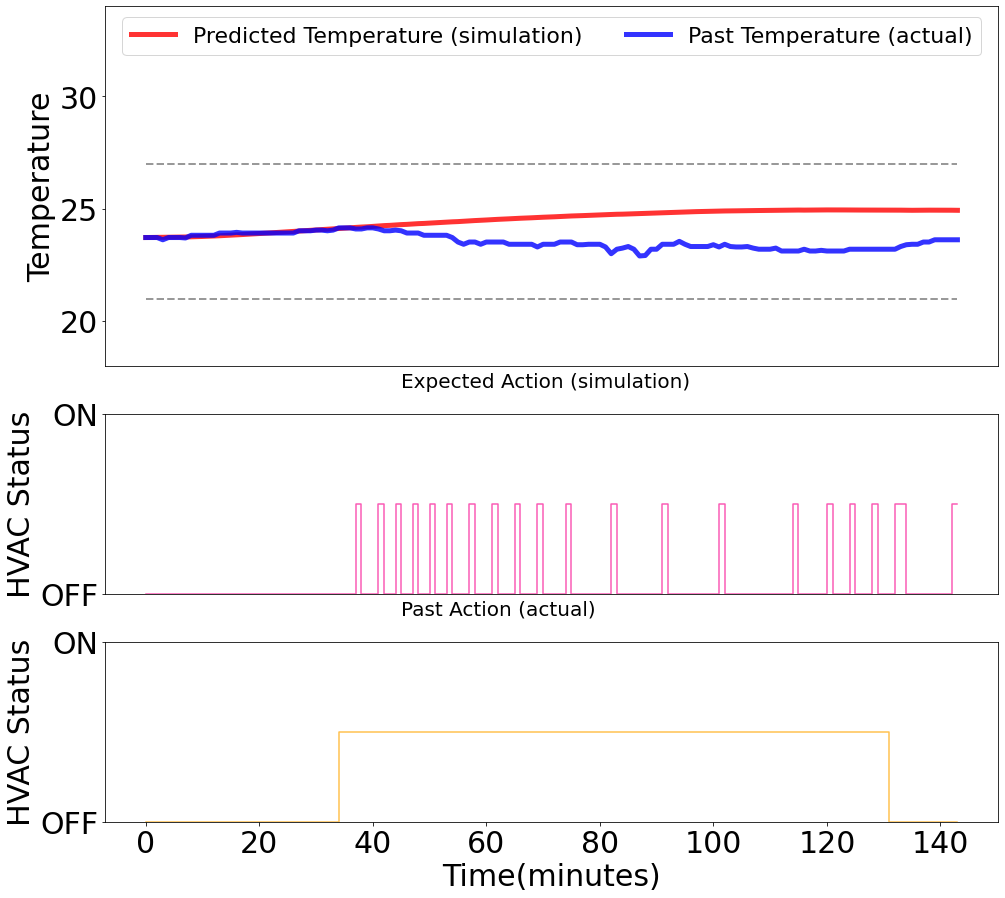

97.0
21
1 일 평균 절감율 :  78.35051546391753 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.507437994461995 오차율 :  -0.952646327795339


In [40]:
Train_date =  datetime.date(2019,8,23)
#start_date = datetime.date(2019, 8,23)
end_date = datetime.date(2019,10,24)
daterange = pd.date_range(Train_date, end_date)

checkpoint_path = '/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DuelingDQN_2023-02-02_04-12-03_hn9krzq/checkpoint_006200/checkpoint-6200'
print(checkpoint_path)

max_action = getMaxAction(df_test_pre)
path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
method_name = "Env_ML"
env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}


env = ECM_Env_ML(env_config)
select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

# print(path)
    
save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN-Dueling'))
    
trainer_dqn.restore(checkpoint_path)
result_final_df = pd.DataFrame()


for single_date in daterange:
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date)
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.window_size.values[0]
    model_name = cur_model.model.values[0]
    
    if Train_date == datetime.date(2019,10,3) or Train_date == datetime.date(2019,10,4):  # 결측 데이터 처리 
        df_test_pre = df_test_pre.interpolate(method='linear', limit_direction='forward')
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     one_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w1_linear_regression.joblib'
#     seven_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w7_linear_regression.joblib'
#     fourtenn_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w14_linear_regression.joblib'
#     model_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w21_linear_regression.joblib'


#     if Train_date <= datetime.date(2019,8,28):
#         path = one_day_path
#     elif Train_date <= datetime.date(2019,9,4):
#         path = seven_day_path
#     elif Train_date <= datetime.date(2019, 9,11):
#         path = fourtenn_day_path
#     else:
#         path = model_path
    path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
    print(path)
    
    max_action = getMaxAction(df_test_pre)    
    
    real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
    new_df = pd.DataFrame()
    new_df.index = real_df.index
    new_df['real_temp'] = real_df['temp']
    new_df['real_hum'] = real_df['hum']
    new_df['real_action'] = real_df['action']
    new_df['RL_temp'] = next_df['f3_temp']
    new_df['RL_hum'] = next_df['f3_hum']
    new_df['RL_action'] = actions
    
    # path 변경하기 
    new_df_path = f'/raid/deallab/yechae/ECM/2023/result/DuelingDQN/{Train_date.strftime("%Y-%m-%d")}-DuelingDQN.csv'
    new_df.to_csv(new_df_path)
    result_final_df = result_df.append(result_final_df)
    
    Train_date = Train_date+datetime.timedelta(days=1)
    
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DuelingDQN/DuelingDQN_final_result.csv'
result_final_df.to_csv(result_df_path)

    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [42]:
result_final_df

date actual_temp predict_temp power_reduction           0          1  \
0  NaN         NaN          NaN             NaN  2019-08-25  26.732014   
0  NaN         NaN          NaN             NaN  2019-08-24  26.305000   
0  NaN         NaN          NaN             NaN  2019-08-23  24.707986   

           2           3  
0  27.334233   99.280576  
0  24.243274  100.000000  
0  25.616542   98.561151

(scheduler +41m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [40]:
result_df

date actual_temp predict_temp power_reduction           0          1  \
0  NaN         NaN          NaN             NaN  2019-10-01  24.186944   

           2          3  
0  24.273519  99.275362

(scheduler +35m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +36m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [ ]:
# Train_date = Train_date = datetime.date(2019,9,21)
# checkpoint_path = checkpoint
# print(checkpoint_path)

# print(Train_date)
# cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
# df_test_pre = makeData(df_train, Train_date )
# date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
# Train_window_size = cur_model.TimeWindows.values[0]
# model_name = cur_model.Model.values[0]

# #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
# path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
# max_action = getMaxAction(df_test_pre)
# method_name = "Env_ML"
# env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}

# env = ECM_Env_ML(env_config)
# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))
# print(path)

# save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
# trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

# trainer_dqn.restore(checkpoint_path)

In [ ]:
Train_date = Train_date = datetime.date(2019,9,21)
checkpoint_path = checkpoint
print(checkpoint_path)

for i in range(52):
    print(Train_date)
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date )
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.TimeWindows.values[0]
    model_name = cur_model.Model.values[0]
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
    path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
    max_action = getMaxAction(df_test_pre)
    method_name = "Env_ML"
    env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    


    env = ECM_Env_ML(env_config)
    select_env = "ECMEnv2023-v0"
    register_env(select_env, lambda config: ECM_Env_ML(env_config))

    print(path)
    
    save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
    trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))
    
    trainer_dqn.restore(checkpoint_path)
    
    
    s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
    train_dqn_episode = 100
    reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
    # === Train === 
    start = time.time()
    start_after_for = time.time()
    print(train_dqn_episode)
    for i in range(train_dqn_episode):
        print("start_after_for : ", time.time() - start_after_for )
        start_episode = time.time()
        result = trainer_dqn.train()
        print(s.format(
            i + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"]
           ))
        reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
        if i % 100 == 0:
            checkpoint = trainer_dqn.save()
            print("checkpoint saved at", checkpoint)
        print("Elapsed time one episode : ", time.time() - start_episode)
        start_after_for = time.time()
    print("Elapsed time : ", time.time() - start)
    checkpoint_path = trainer_dqn.save()

    print("checkpoint saved at", checkpoint)
    
    
    #real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path)
    #new_df = pd.DataFrame()
    #new_df.index = real_df.index
    #new_df['real_temp'] = real_df['temp']
    #new_df['real_hum'] = real_df['hum']
    #new_df['real_action'] = real_df['action']
    #new_df['RL_temp'] = next_df['f3_temp']
    #new_df['RL_hum'] = next_df['f3_hum']
    #new_df['RL_action'] = actions
    
    #new_df_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DQN-pre.csv'
    #new_df.to_csv(new_df_path)
    #result_df = result_df.append(result_df)
    
    Train_date = Train_date+datetime.timedelta(days=1)
    
#result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DQN_final-pre.csv'
#result_df.to_csv(result_df_path)

#Train_date = Train_date+datetime.timedelta(days=1)
    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [ ]:
# Train_date = Train_date+datetime.timedelta(days=1)
# checkpoint_path = checkpoint

# for i in range(54):
#     print(Train_date)
#     cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
#     df_test_pre = makeData(df_train, Train_date )
#     date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
#     Train_window_size = cur_model.TimeWindows.values[0]
#     model_name = cur_model.Model.values[0]
    
#     dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
#     max_action = getMaxAction(df_test_pre)
#     env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    
#     if model_name in ml_models:
#         path = ml_path
#         print("ML : ", model_name)
#         #model = joblib.load(path)
#         method_name = "Env_ML"
#         env = ECM_Env_ML(env_config)
#         select_env = "ECMEnv2023-v0"
#         register_env(select_env, lambda config: ECM_Env_ML(env_config))
#     else:
#         path = dl_path
#         print("DL : ", model_name)
#         Train_date = Train_date+datetime.timedelta(days=1)
#         continue;
#         #model = tf.keras.models.load_model(dl_path)
#         #method_name = "Env_DL"
#         #env = ECM_Env_DL(env_config)
#         #select_env = "ECMEnv2023-v0"
#         #register_env(select_env, lambda config: ECM_Env_DL(env_config))
#     print(path)
    
#     save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
#     trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))
    
#     trainer_dqn.restore(checkpoint_path)
    
    
#     s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
#     train_dqn_episode = 500
#     reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
#     # === Train === 
#     start = time.time()
#     start_after_for = time.time()
#     print(train_dqn_episode)
#     for i in range(train_dqn_episode):
#         print("start_after_for : ", time.time() - start_after_for )
#         start_episode = time.time()
#         result = trainer_dqn.train()
#         print(s.format(
#             i + 1,
#             result["episode_reward_min"],
#             result["episode_reward_mean"],
#             result["episode_reward_max"],
#             result["episode_len_mean"]
#            ))
#         reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
#         if i % 500 == 0:
#             checkpoint = trainer_dqn.save()
#             print("checkpoint saved at", checkpoint)
#         print("Elapsed time one episode : ", time.time() - start_episode)
#         start_after_for = time.time()
#     print("Elapsed time : ", time.time() - start)
#     checkpoint_path = trainer_dqn.save()

#     print("checkpoint saved at", checkpoint)
#     Train_date = Train_date+datetime.timedelta(days=1)


# #Train_date = Train_date+datetime.timedelta(days=1)
#     # ENV 세팅
#     #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
#     #env = ECM_Env_DL(env_config)
    
#     #select_env = "ECMEnv2023-v0"
#     #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [39]:
Train_date = datetime.date(2019,9,21)
# init 
cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
df_test_pre = makeData(df_train, Train_date )
date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
Train_window_size = cur_model.TimeWindows.values[0]
model_name = cur_model.Model.values[0]

dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
if model_name in ml_models:
    path = ml_path
    print("ML : ", model_name)
    #model = joblib.load(path)
    method_name = "Env_ML"
else:
    path = dl_path
    print("DL : ", model_name)
    #model = tf.keras.models.load_model(dl_path)
    method_name = "Env_DL"
print(path)
max_action = getMaxAction(df_test_pre)

# ENV 세팅
env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
env = ECM_Env_ML(env_config)

select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 800
config_dqn["timesteps_per_iteration"] = 144
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 144
config_dqn["dueling"] = False
config_dqn["double_q"] = False

save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
print(save_path)
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

2023-01-26 15:02:22,874	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-01-26 15:02:22,879	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-01-26 15:02:22,883	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-01-26 15:02:22,883	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


ML :  extra_trees_regressor
/raid/deallab/ecm/model_result_no_window/2019-09-21/20190921w14_extra_trees_regressor.joblib
Reset data f3_temp : 25.2
/raid/deallab/yechae/ECM/2023/result/2019-09-21/
Reset data f3_temp : 25.2
Reset data f3_temp : 24.6


2023-01-26 15:02:35,609	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-01-26 15:02:35,610	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-01-26 15:02:35,868	INFO trainable.py:130 -- Trainable.setup took 12.995 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
